# LogGabor user guide


Table of content
----------------

* [What is the LogGabor package?](LogGabor.ipynb#What-is-the-LogGabor-package?) 

* [Installing](LogGabor.ipynb#Install) 

* [Importing the library](LogGabor.ipynb#Importing-the-library)

* [Properties of log-Gabor filters](LogGabor.ipynb#Properties-of-log-Gabor-filters)

* [Testing filter generation](LogGabor_testing-filter-generation.ipynb) 

* [Testing on a sample image](LogGabor.ipynb#Testing-on-a-sample-image) 

* [Building a pyramid](LogGabor_making-a-pyramid.ipynb) 

* [An example of fitting images with log-Gabor filters](LogGabor_fit-example.ipynb) 

## Importing the library

In [1]:
%load_ext autoreload
%autoreload 2
from LogGabor import LogGabor
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)

To install the dependencies related to running this notebook, see [Installing notebook dependencies](#Installing-notebook-dependencies).

[Back to top](#LogGabor-user-guide)

In [2]:
import holoviews as hv
#hv.notebook_extension('bokeh')
%load_ext holoviews.ipython
%output size=150 dpi=120
%load_ext autoreload
%autoreload 2
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 12
figsize=(fig_width, .618*fig_width)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing filter generation

Here, we will generate some LogGabor filters.

Defining a reference log-gabor  (look in the corners!)

In [3]:
sf_0 = .02 # TODO .1 cycle / pixel (Geisler)
params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':0., 'B_theta': lg.pe.B_theta}

In [4]:
%opts Image (cmap='gray')
%opts Image.Fourier_domain (cmap='hot')

In [5]:
def fourier_domain(arr):
    return hv.Image(arr, group='Fourier domain',
                 key_dimensions=[r'$f_Y$', r'$f_X$'],
                 value_dimensions=[hv.Dimension('Fourier', range=(0,0.01))])
def image_domain(arr):
    return hv.Image(arr,group='Image domain',
                 key_dimensions=[r'$Y$', r'$X$'],
                 value_dimensions=[hv.Dimension('Image', range=(-1,1))])

:Layout
   .Fourier_domain.I :Image   [x,y]   (z)
   .Image_domain.I   :Image   [x,y]   (z)
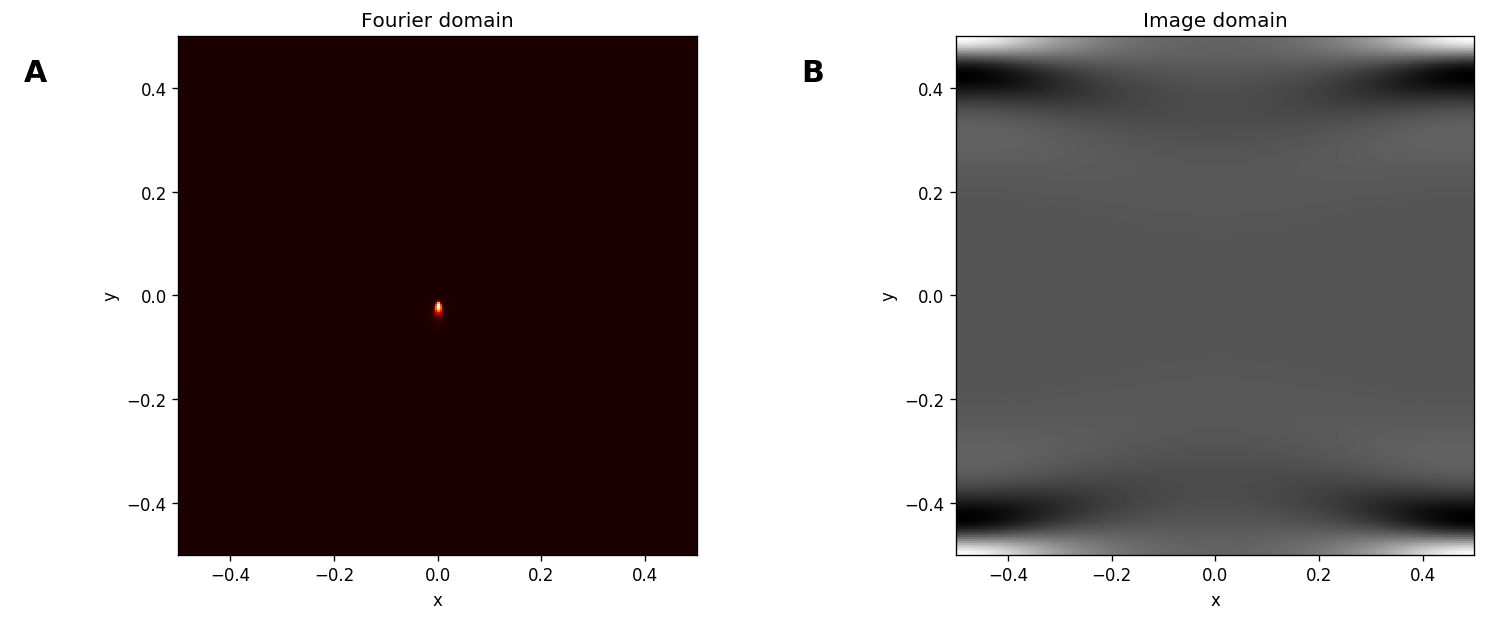

In [6]:
FT_lg = lg.loggabor(0, 0, **params)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Translating in the middle:

In [7]:
N_X, N_Y = 256, 256 #image.shape
help(lg.translate)

Help on method translate in module SLIP.SLIP:

translate(image, vec, preshift=True) method of LogGabor.LogGabor.LogGabor instance
    Translate image by vec (in pixels)
    
    Note that the convention for coordinates follows that of matrices: the origin is at the top left of the image, and coordinates are first the rows (vertical axis, going down) then the columns (horizontal axis, going right).



same params, larger frequency with sf_0

:Layout
   .Fourier_domain.I :Image   [x,y]   (z)
   .Image_domain.I   :Image   [x,y]   (z)
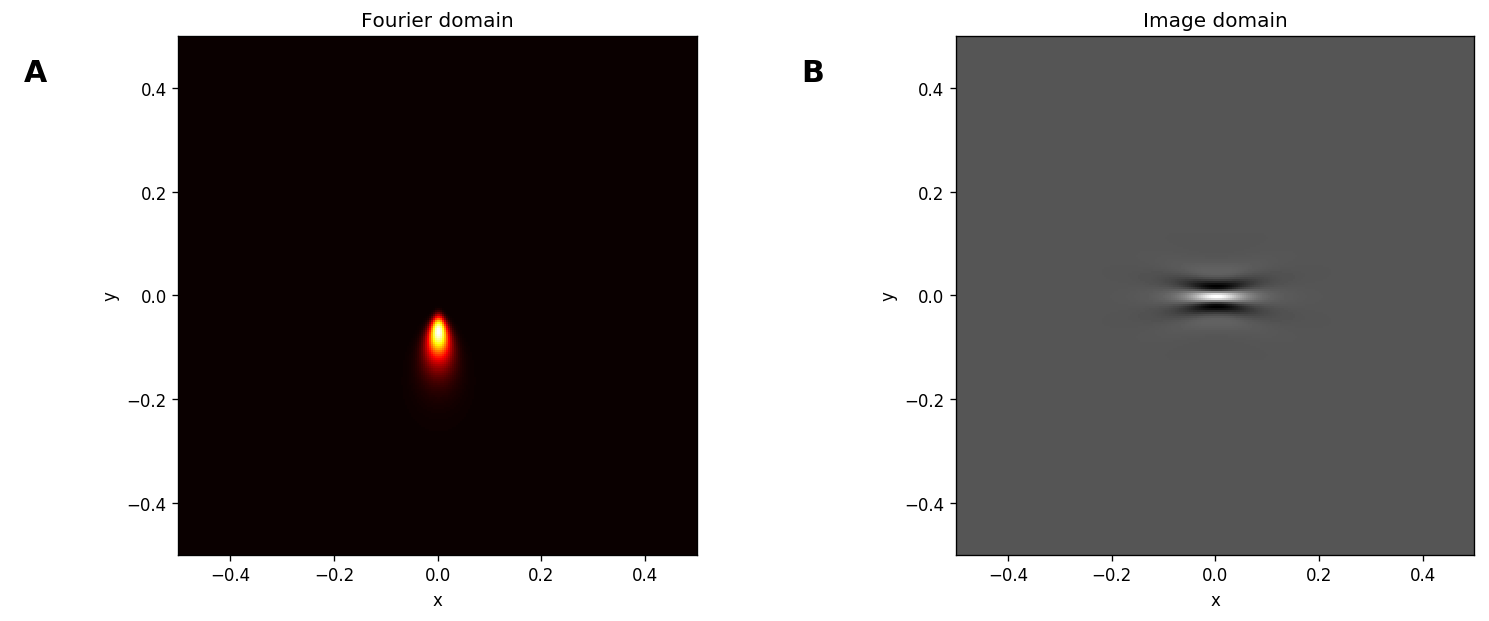

In [8]:
params2 = {'sf_0':sf_0*4, 'B_sf':lg.pe.B_sf, 'theta':0., 'B_theta':lg.pe.B_theta}
FT_lg = lg.loggabor(N_X/2, N_Y/2, **params2)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Same params, but larger frequency with sf_0

In [9]:
params2 = {'sf_0':sf_0*4, 'B_sf':lg.pe.B_sf, 'theta':0., 'B_theta':lg.pe.B_theta}

:Layout
   .Fourier_domain.I :Image   [x,y]   (z)
   .Image_domain.I   :Image   [x,y]   (z)
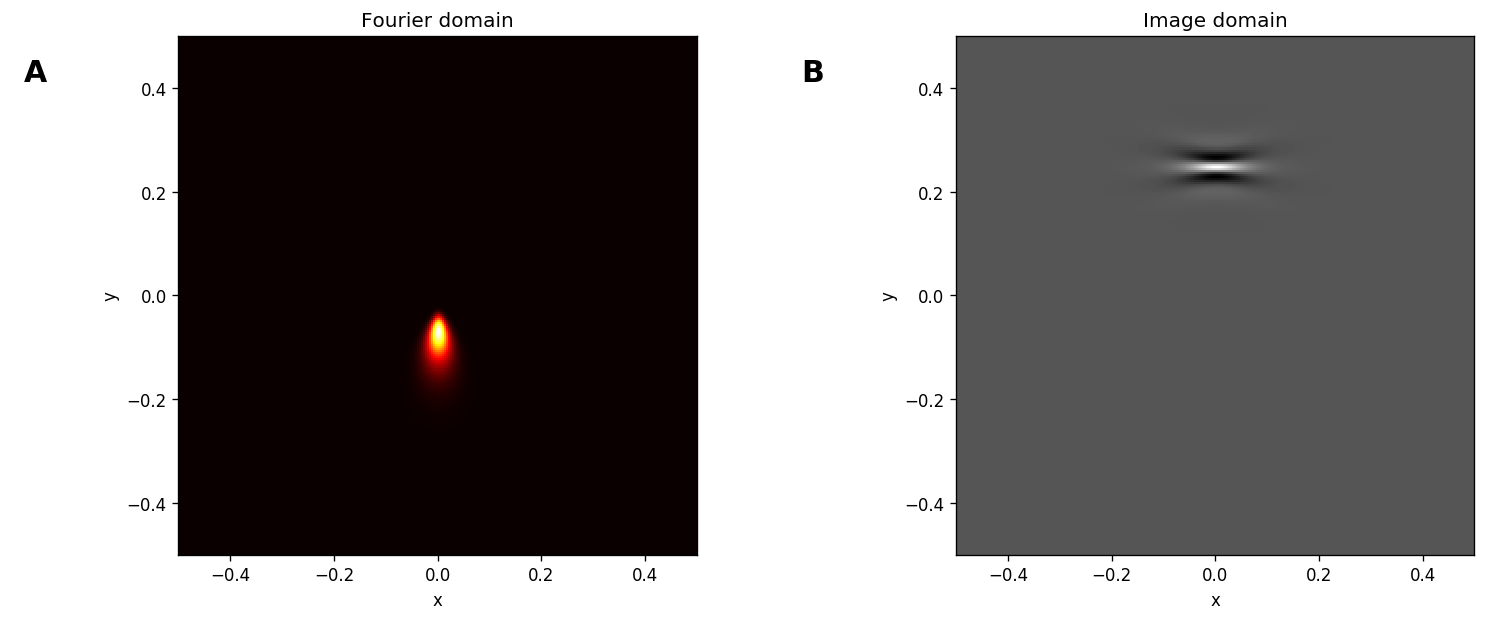

In [10]:
FT_lg = lg.loggabor(N_X/4, N_Y/2, **params2)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Narrower with a smaller B_theta:

:Layout
   .Fourier_domain.I :Image   [x,y]   (z)
   .Image_domain.I   :Image   [x,y]   (z)
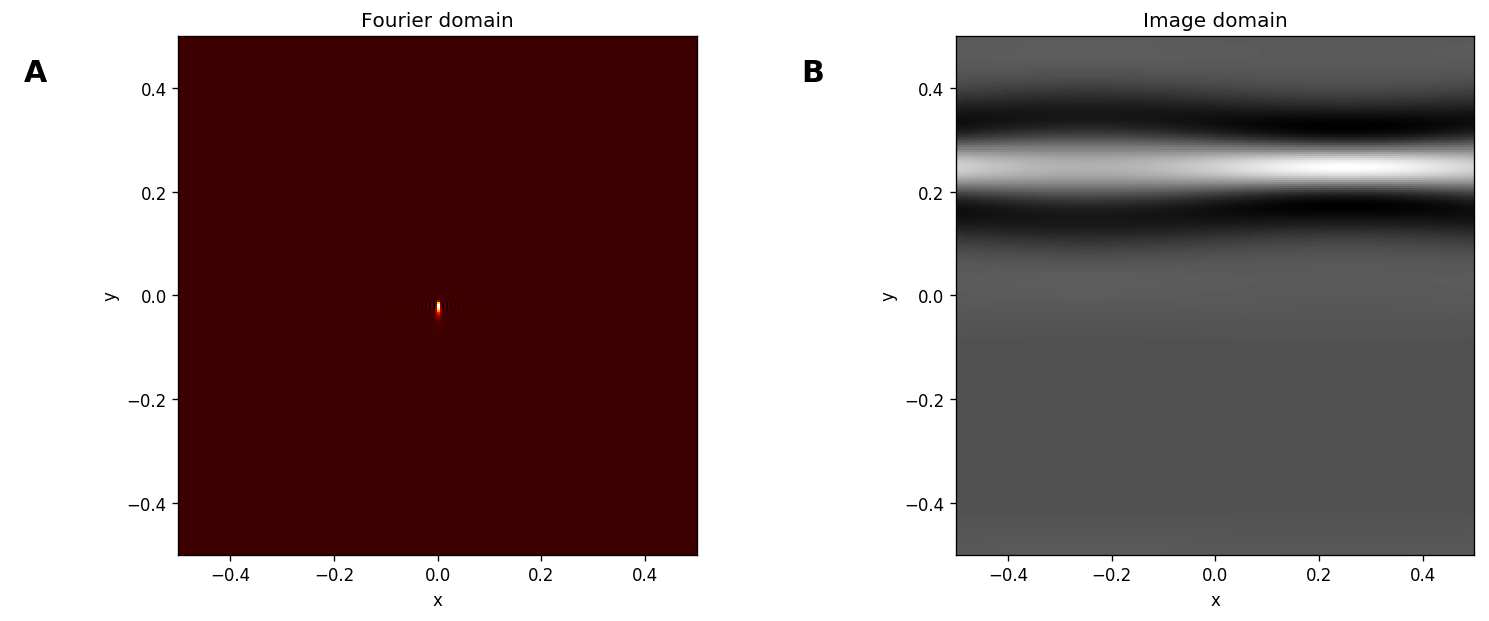

In [11]:
params3 = {'sf_0':sf_0, 'B_sf':lg.pe.B_sf, 'theta':0., 'B_theta':lg.pe.B_theta/2}
FT_lg = lg.loggabor(N_X/4, 3*N_Y/4, **params3)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Broader spectrum with B_sf

:Layout
   .Fourier_domain.I :Image   [x,y]   (z)
   .Image_domain.I   :Image   [x,y]   (z)
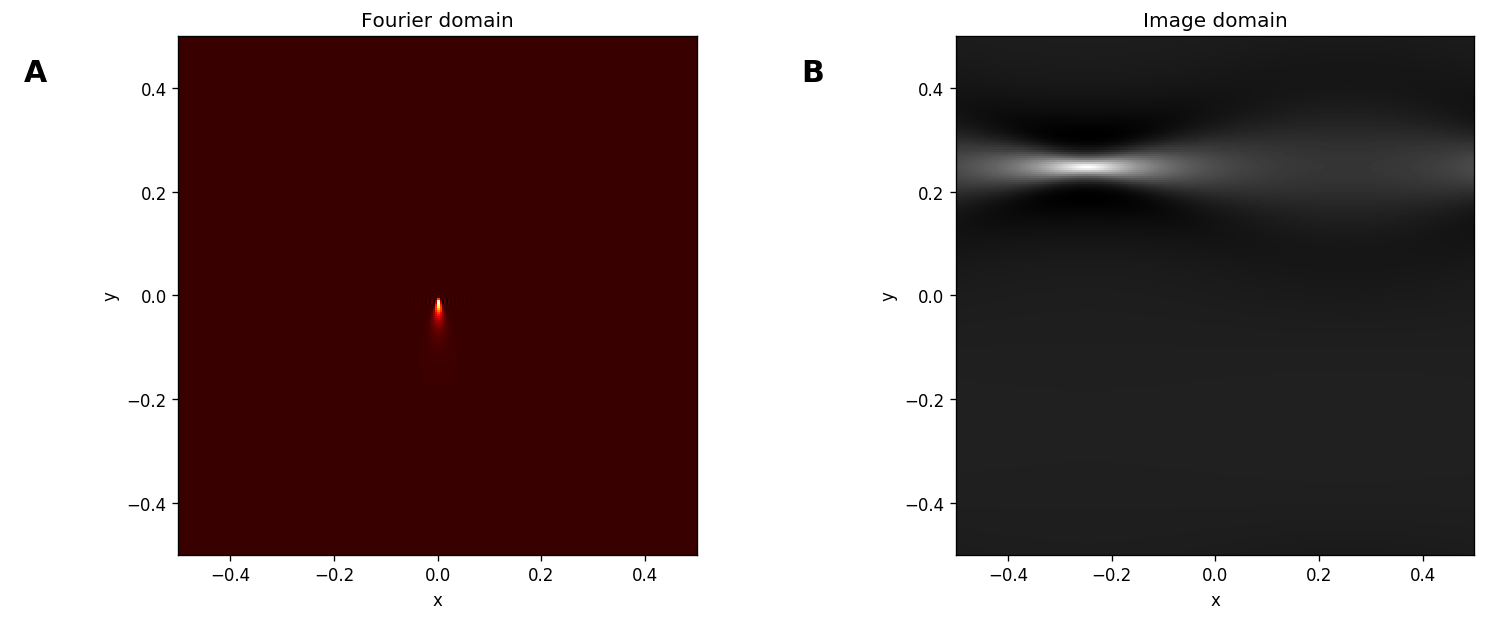

In [12]:
params4 = {'sf_0':sf_0, 'B_sf':lg.pe.B_sf*2., 'theta':0., 'B_theta':lg.pe.B_theta}
FT_lg = lg.loggabor(N_X/4, N_Y/4, **params4)
(fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
+ image_domain(lg.normalize(lg.invert(FT_lg), center=False)))

Using a function to explore these parameters:

In [13]:
def lg_explore(param_name, param_range, angle=False, movie=True):
    if movie:
        amp_map, phase_map = hv.HoloMap(), hv.HoloMap()
    else:
        ims = []
    for param_ in param_range:
        if angle:
            title = np.str(param_*180/np.pi) + r'$^0$'
        else:
            title = np.str(param_)
        if param_name=='phase':
            FT_phase = np.exp(-1j*param_)
            params_=params.copy()
        else:
            FT_phase = 1
            params_=params.copy()
            params_.update({param_name:param_})
        FT_lg = lg.loggabor(N_X/2, N_Y/2, **params_) * FT_phase
        
        amp =   fourier_domain(lg.normalize(np.absolute(FT_lg), center=False))
        phase = image_domain(lg.normalize(lg.invert(FT_lg),  center=False))
        
        if movie:
            amp_map[param_] = amp
            phase_map[param_] = phase
        else:
            ims.append((amp + phase))
    if movie:
        return amp_map + phase_map
    else:
        return np.sum(ims).cols(2)

Now exploring these parameters individually:

:Layout
   .Fourier_domain.I :HoloMap   [Default]
      :Image   [x,y]   (z)
   .Image_domain.I   :HoloMap   [Default]
      :Image   [x,y]   (z)
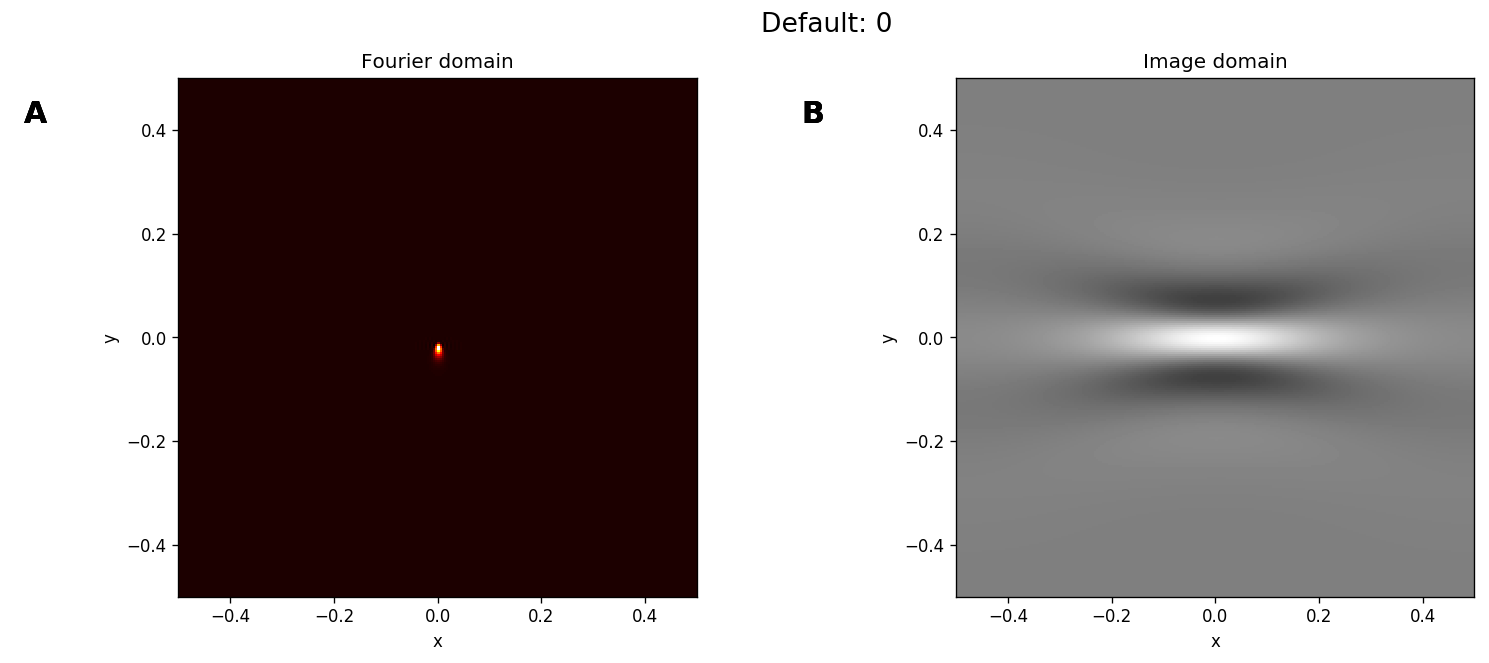
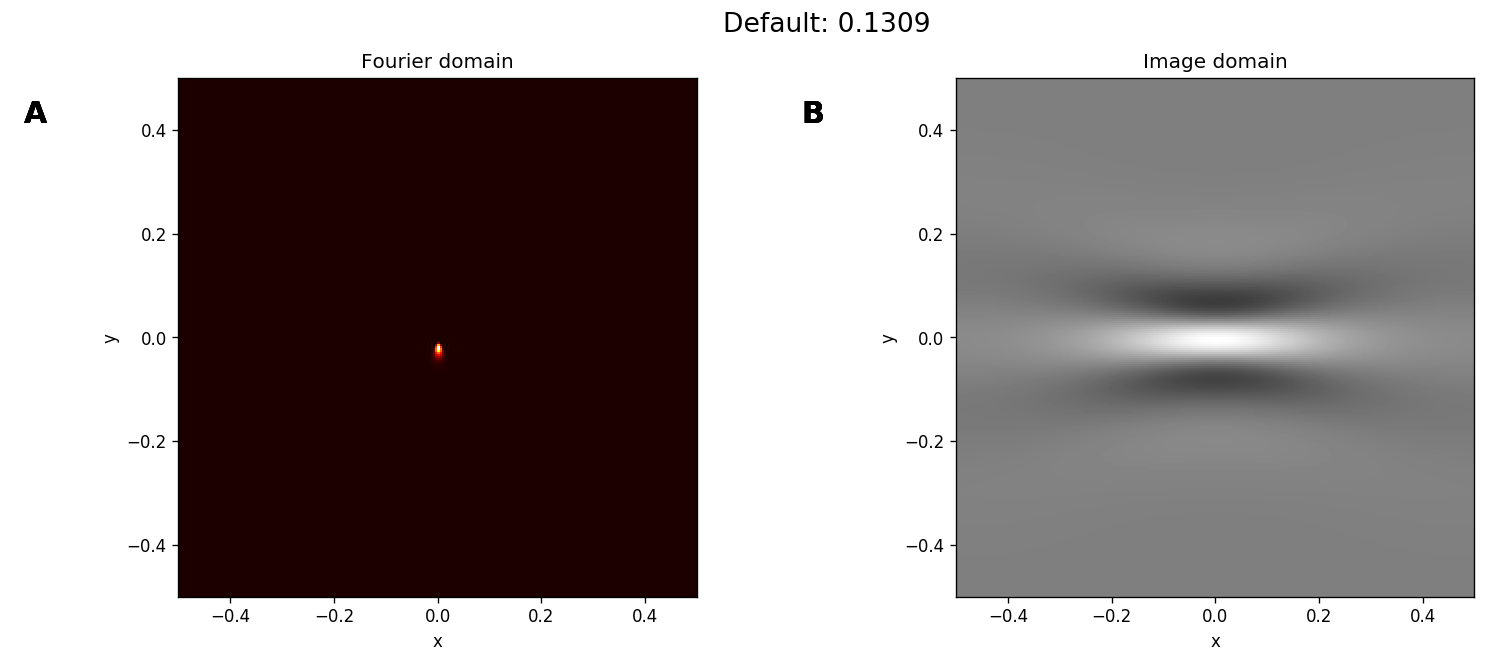
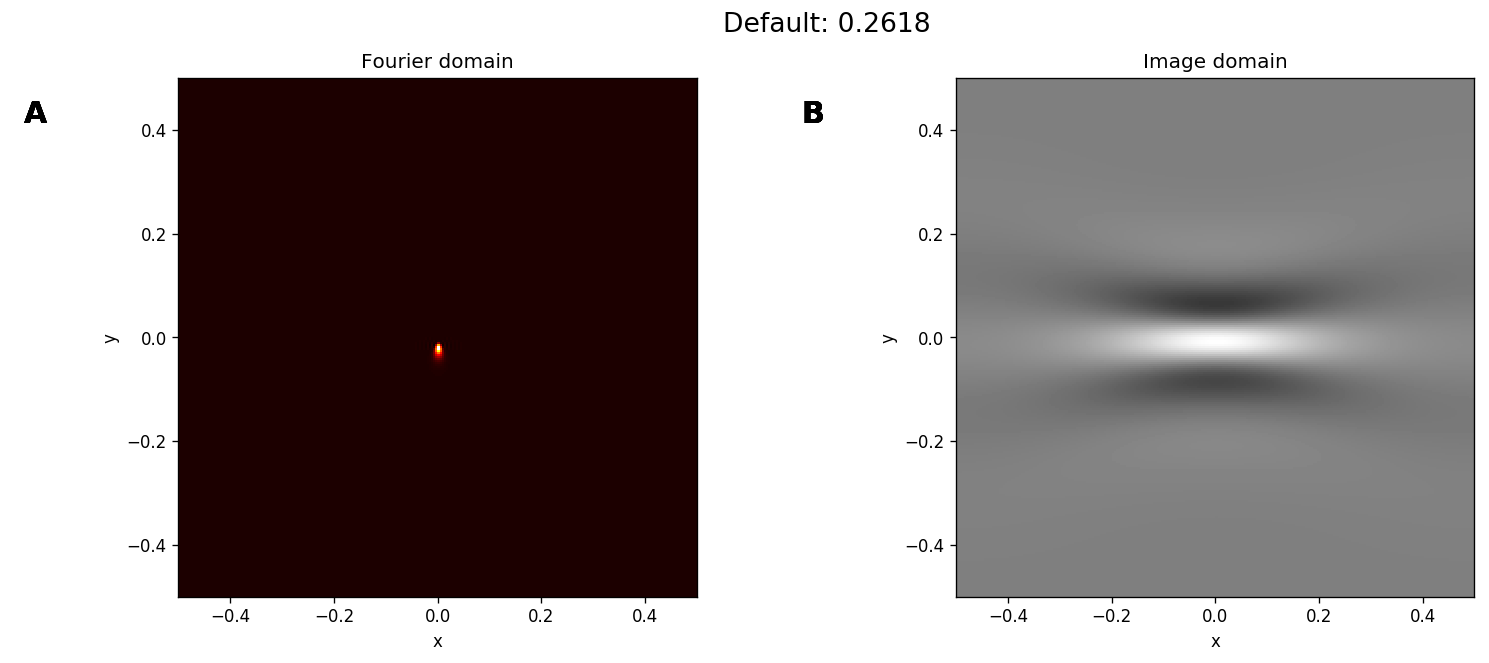
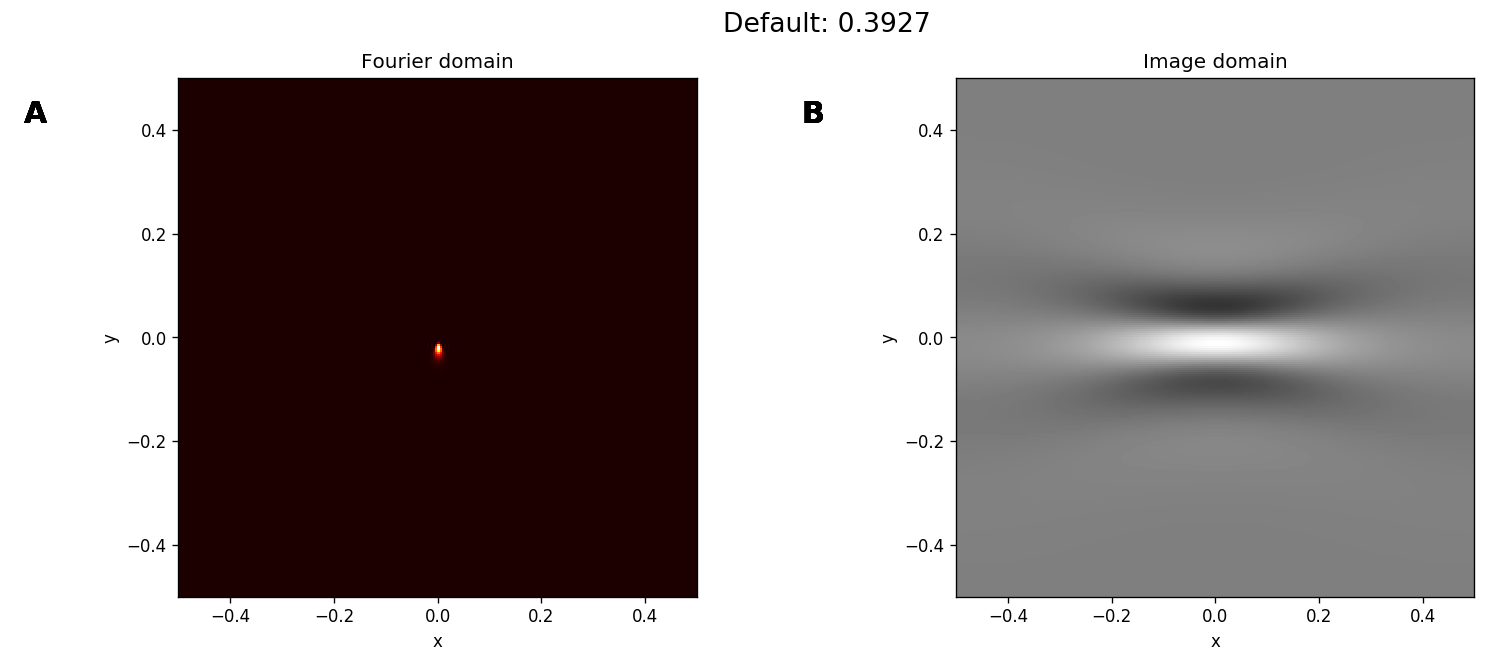
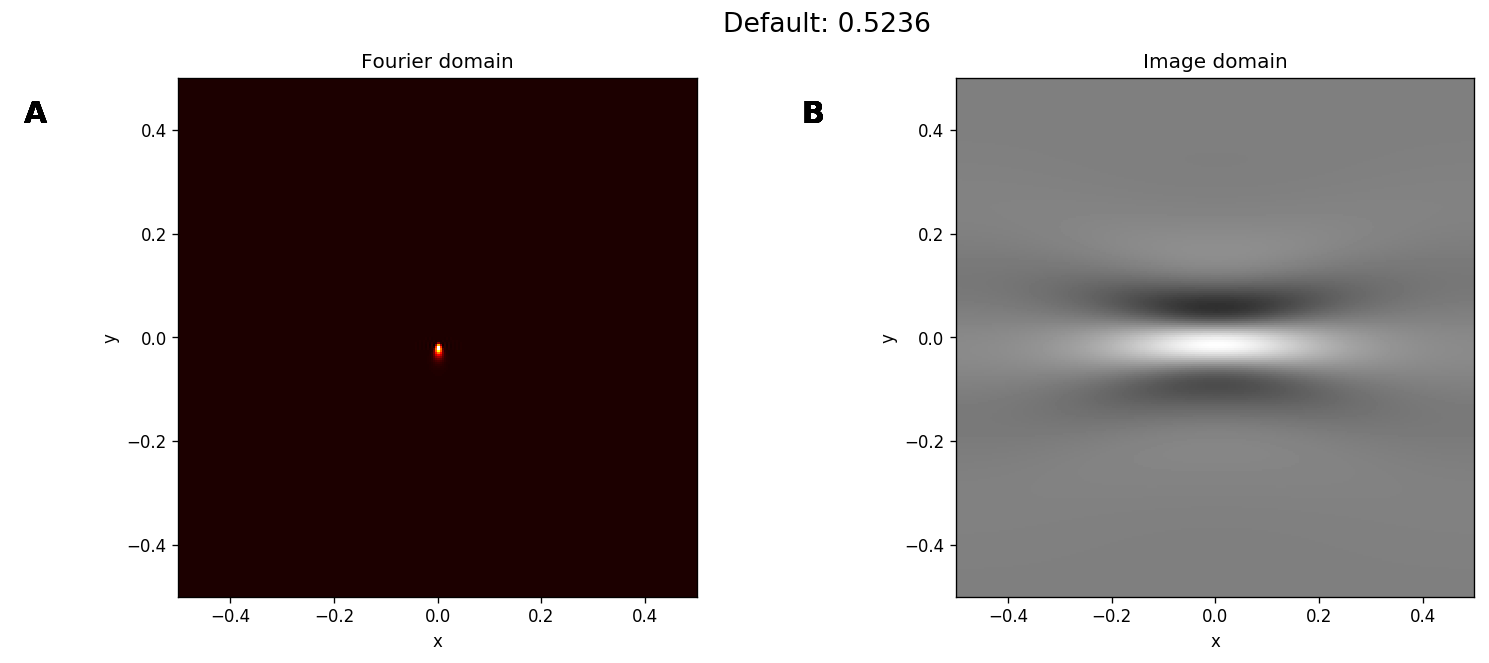
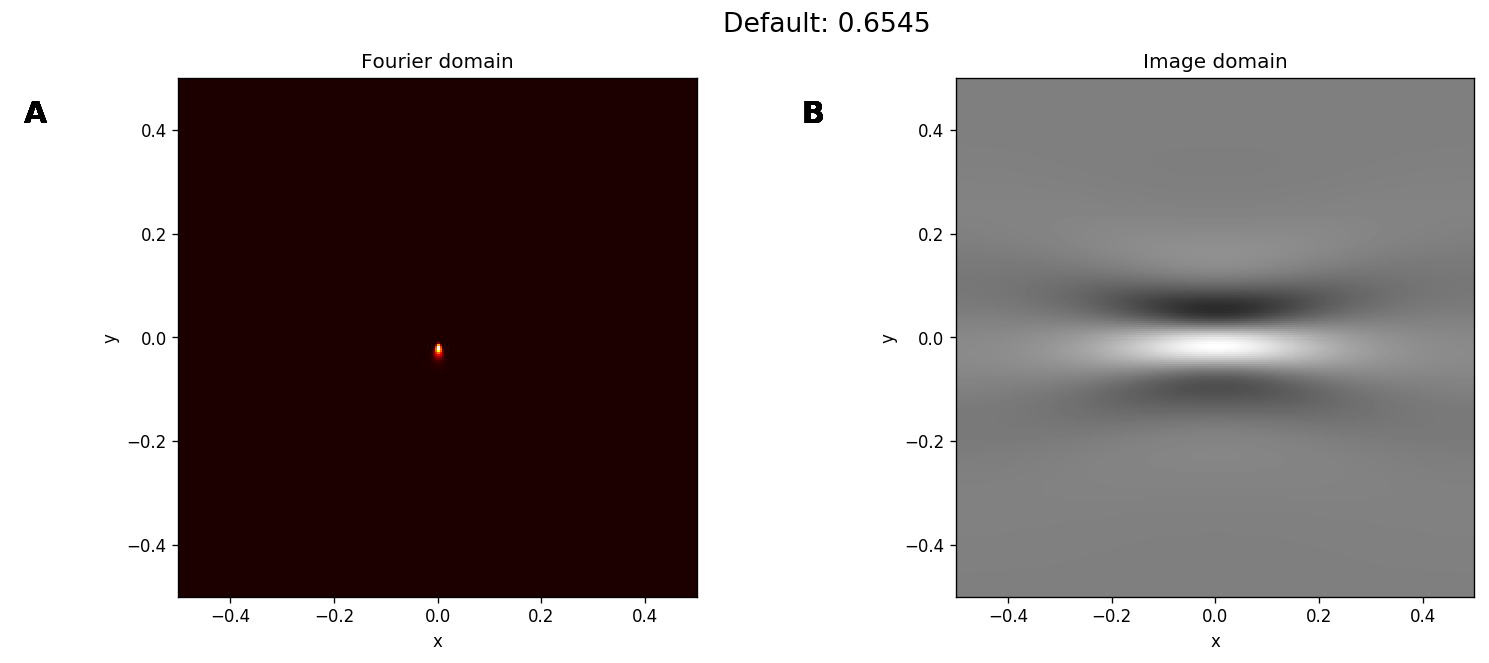
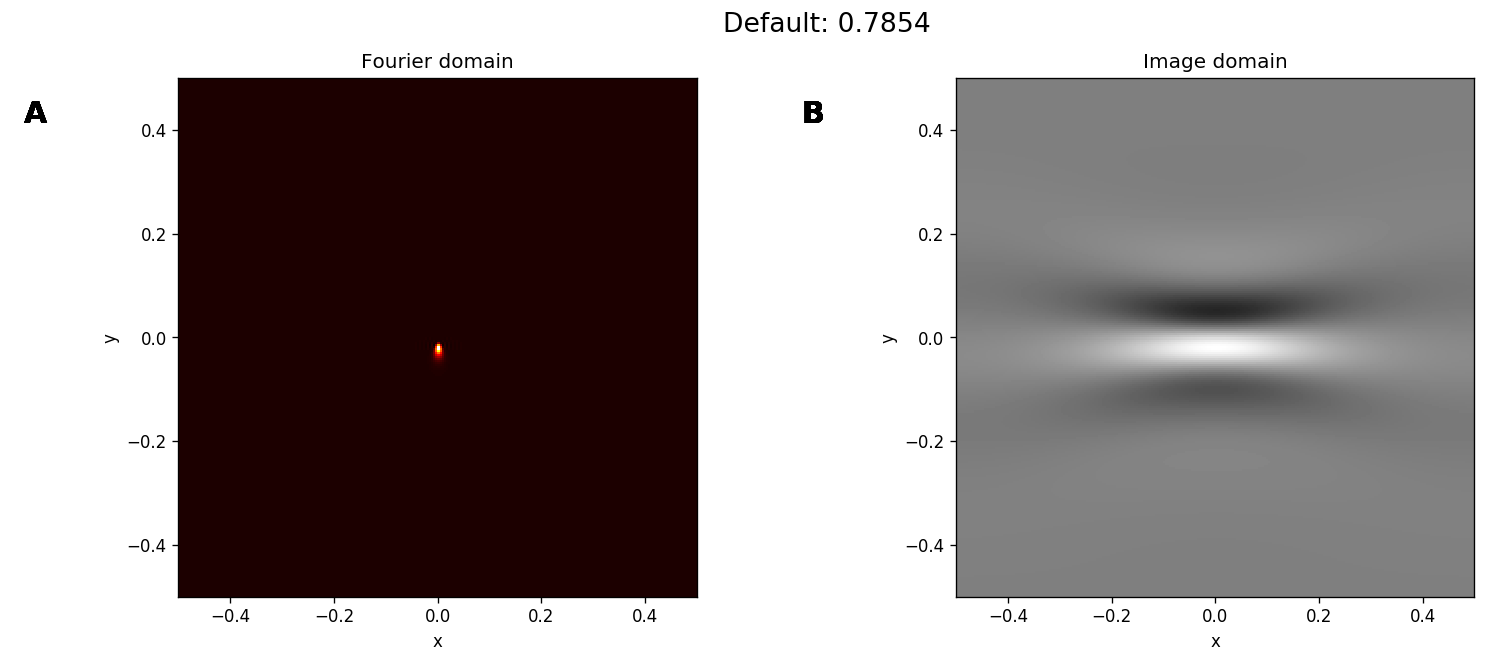
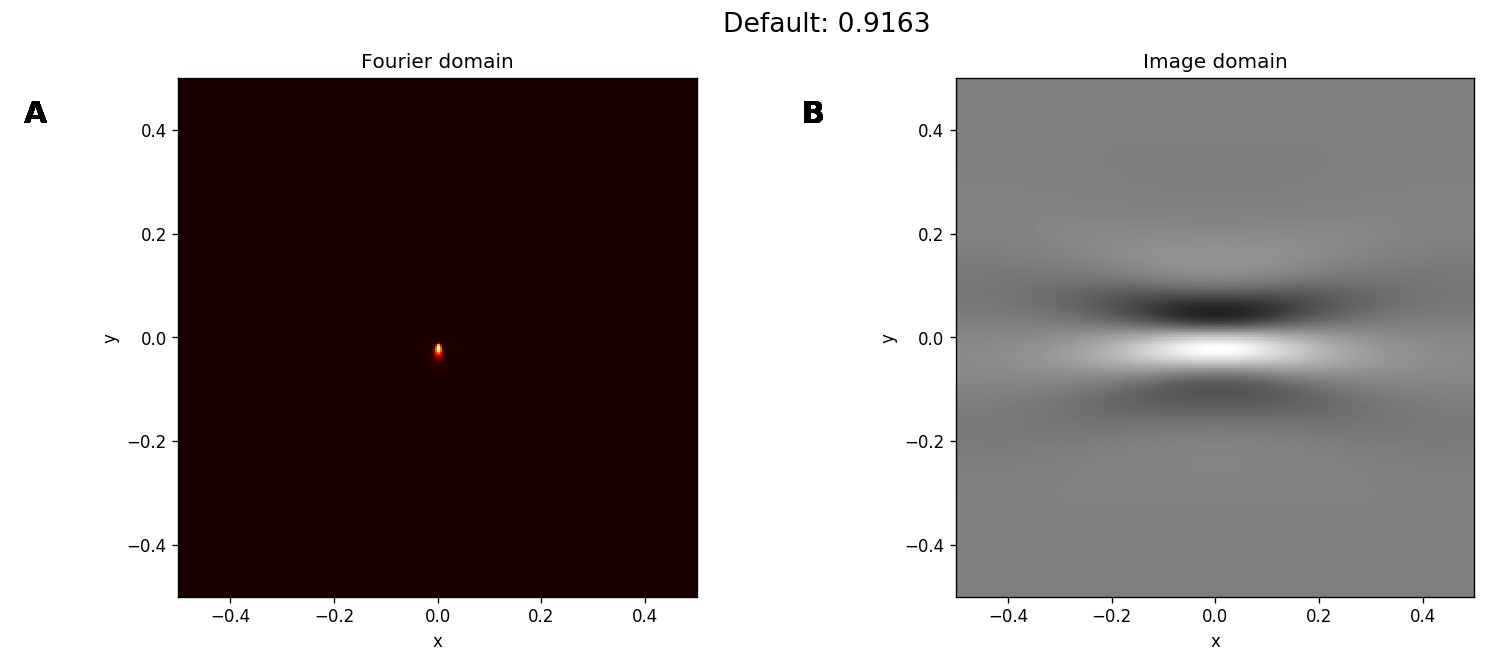
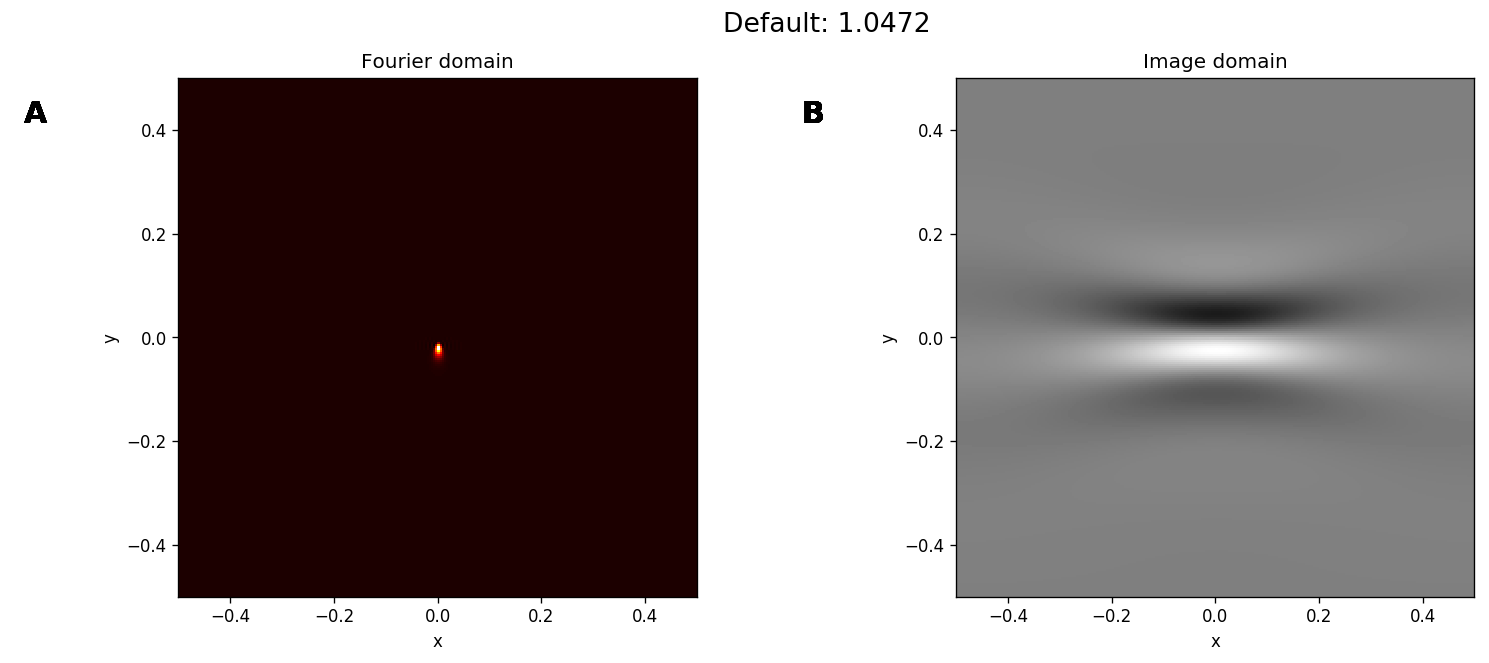
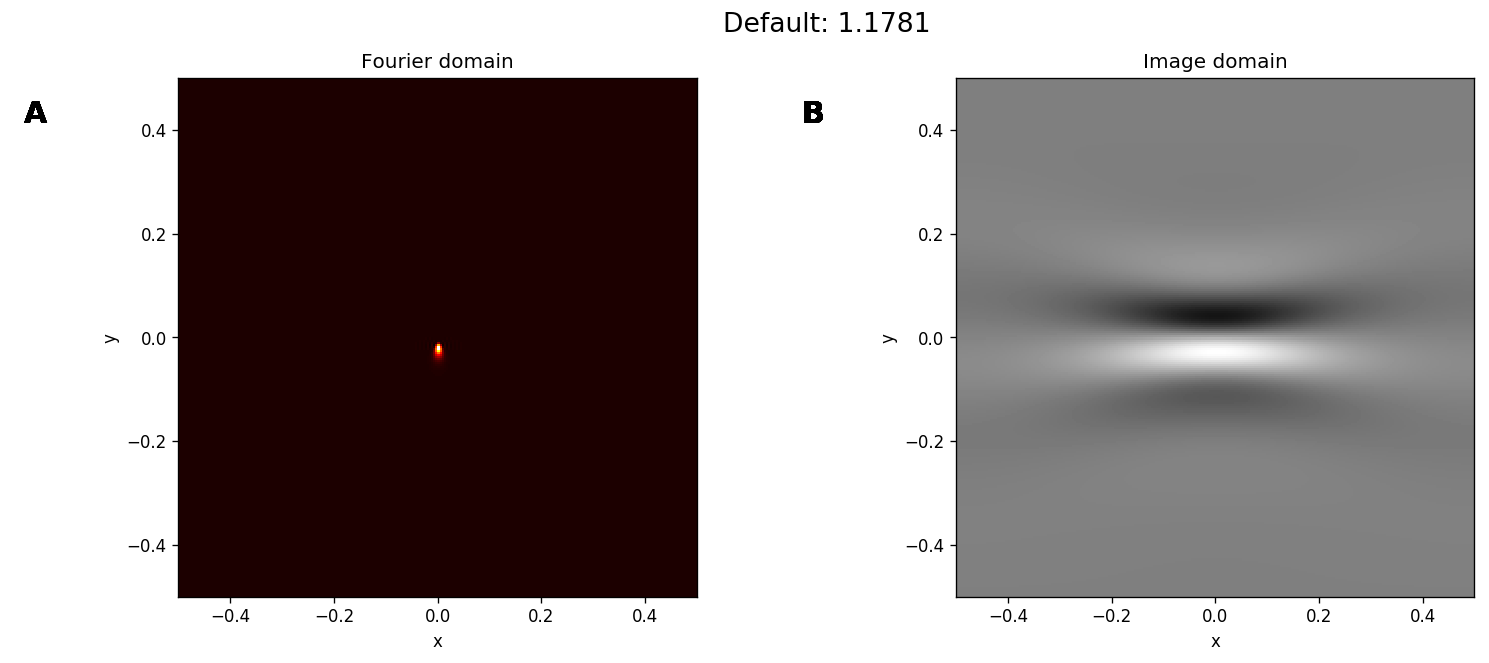
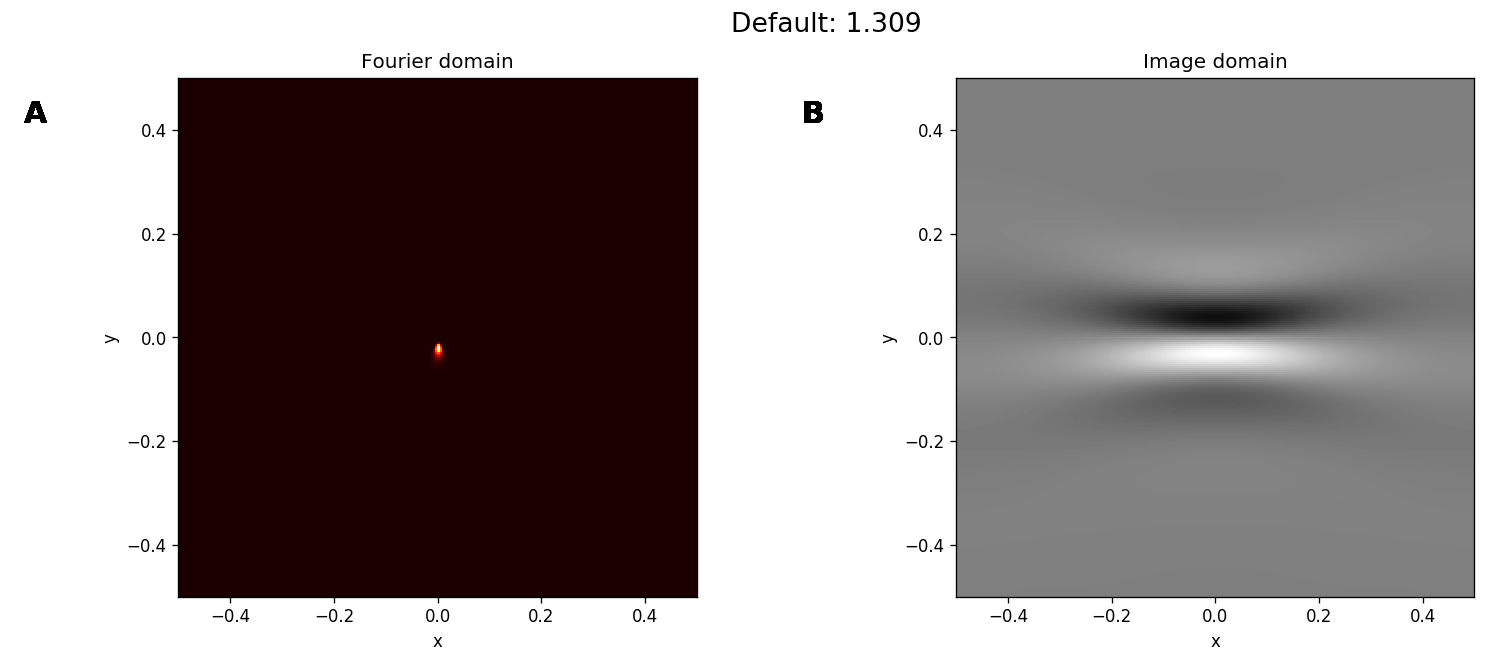
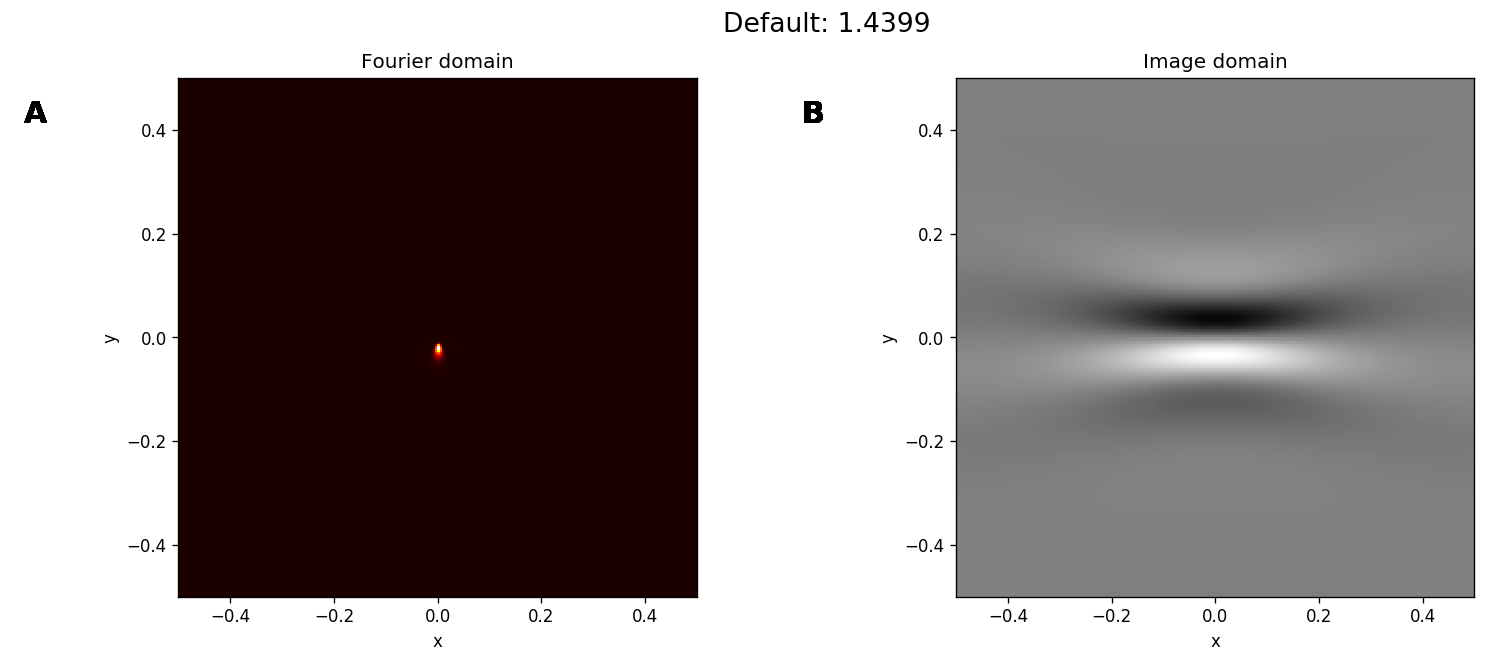
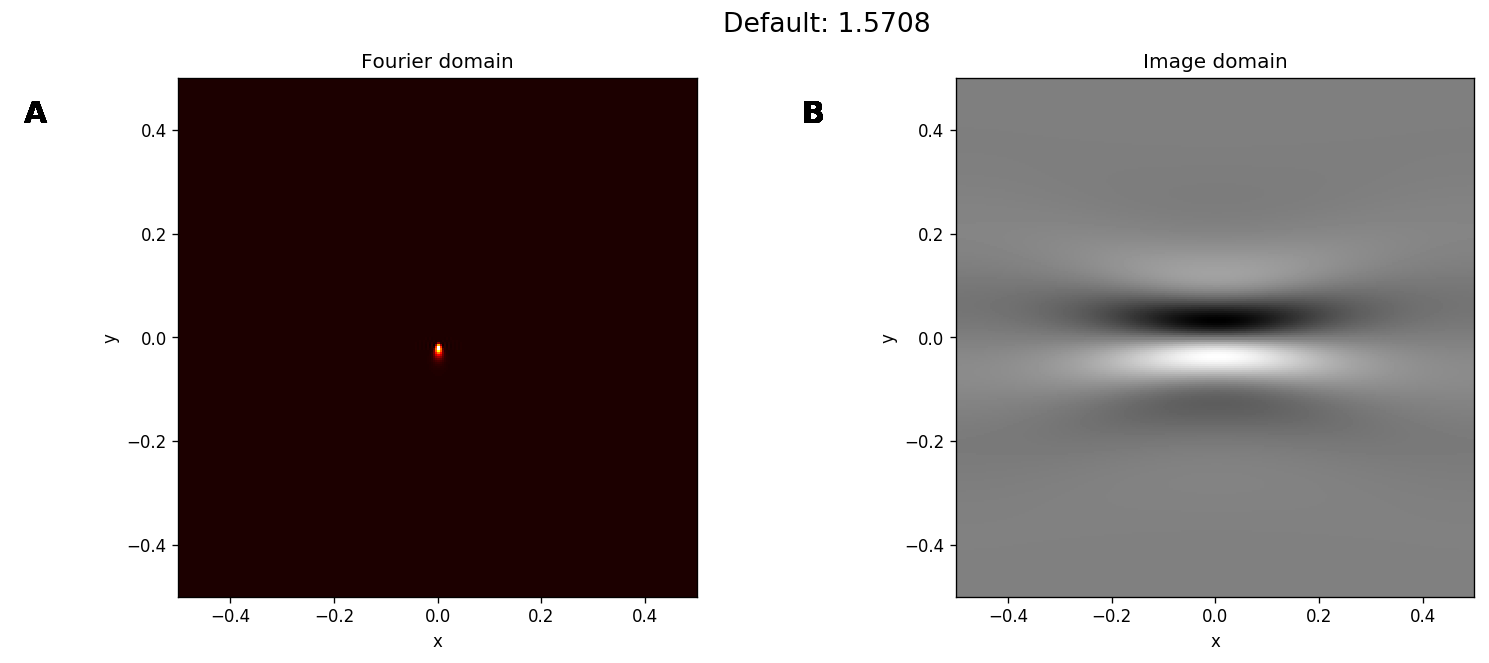
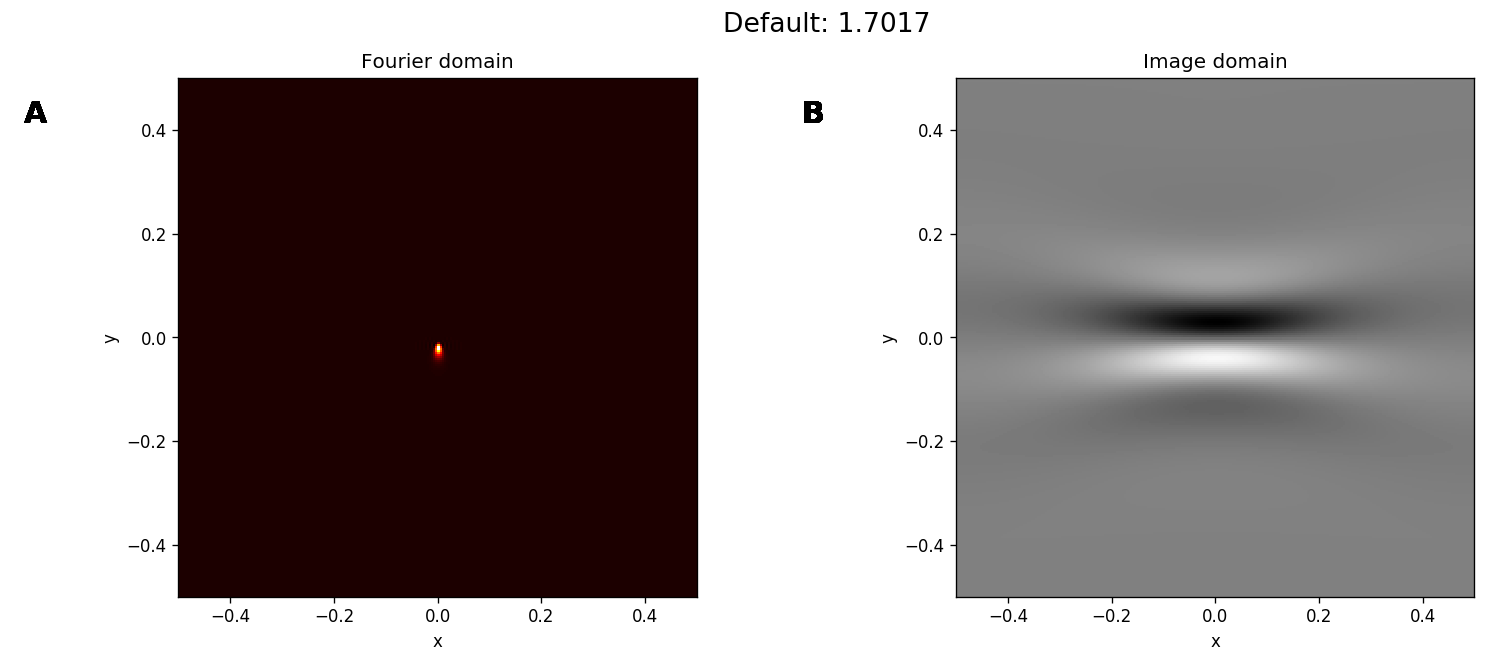
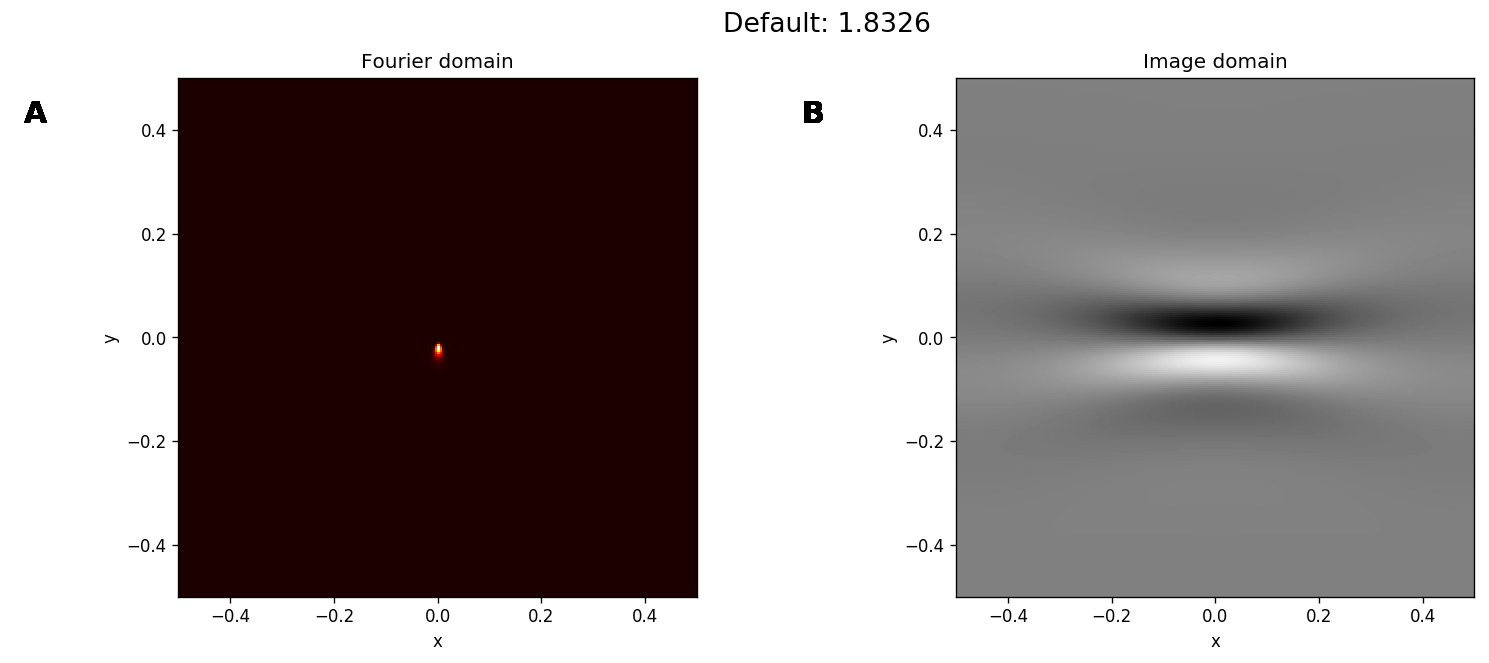
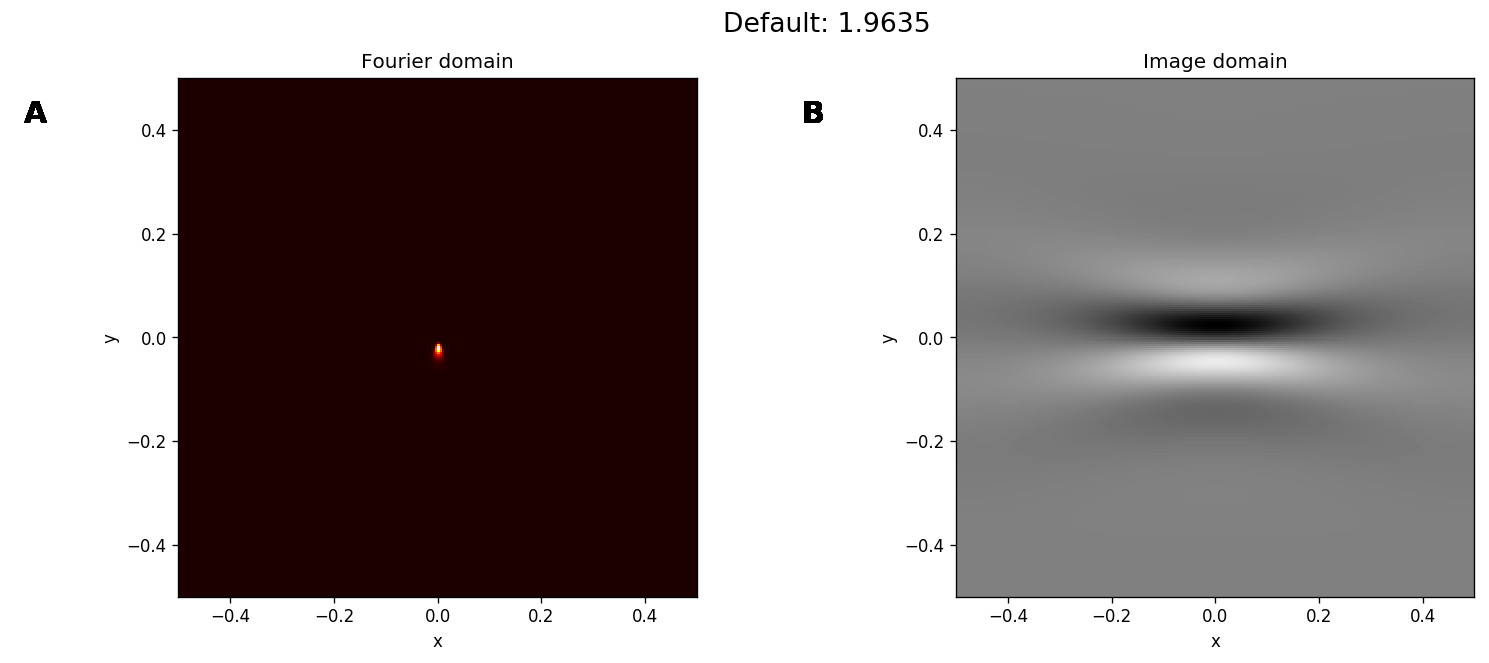
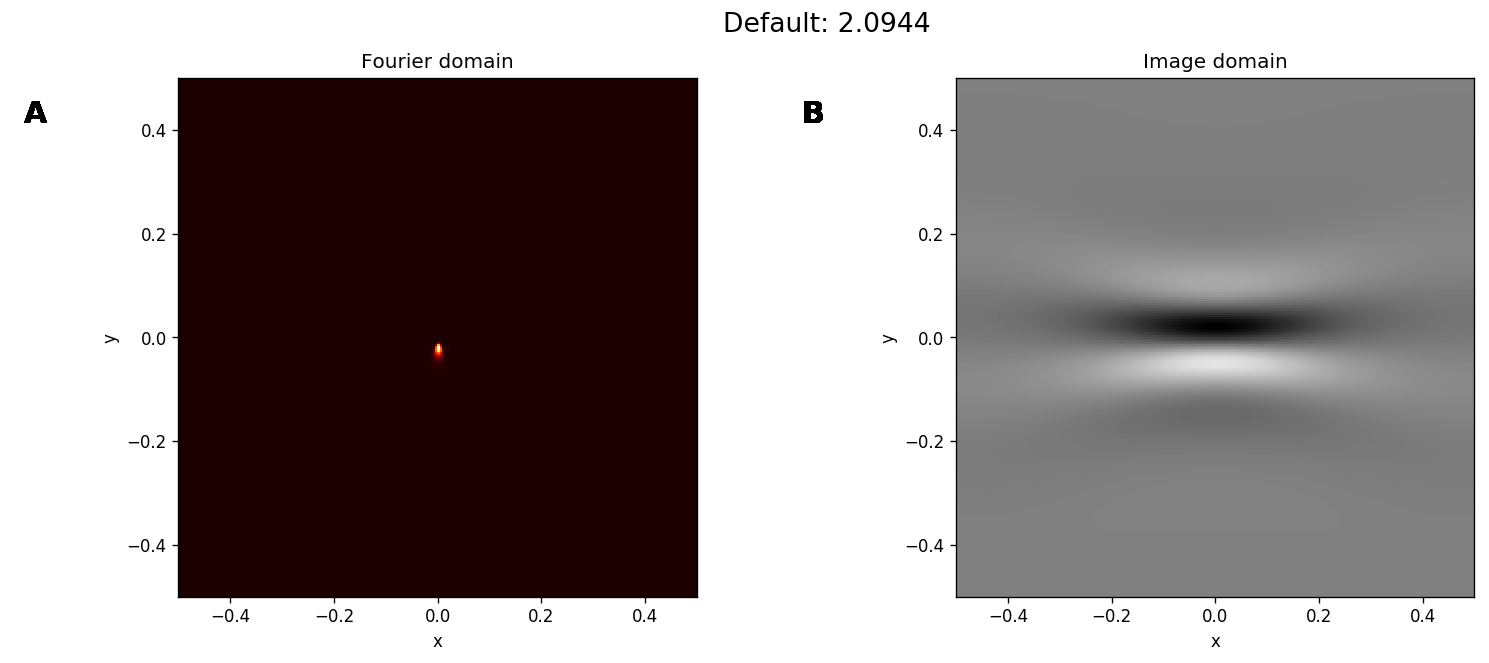
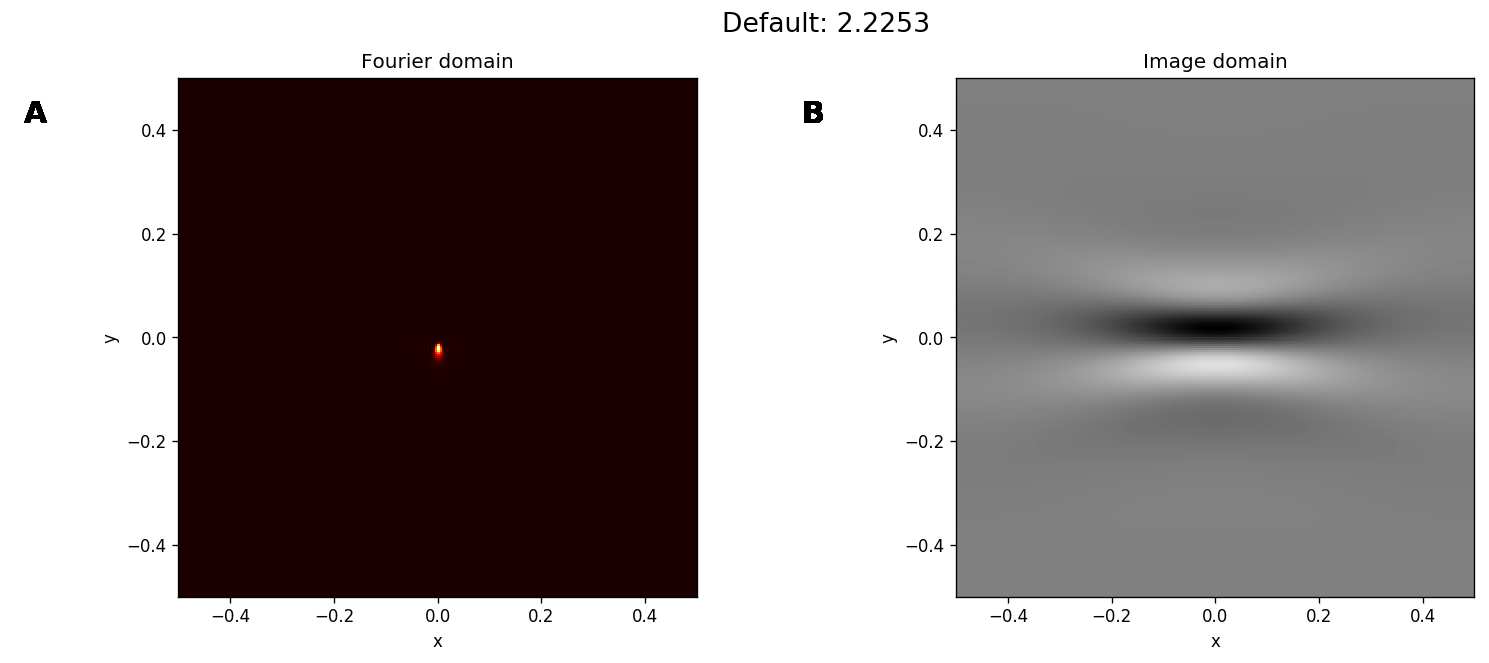
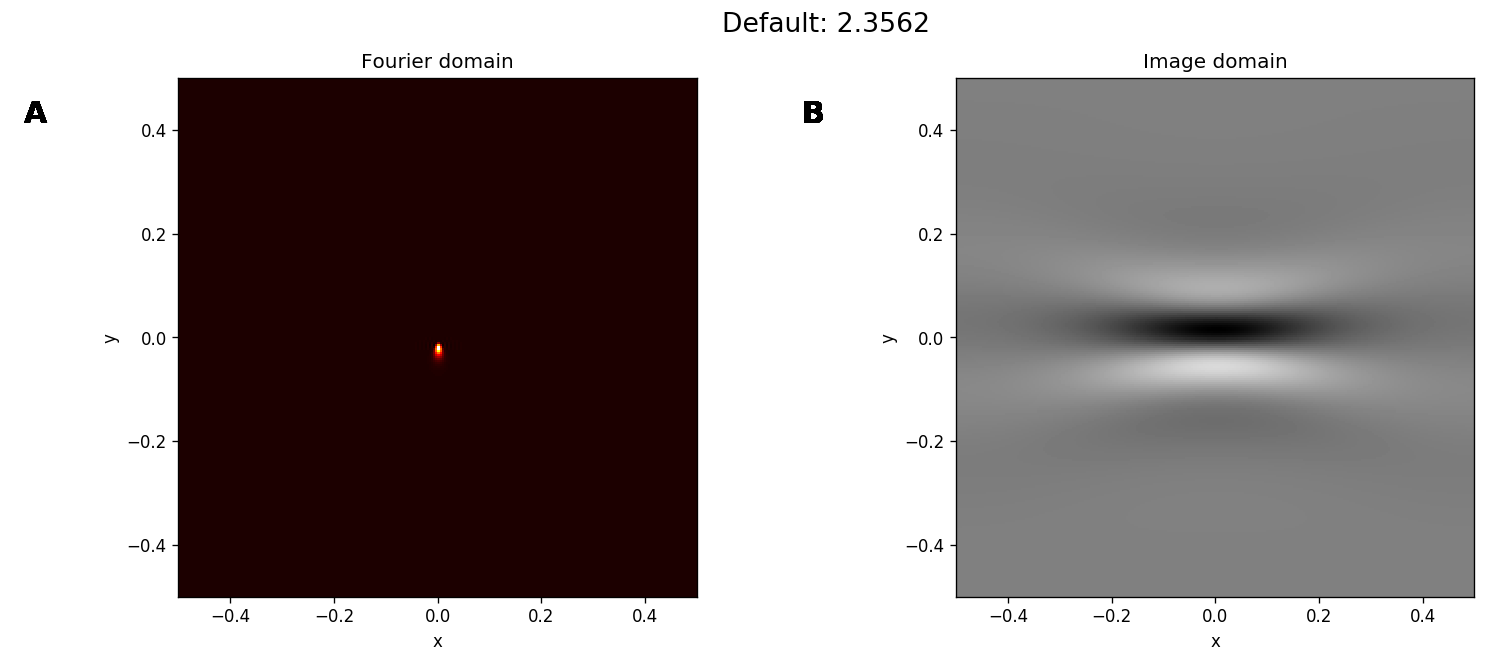
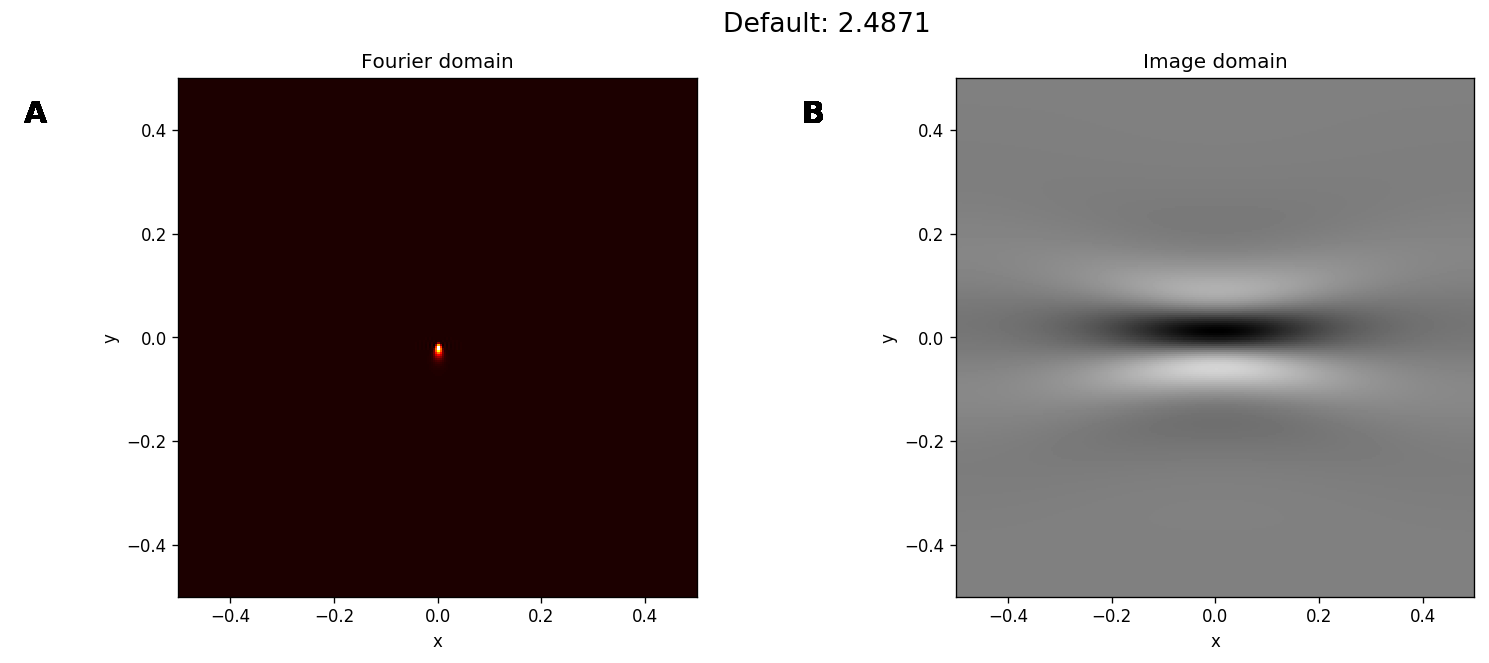
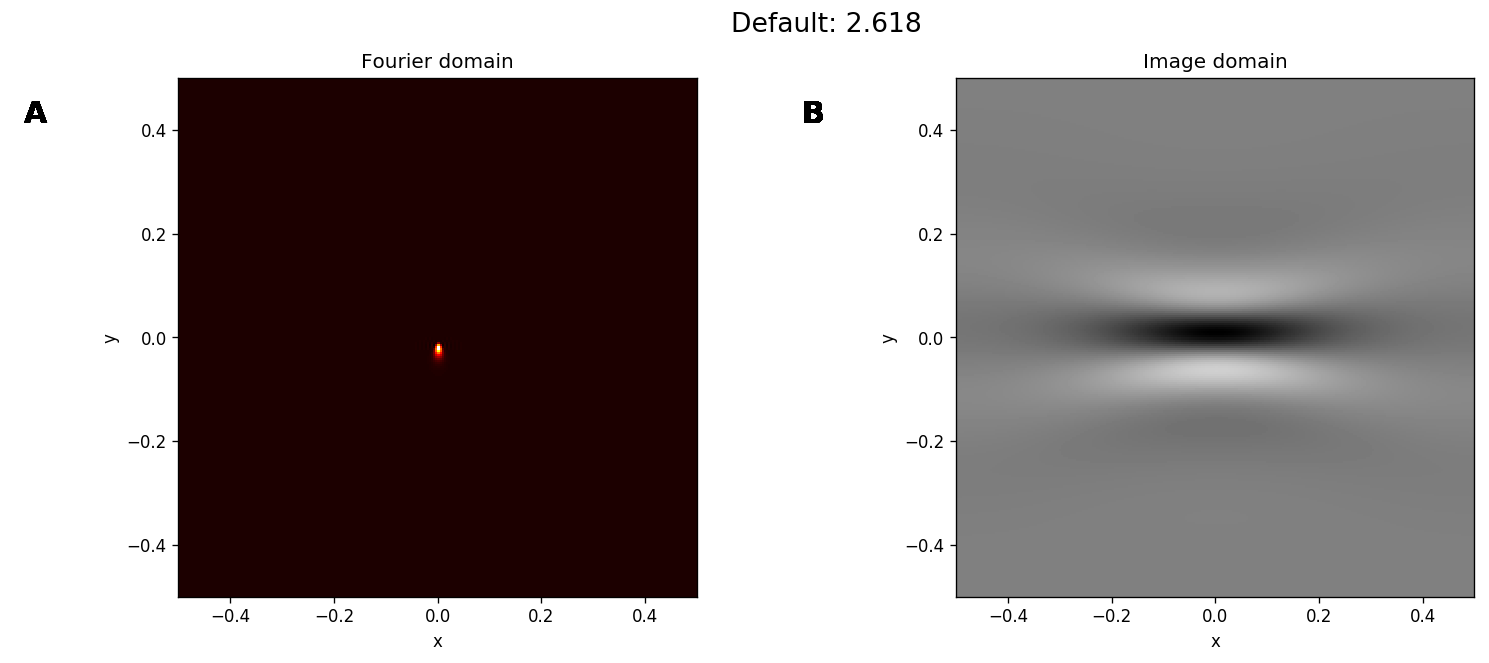
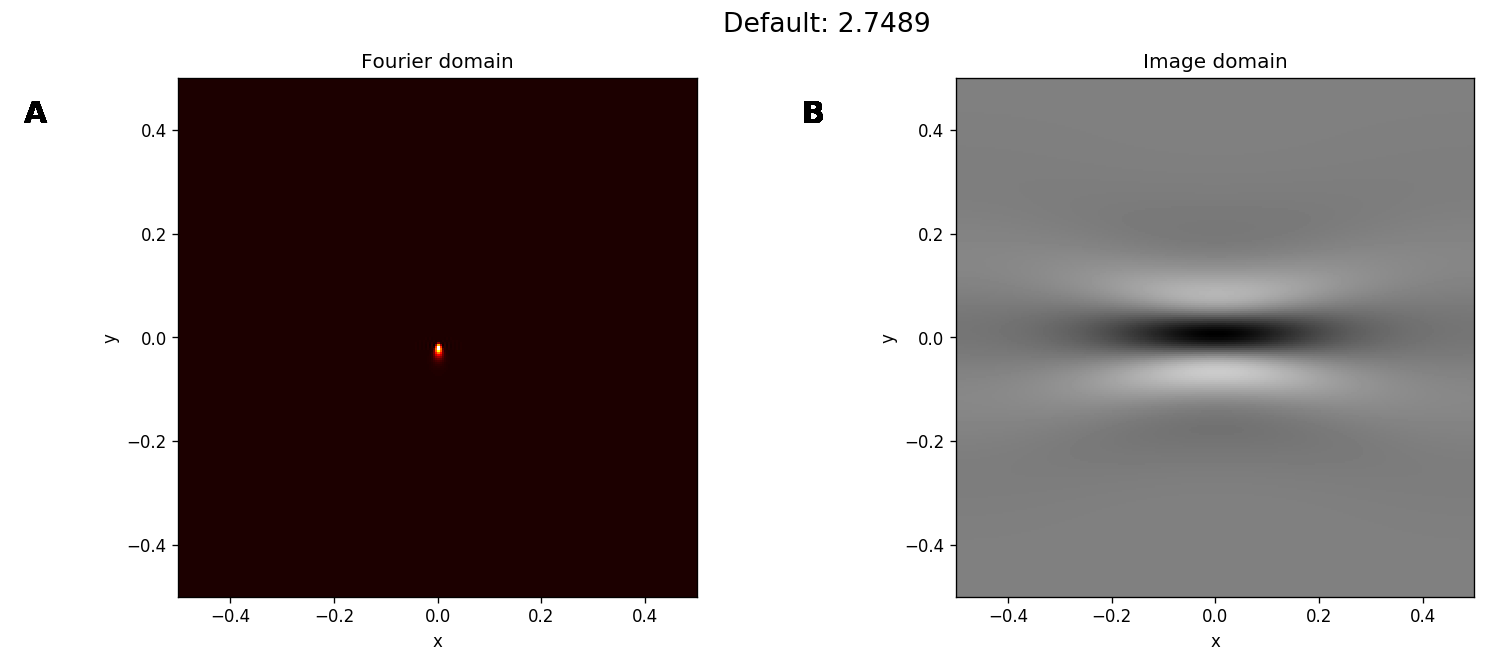
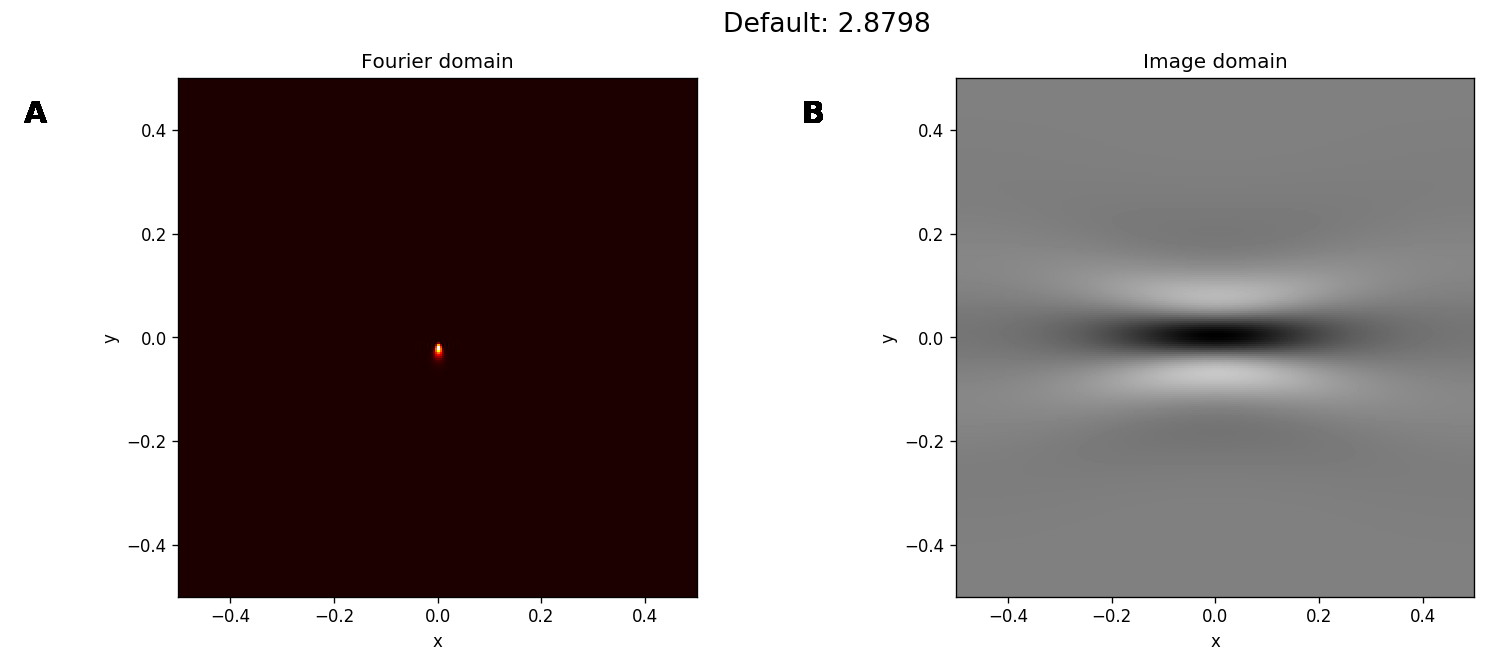
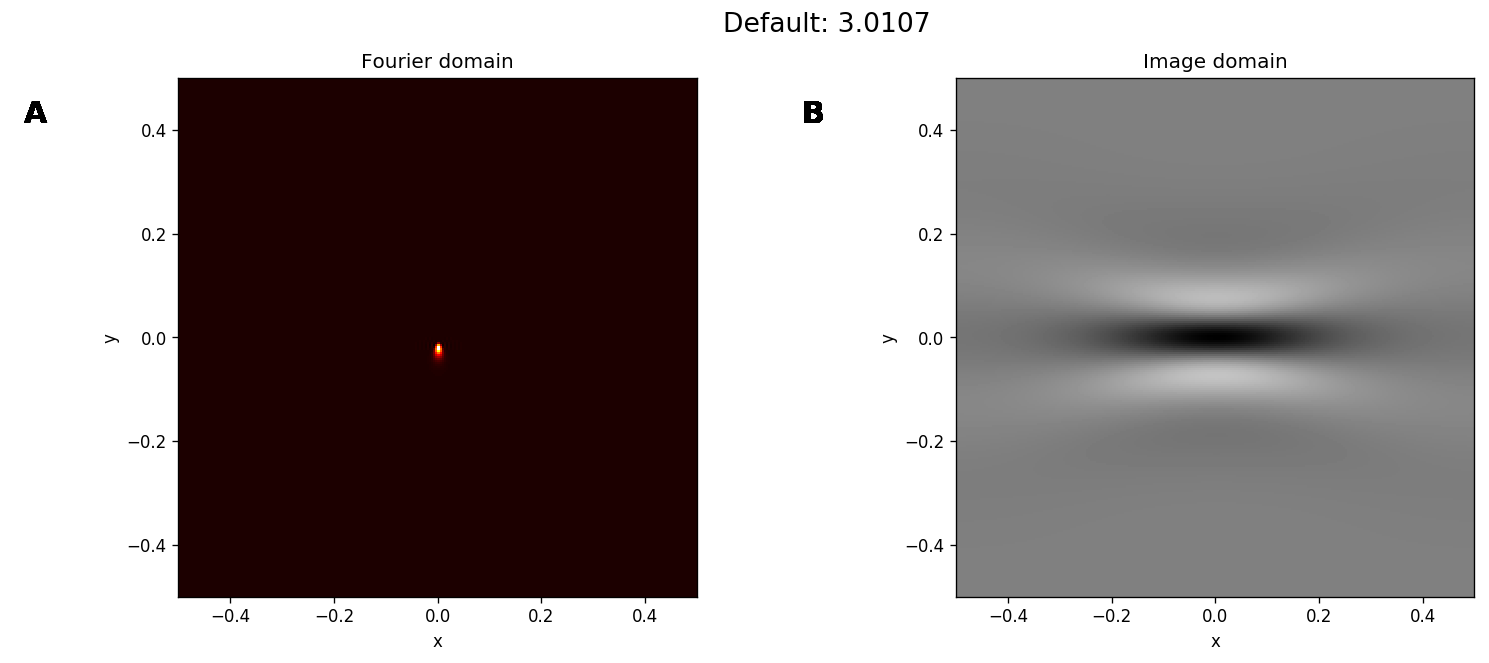

In [14]:
lg_explore(param_name='phase', 
           param_range=np.linspace(0, np.pi, 24, endpoint=False), angle=True)

:Layout
   .Fourier_domain.I :HoloMap   [Default]
      :Image   [x,y]   (z)
   .Image_domain.I   :HoloMap   [Default]
      :Image   [x,y]   (z)
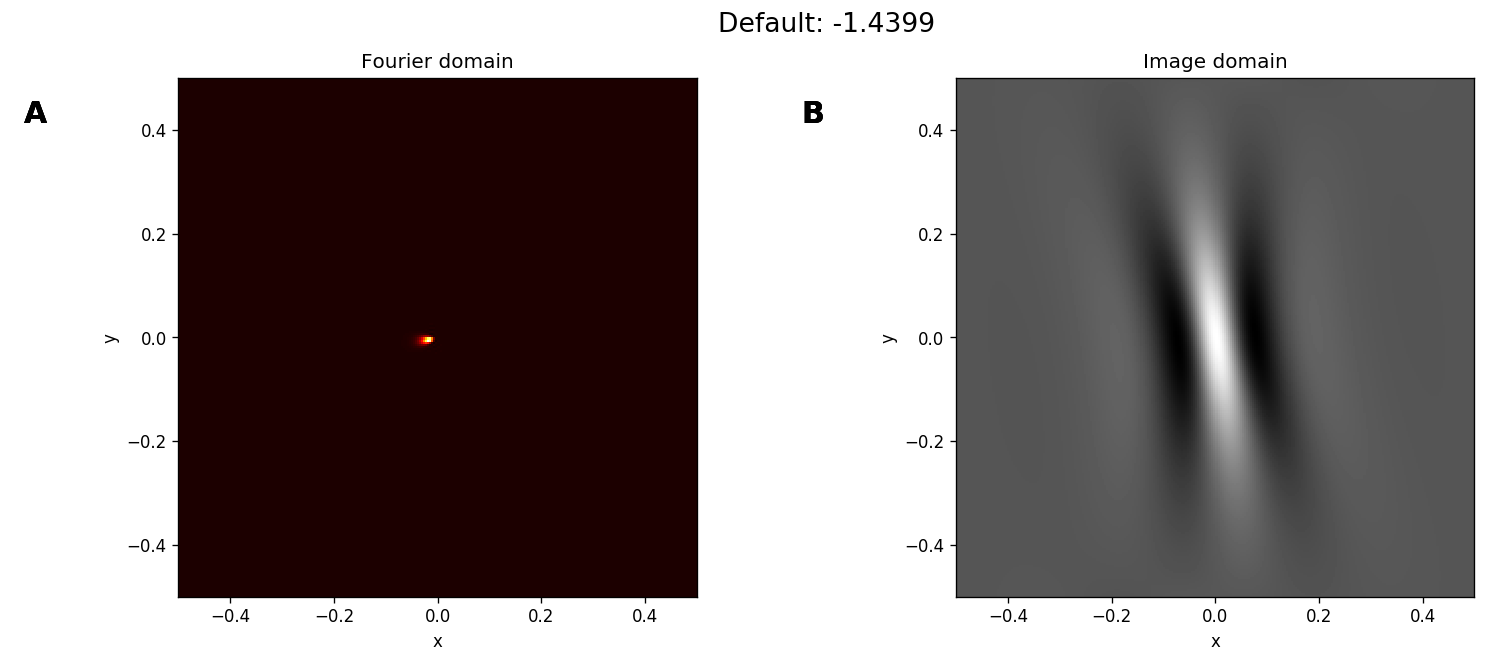
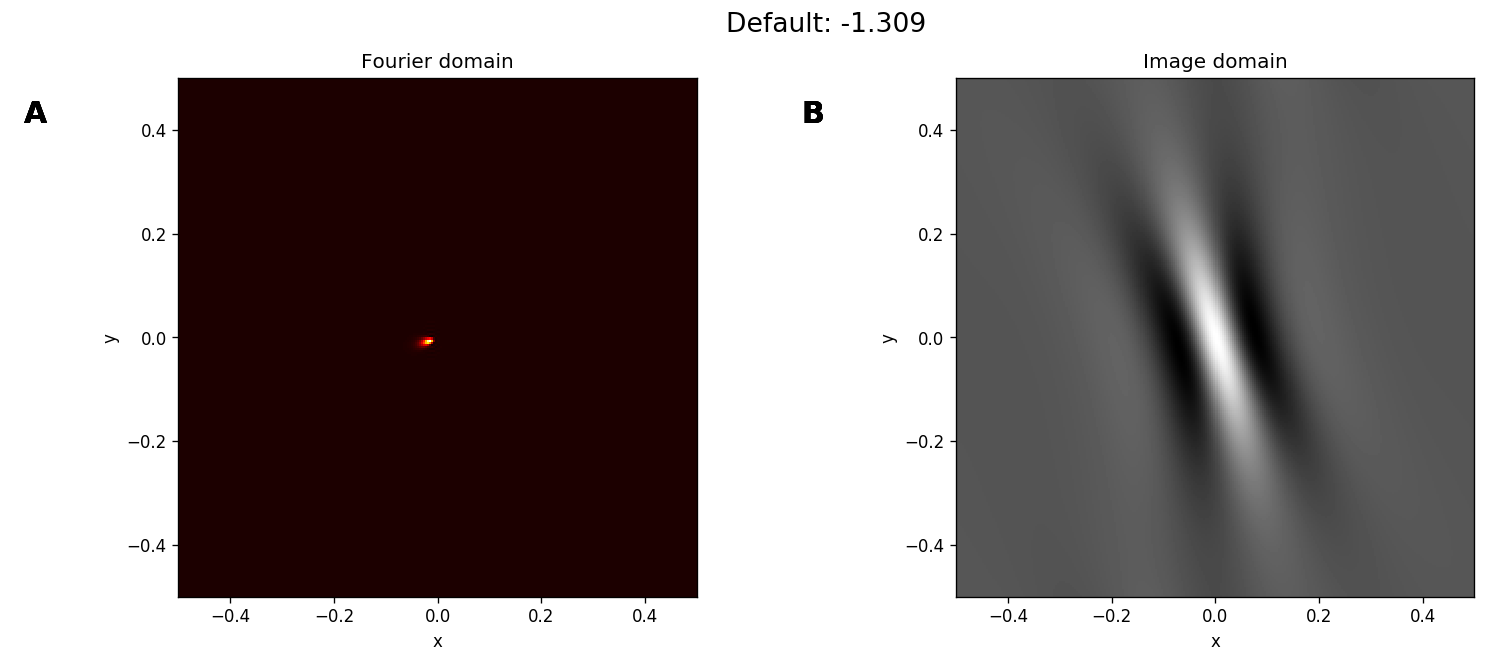
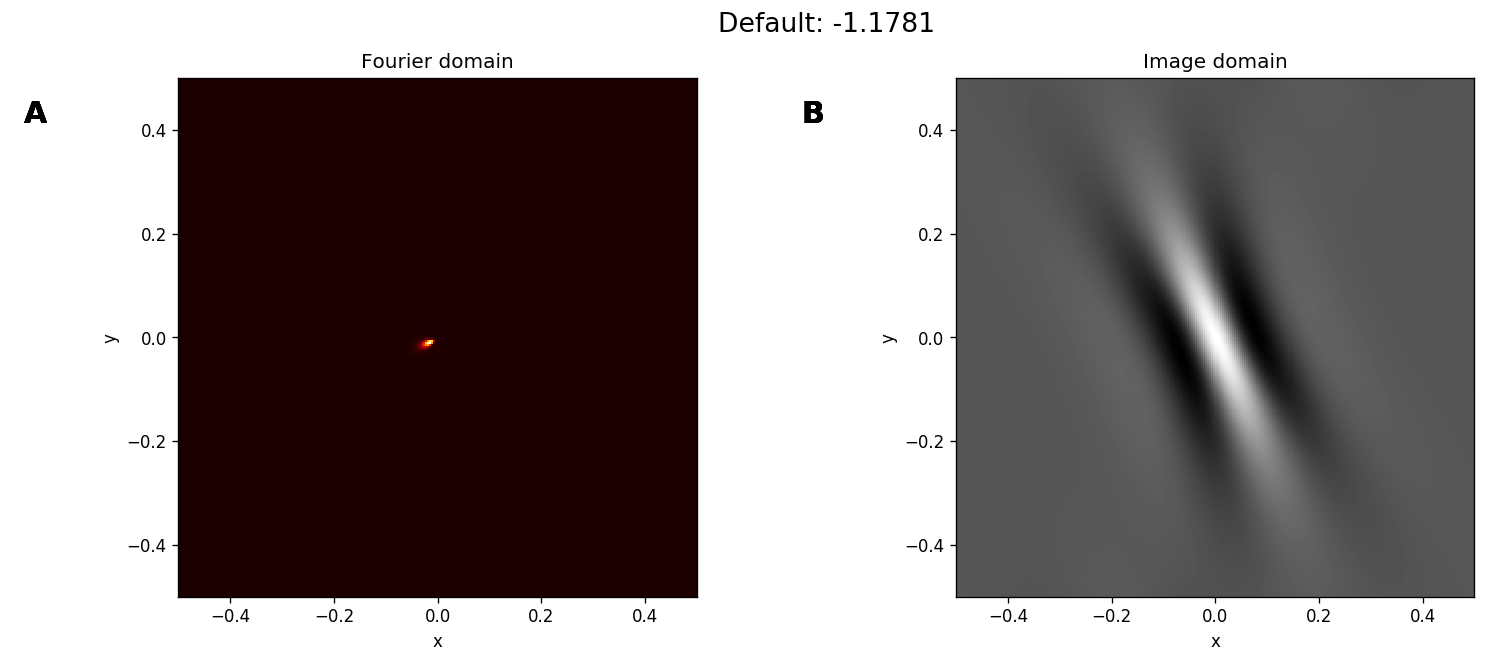
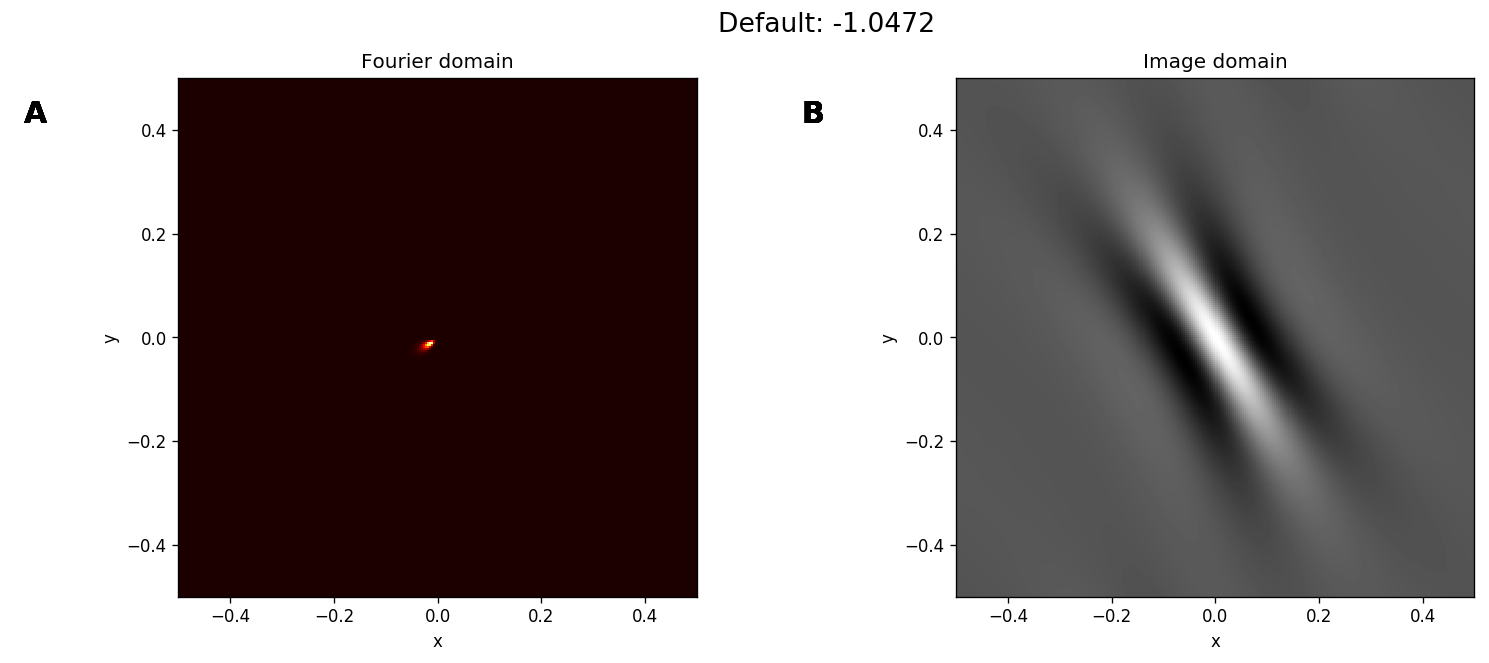
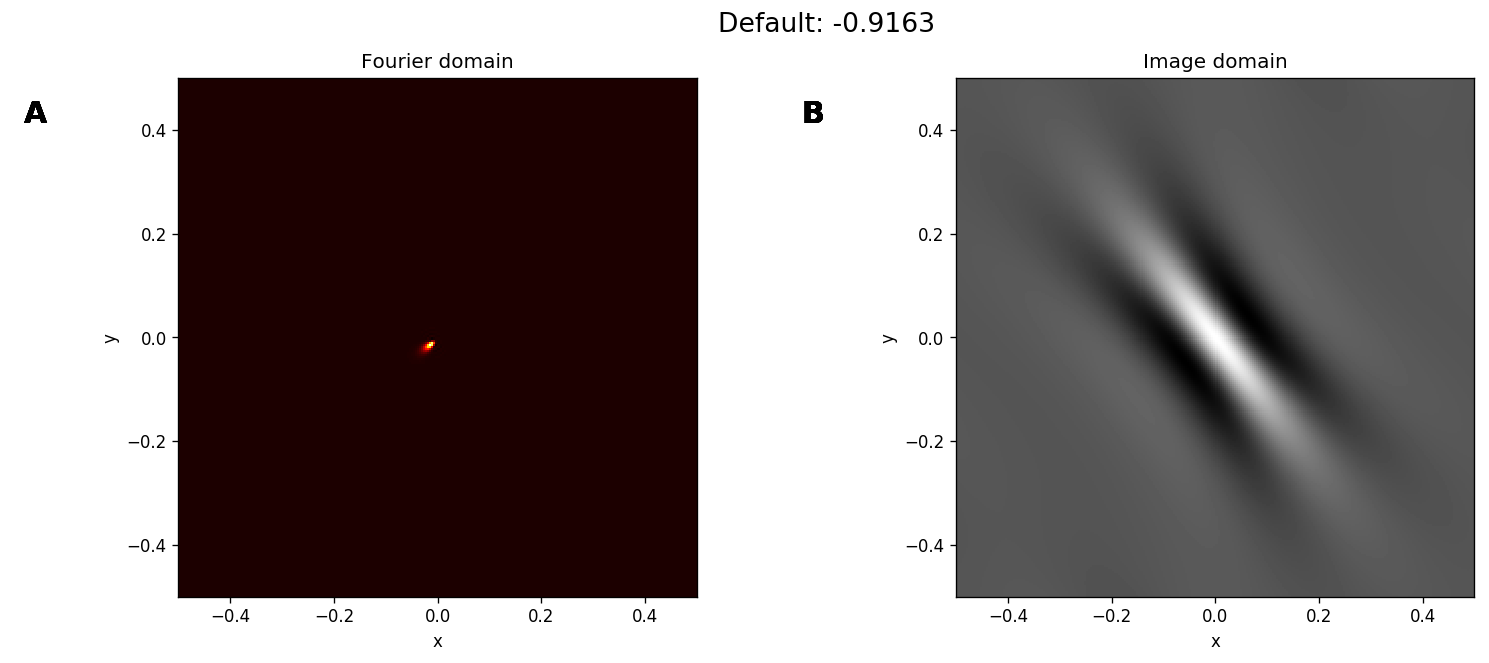
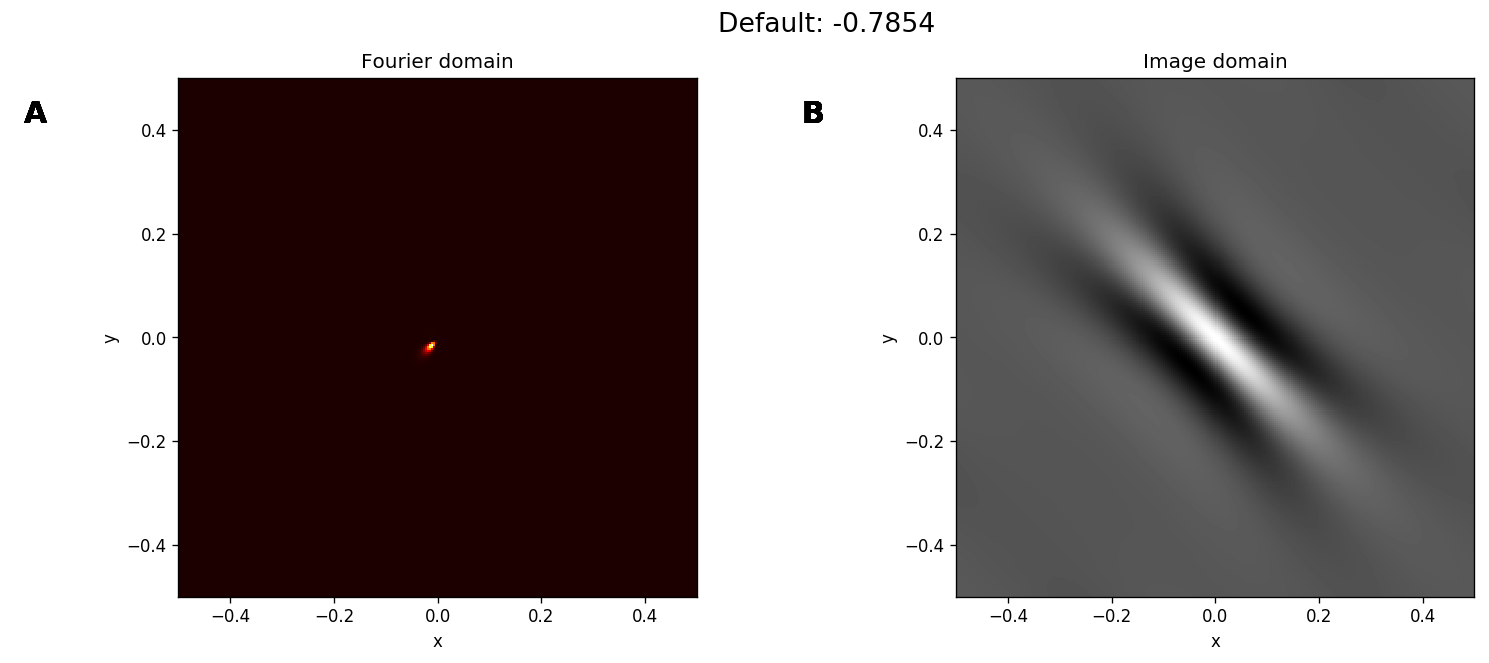
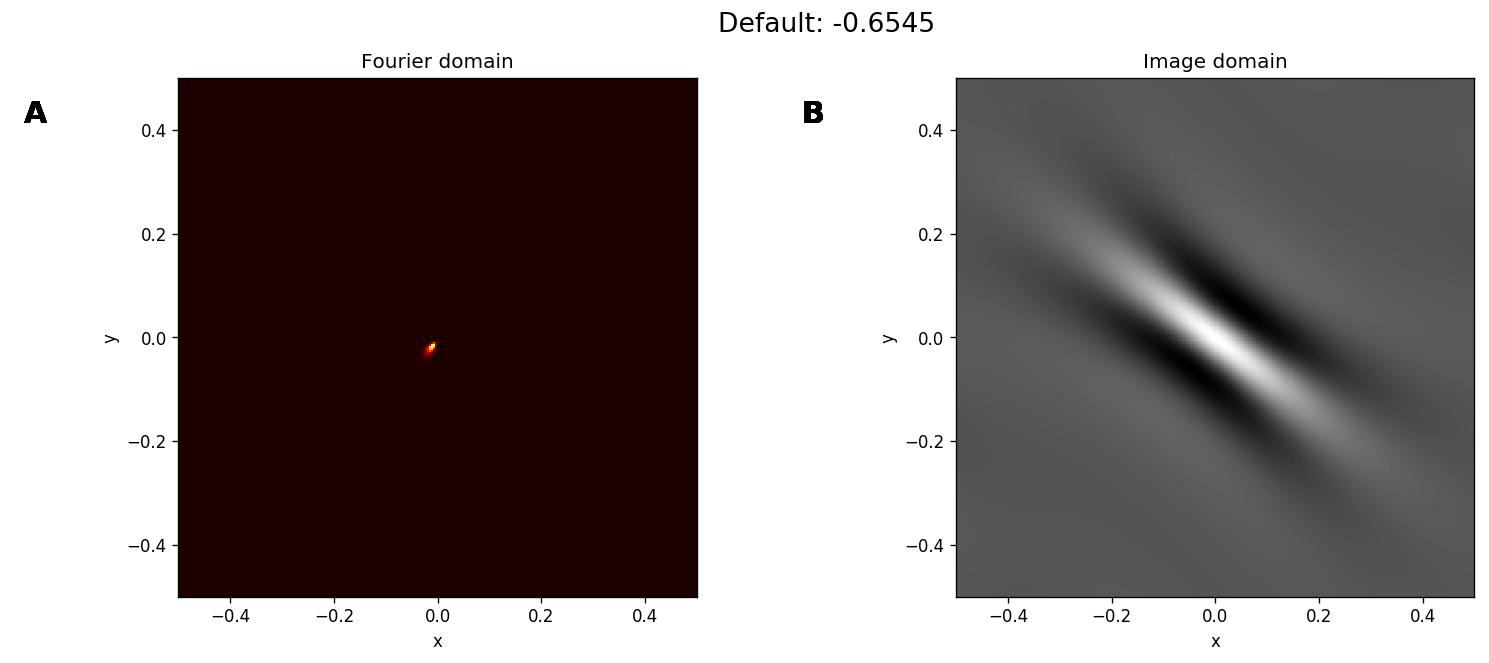
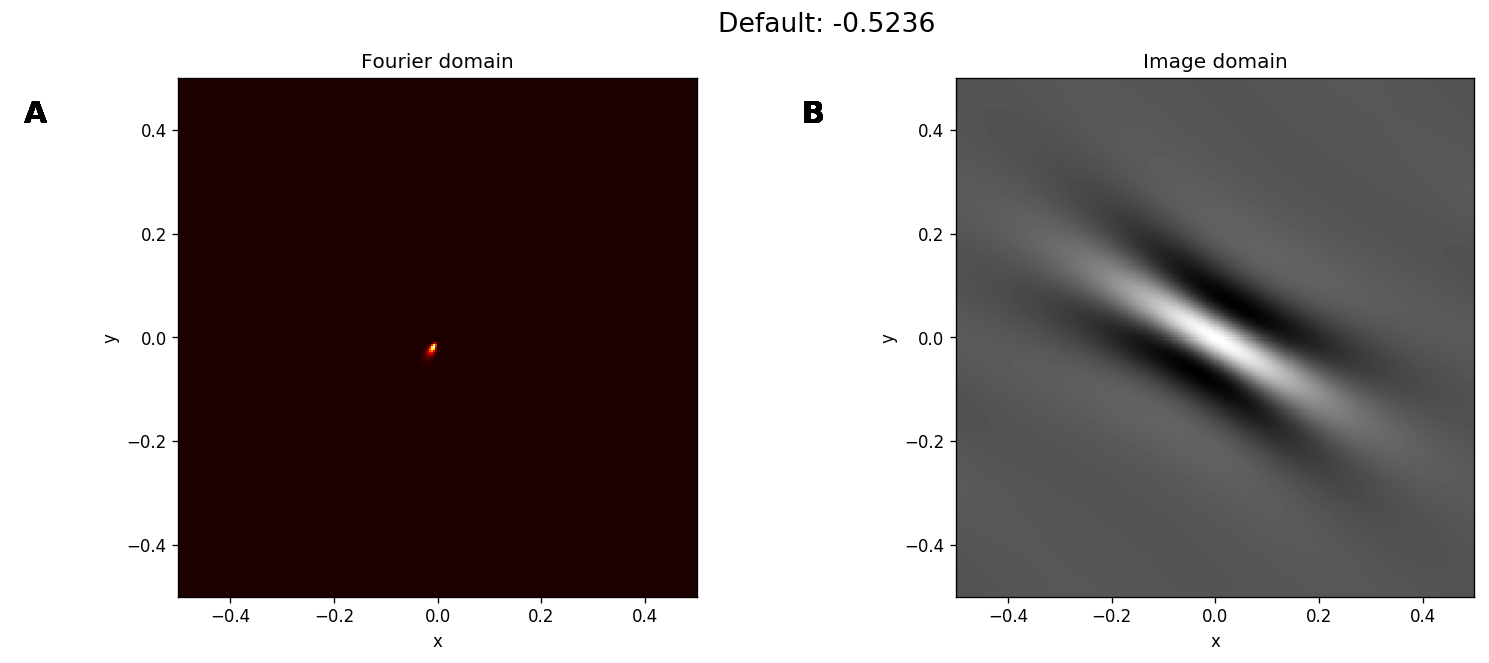
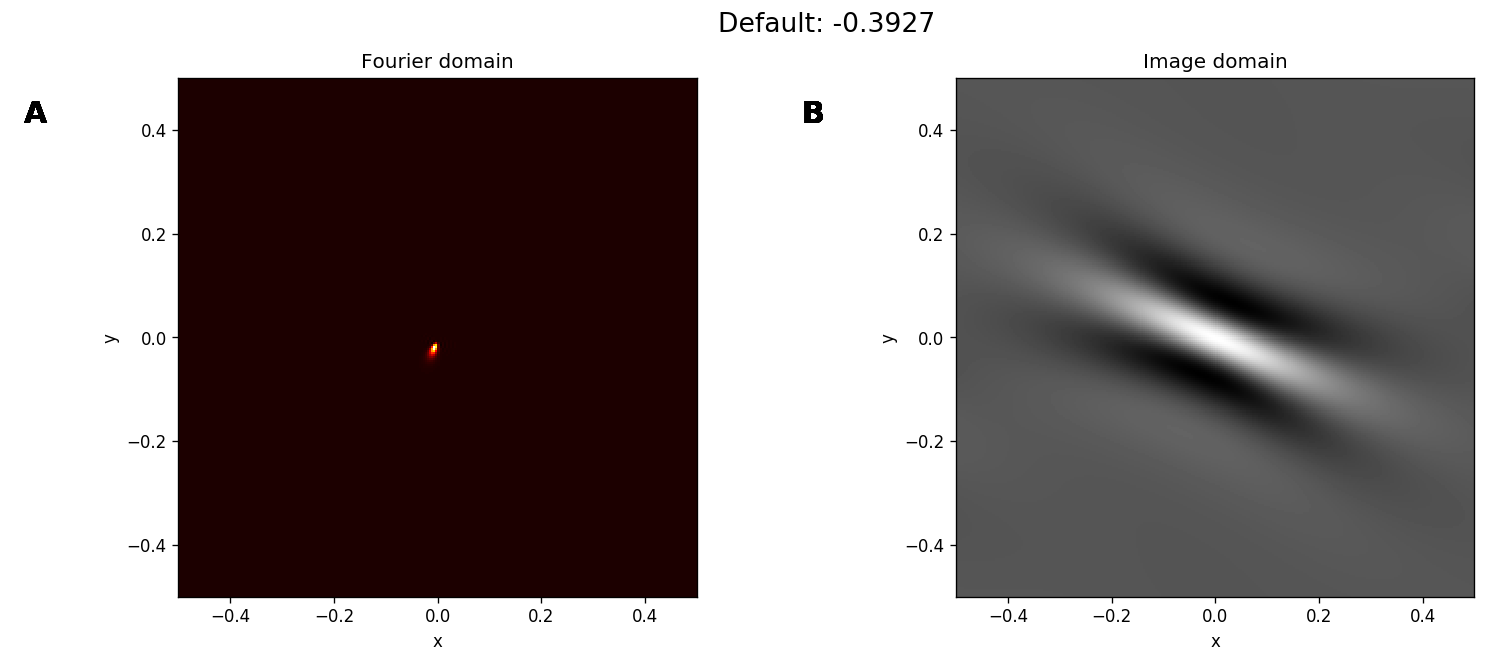
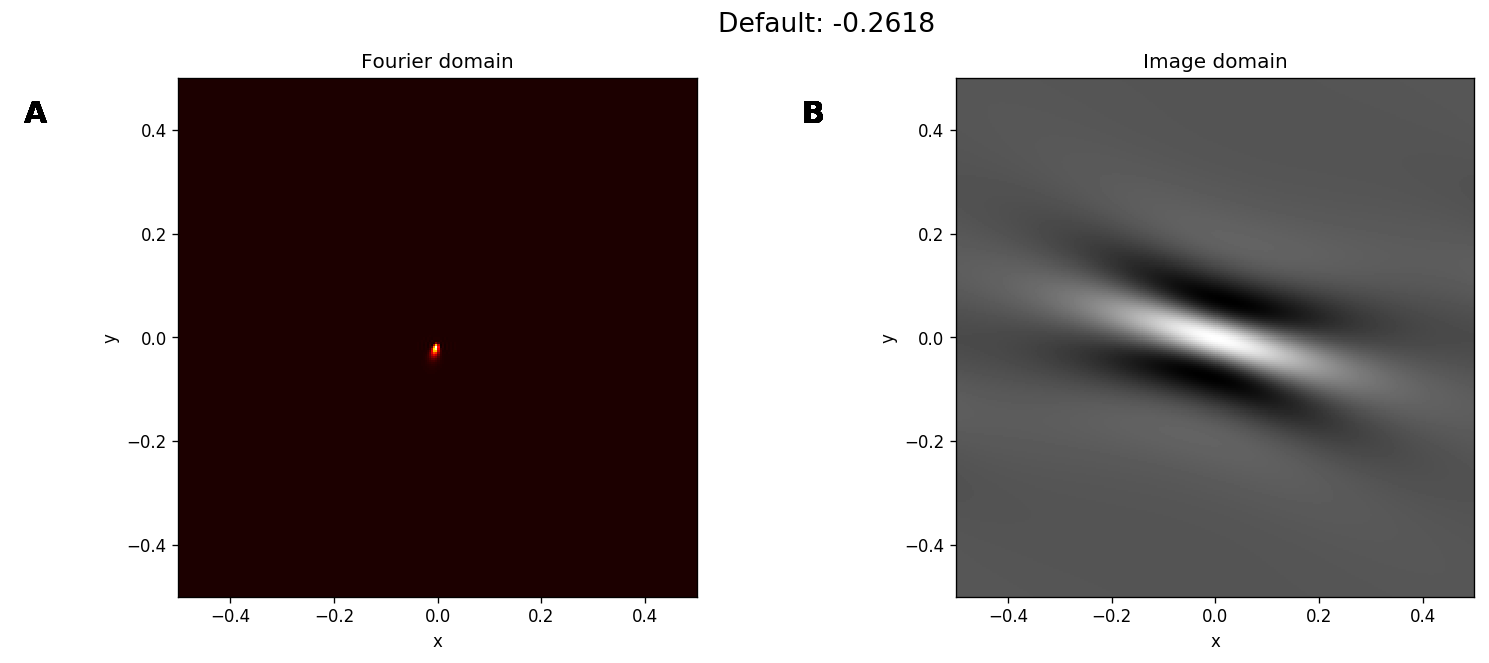
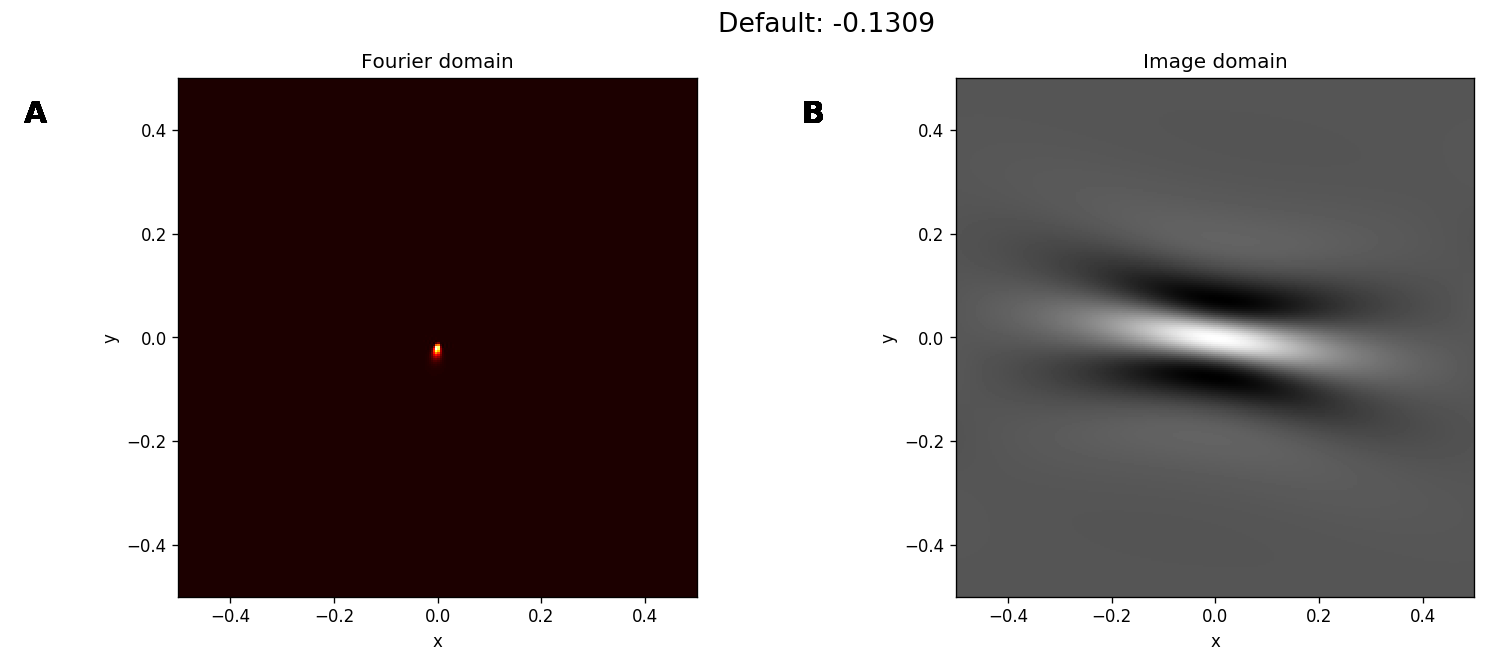
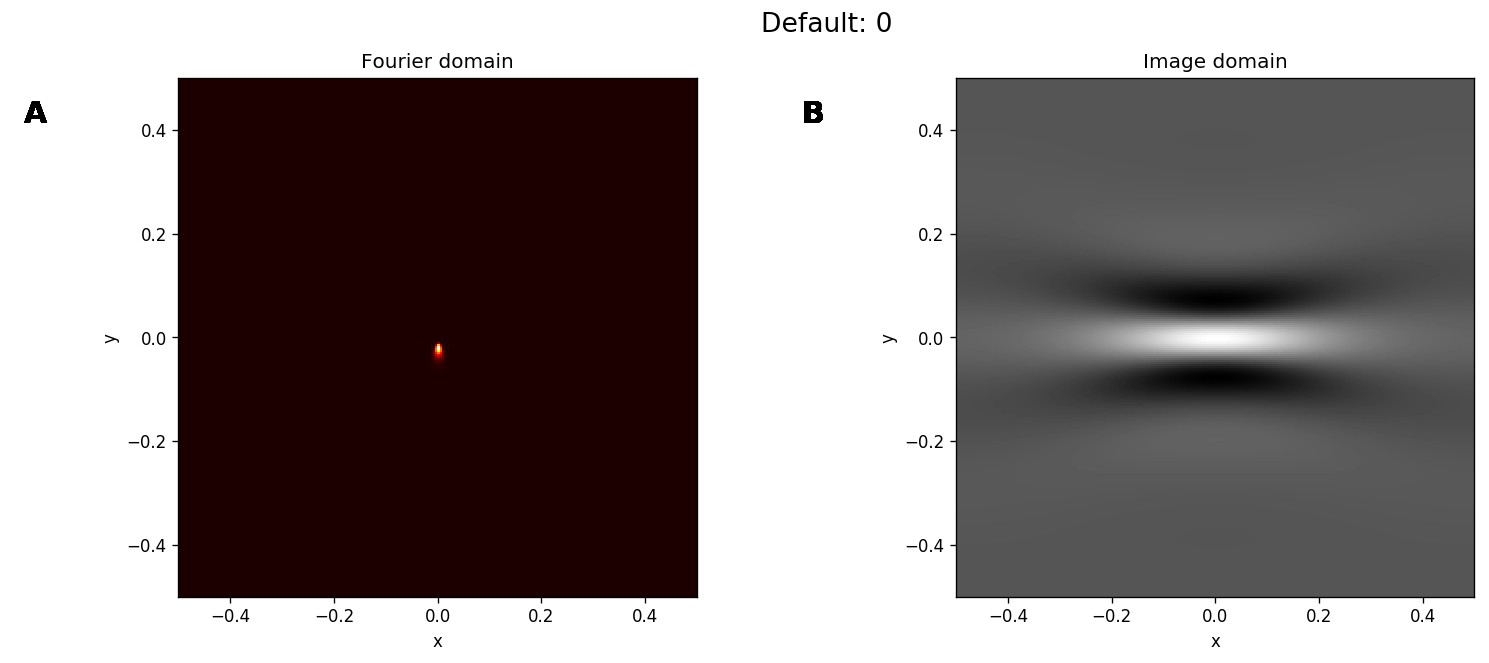
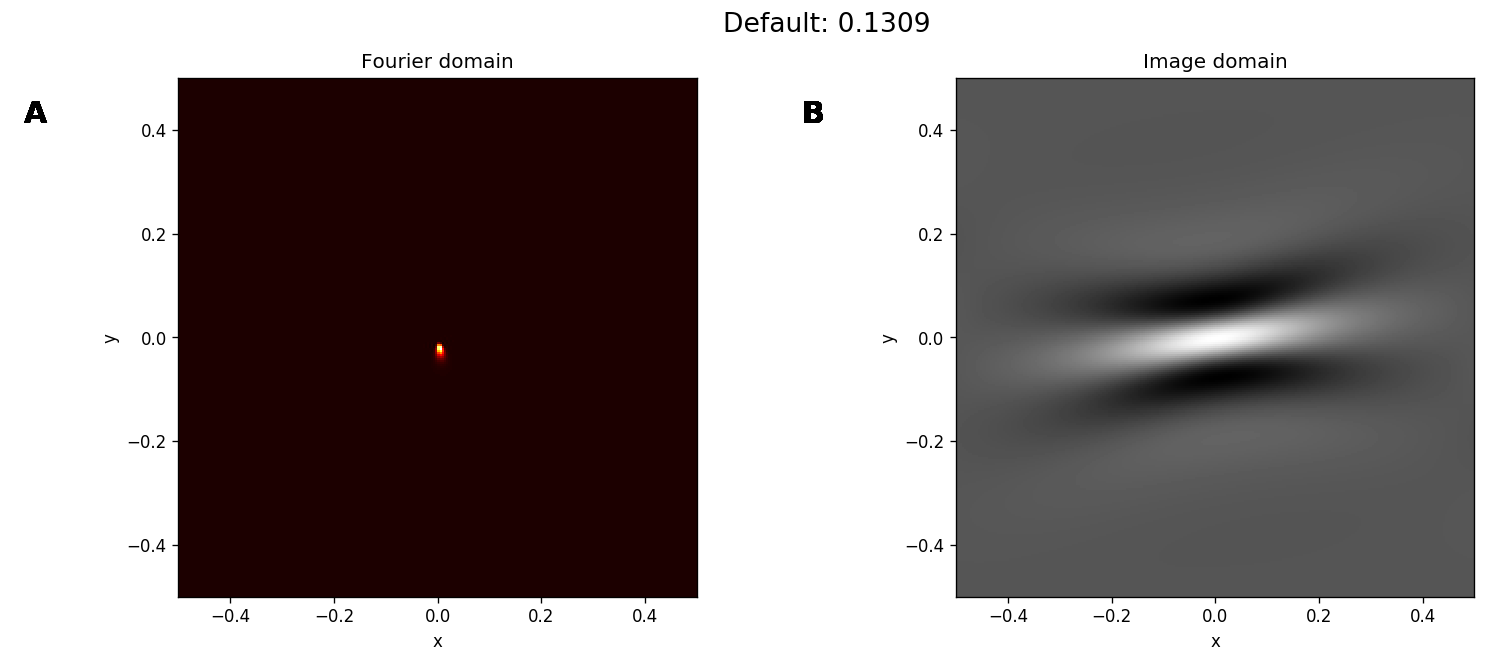
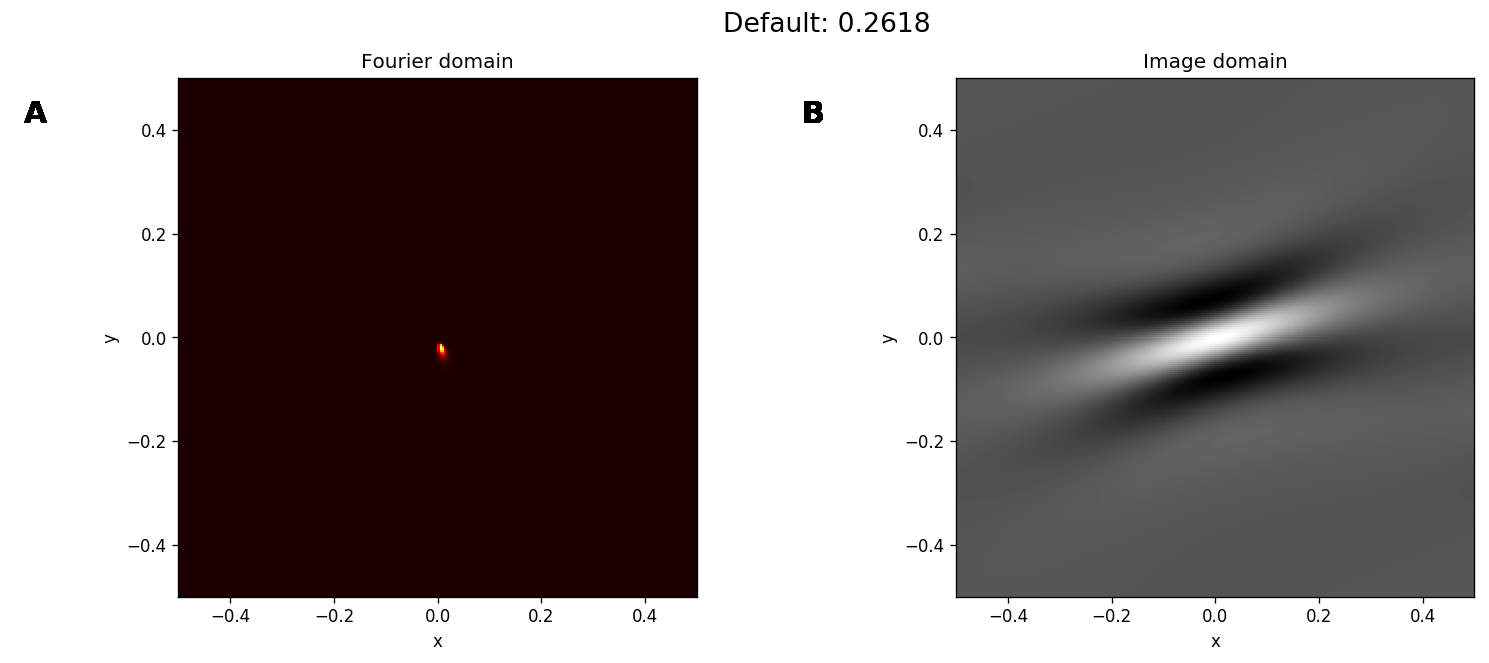
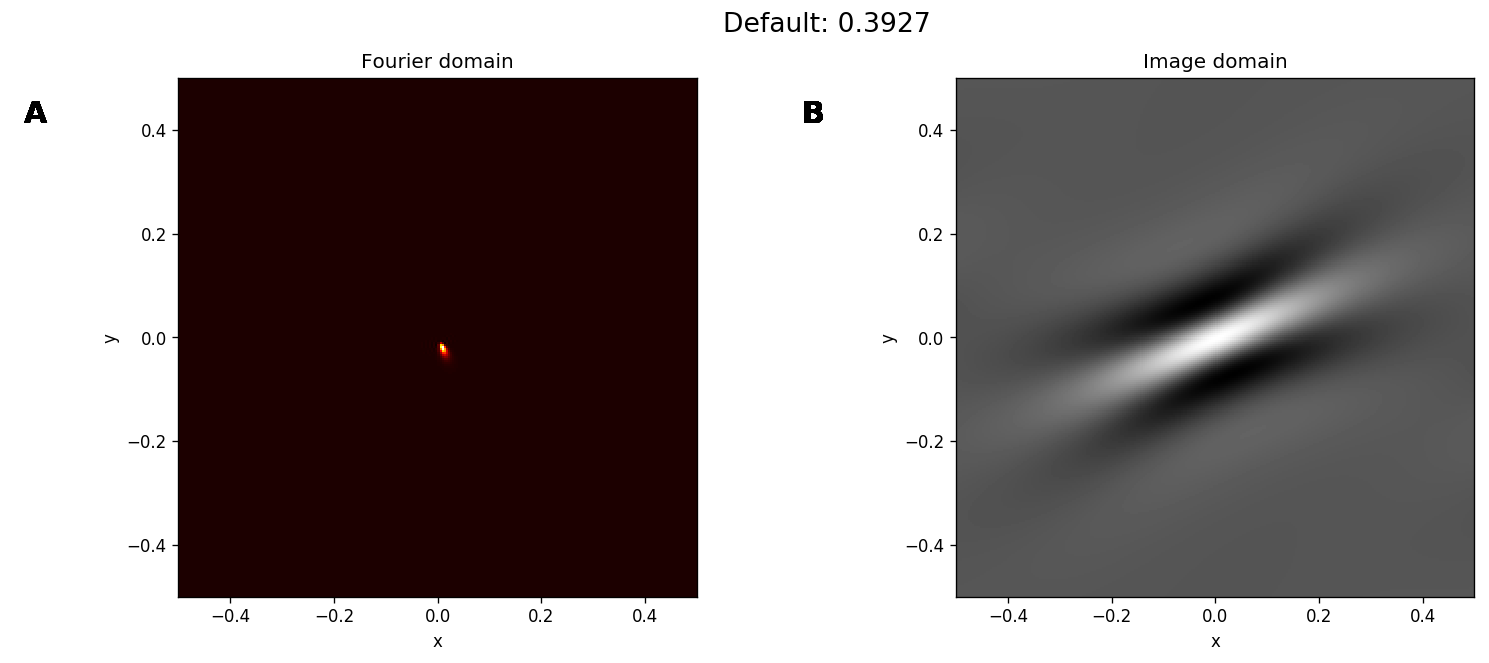
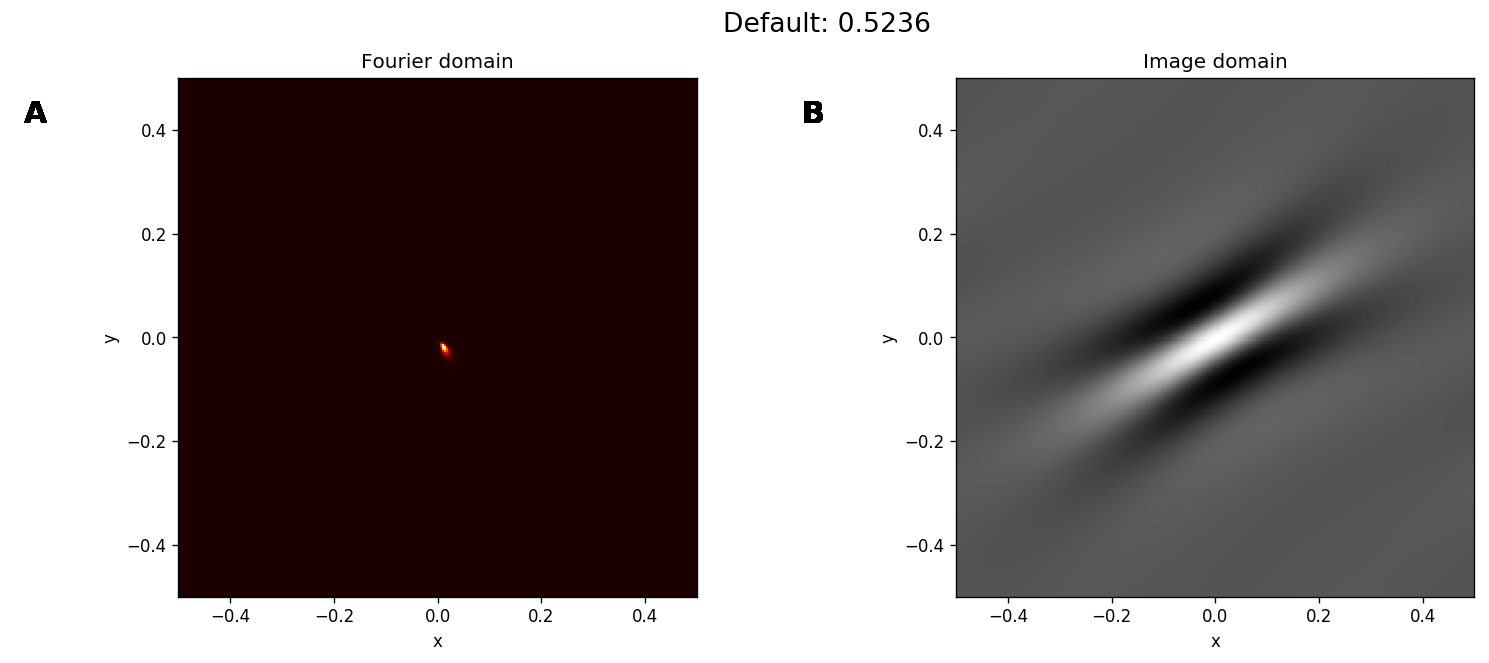
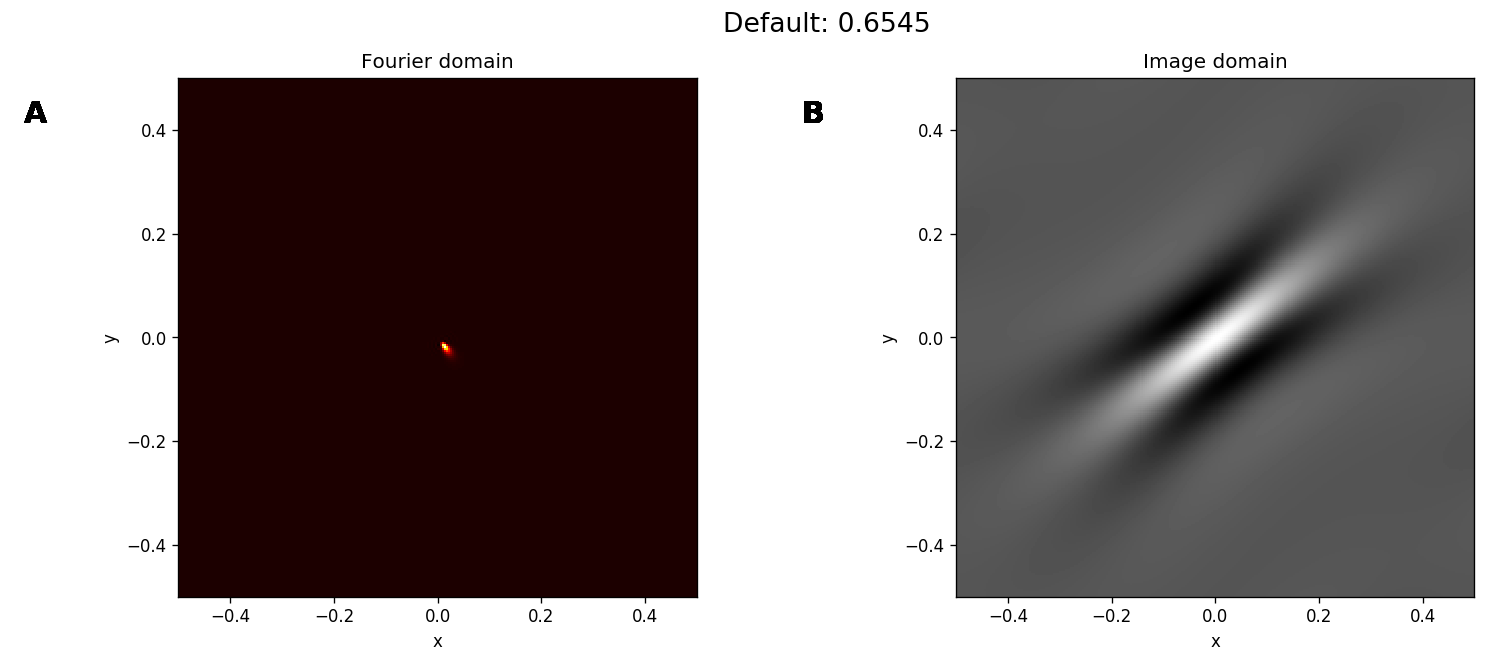
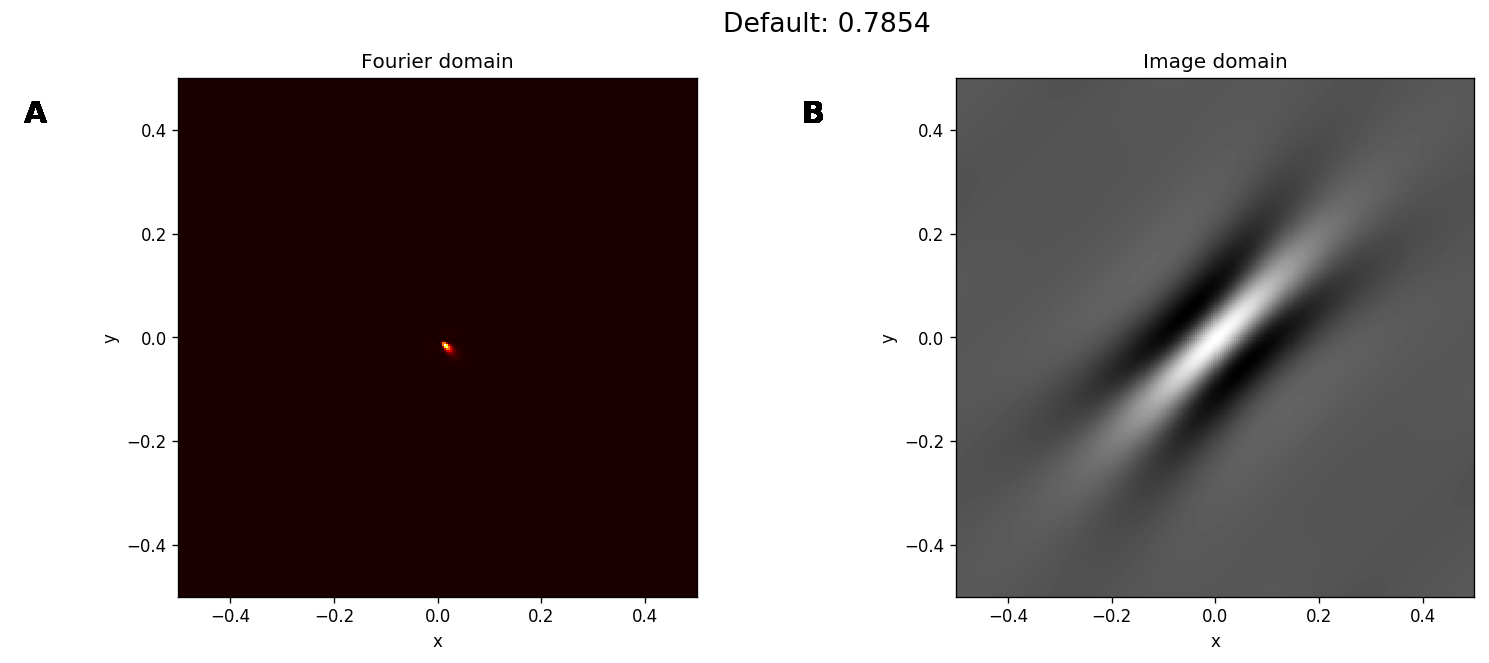
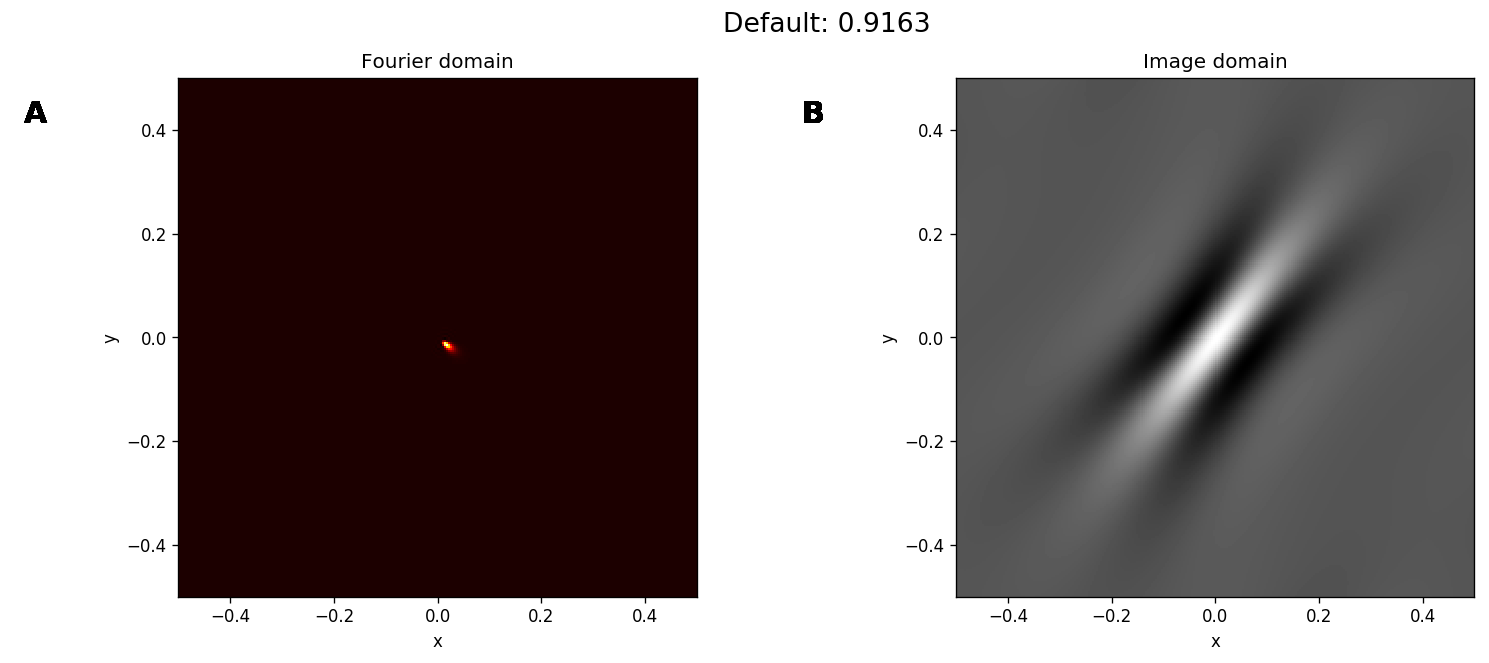
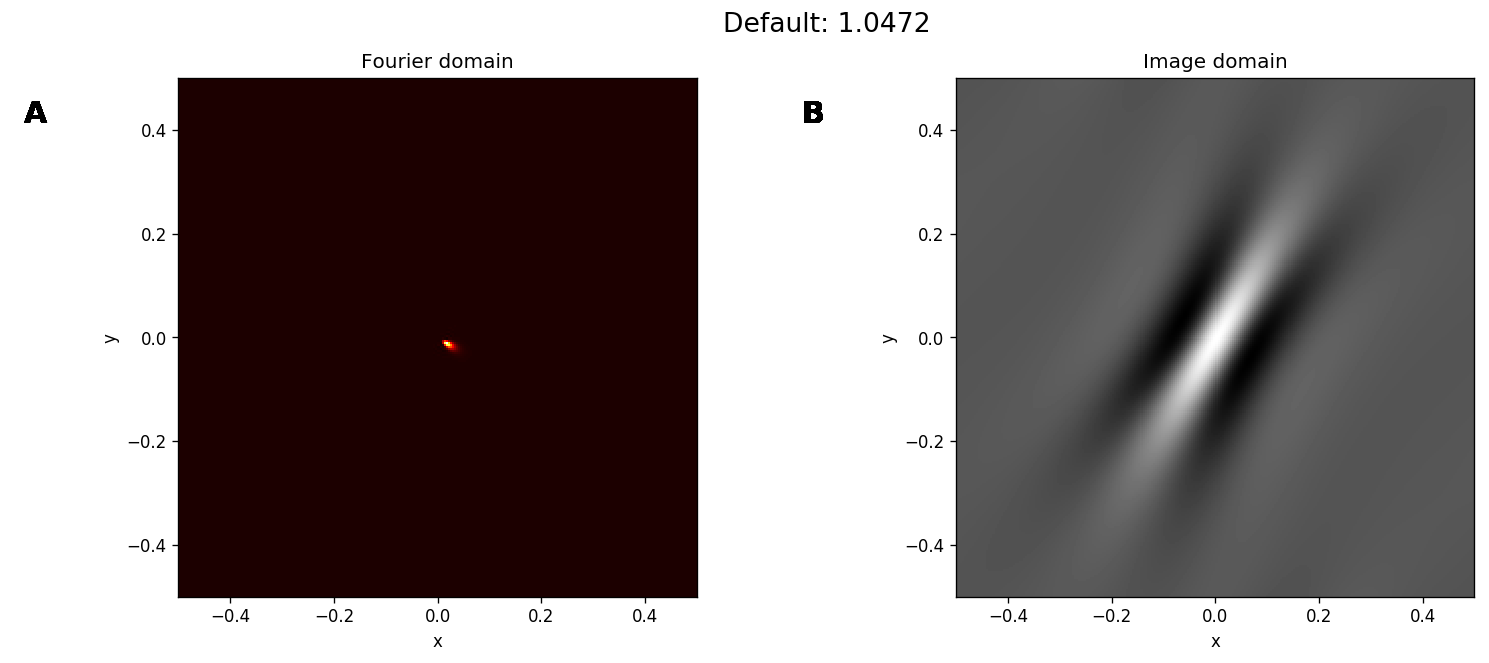
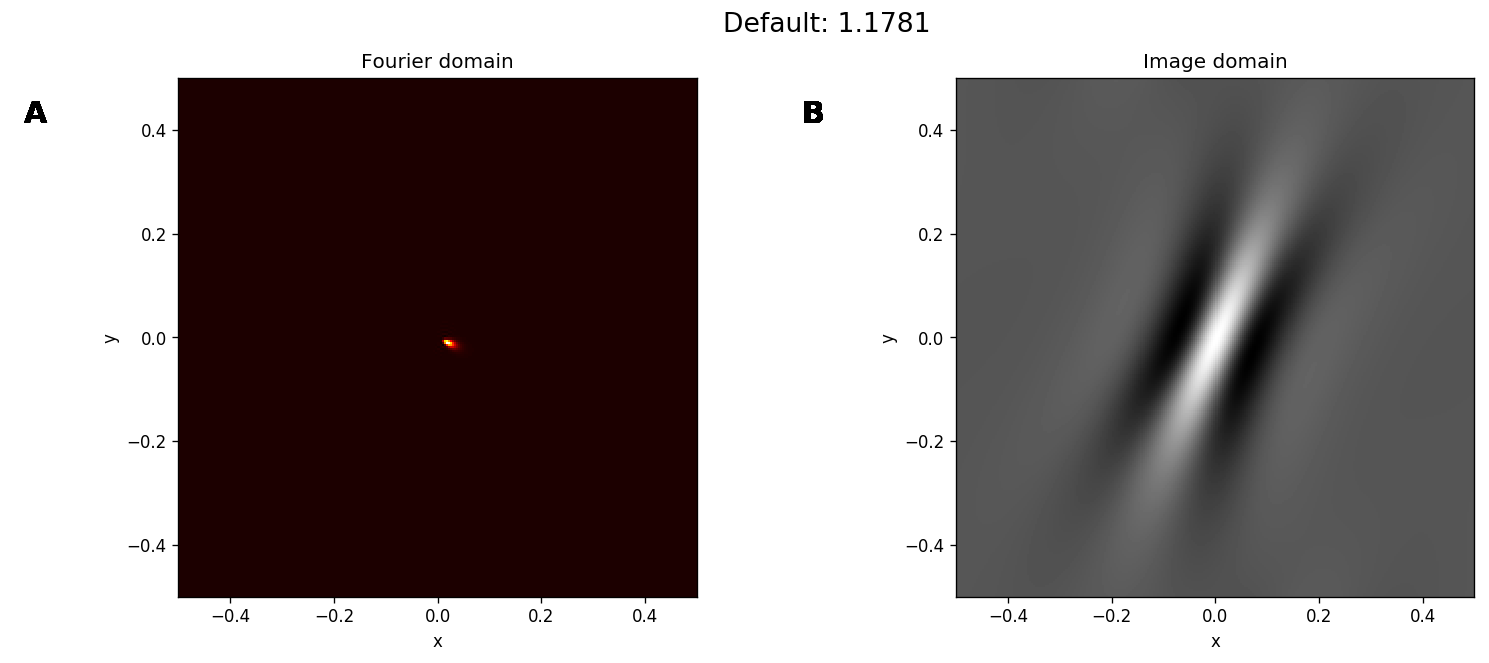
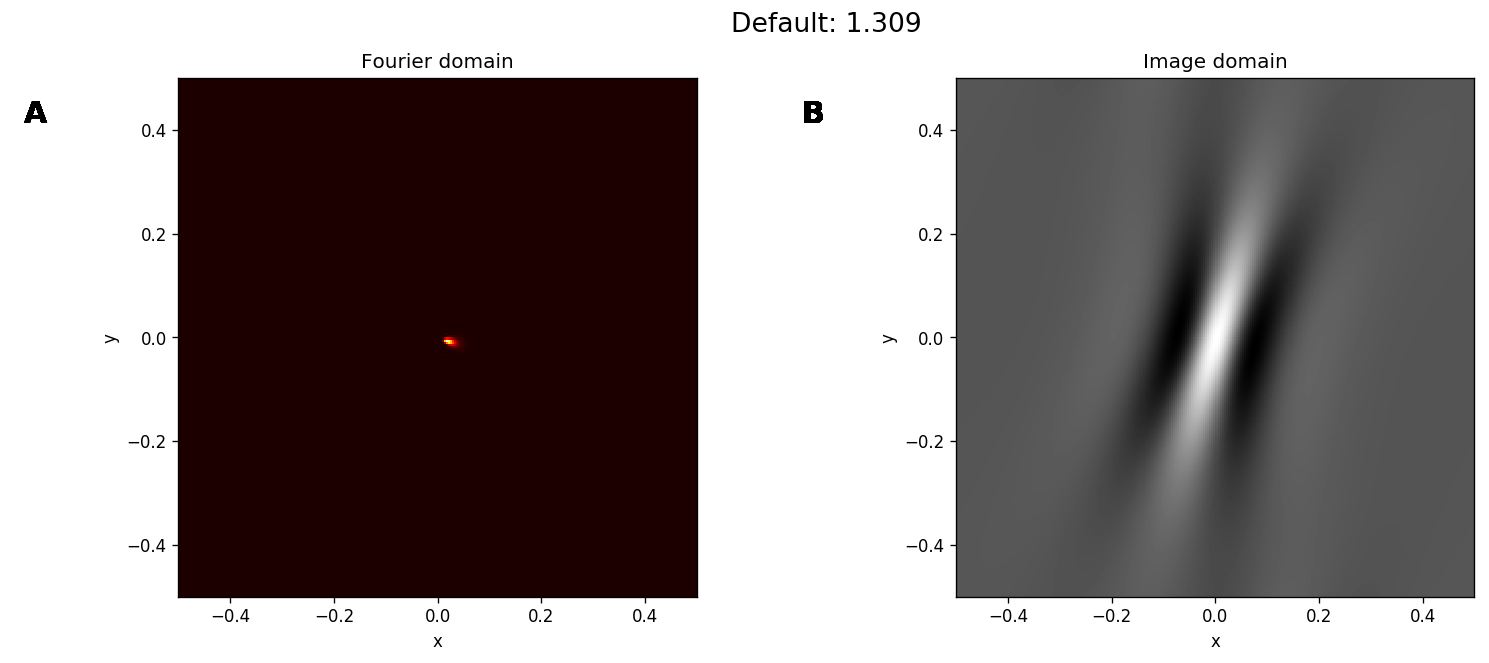
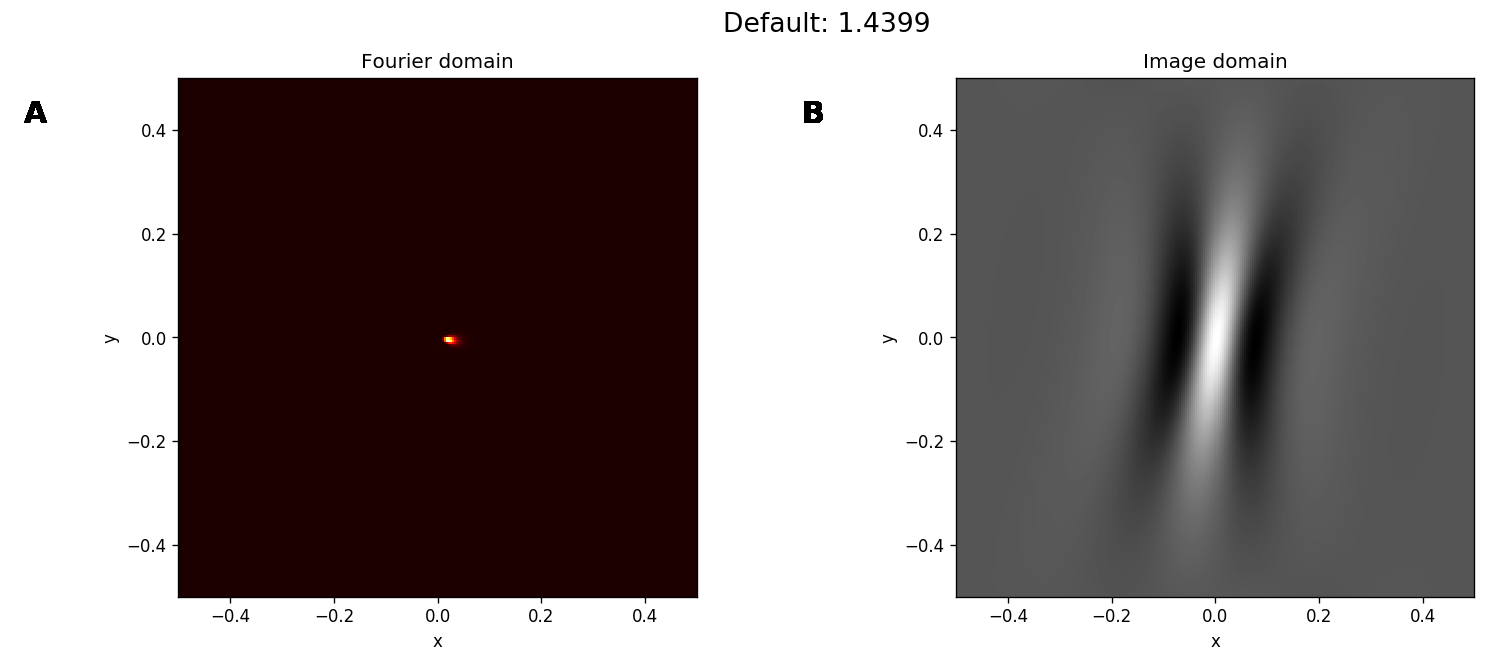
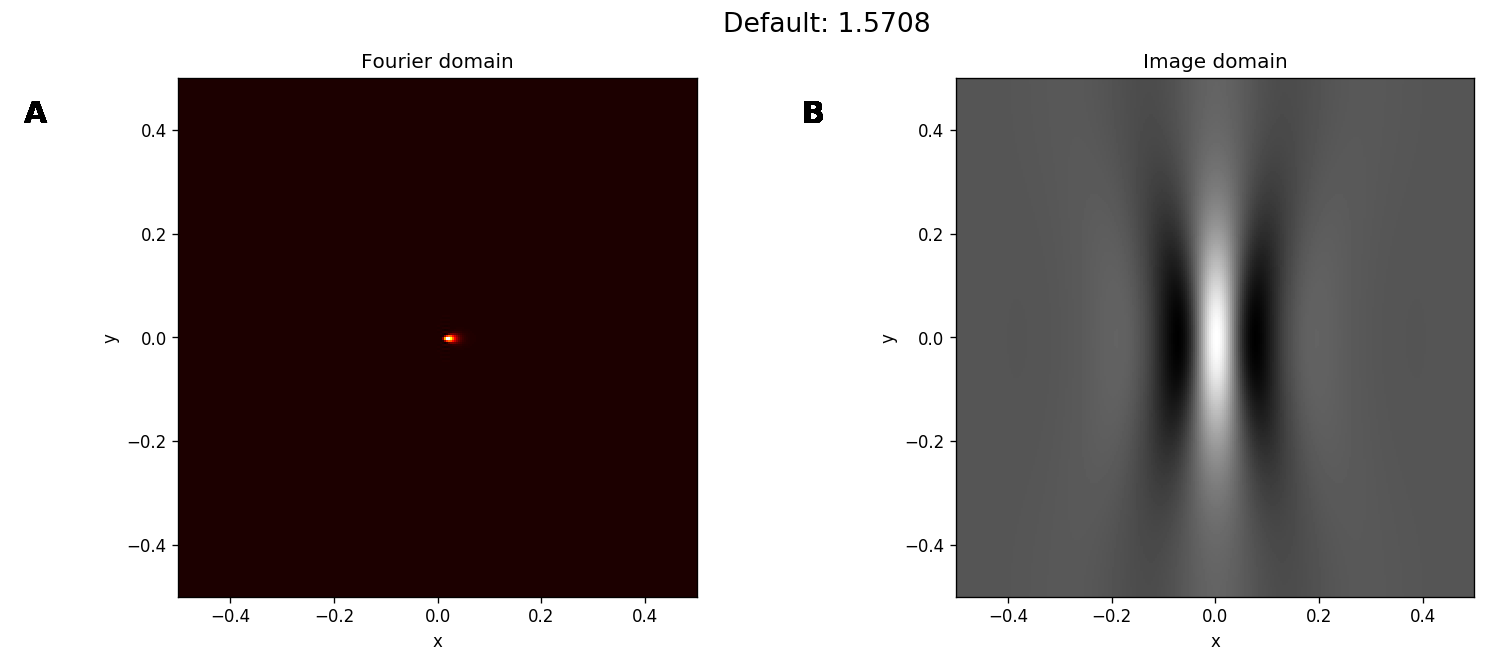

In [15]:
lg_explore(param_name='theta', 
           param_range=lg.theta, 
           angle=True)

:Layout
   .Fourier_domain.I :HoloMap   [Default]
      :Image   [x,y]   (z)
   .Image_domain.I   :HoloMap   [Default]
      :Image   [x,y]   (z)
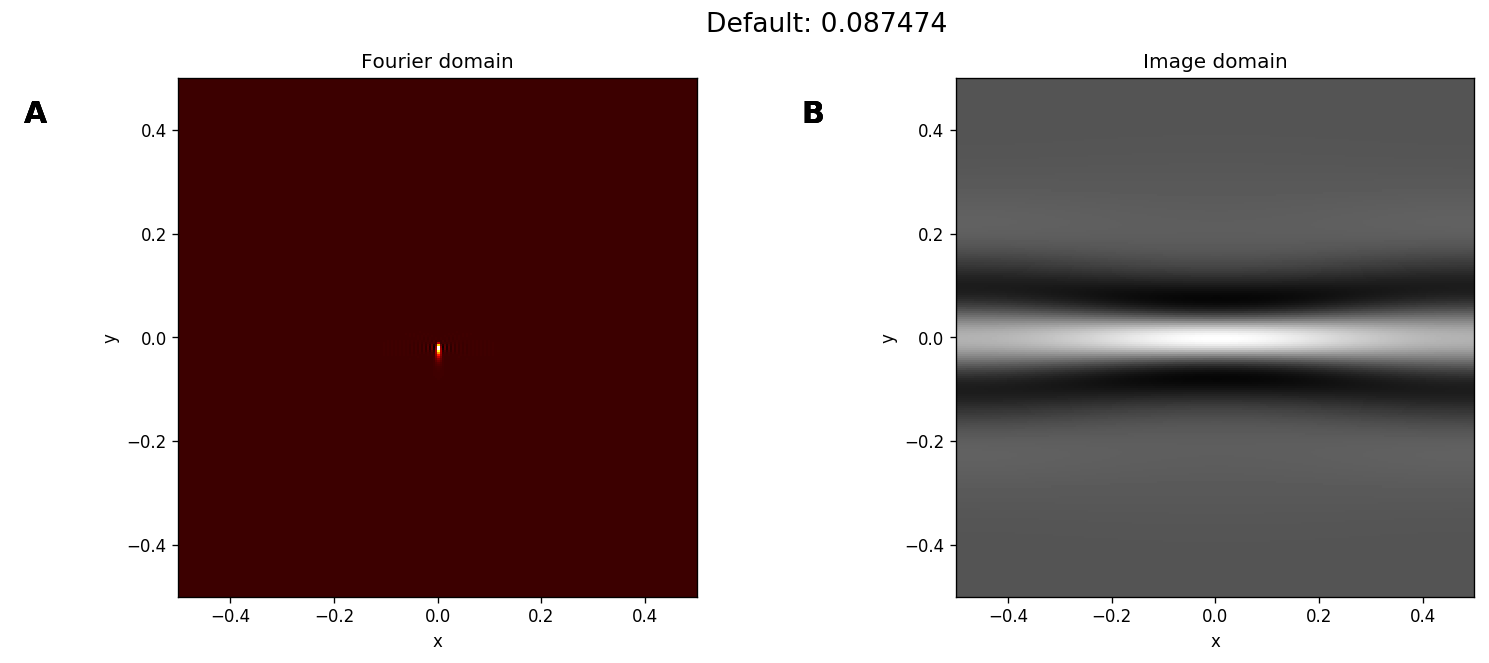
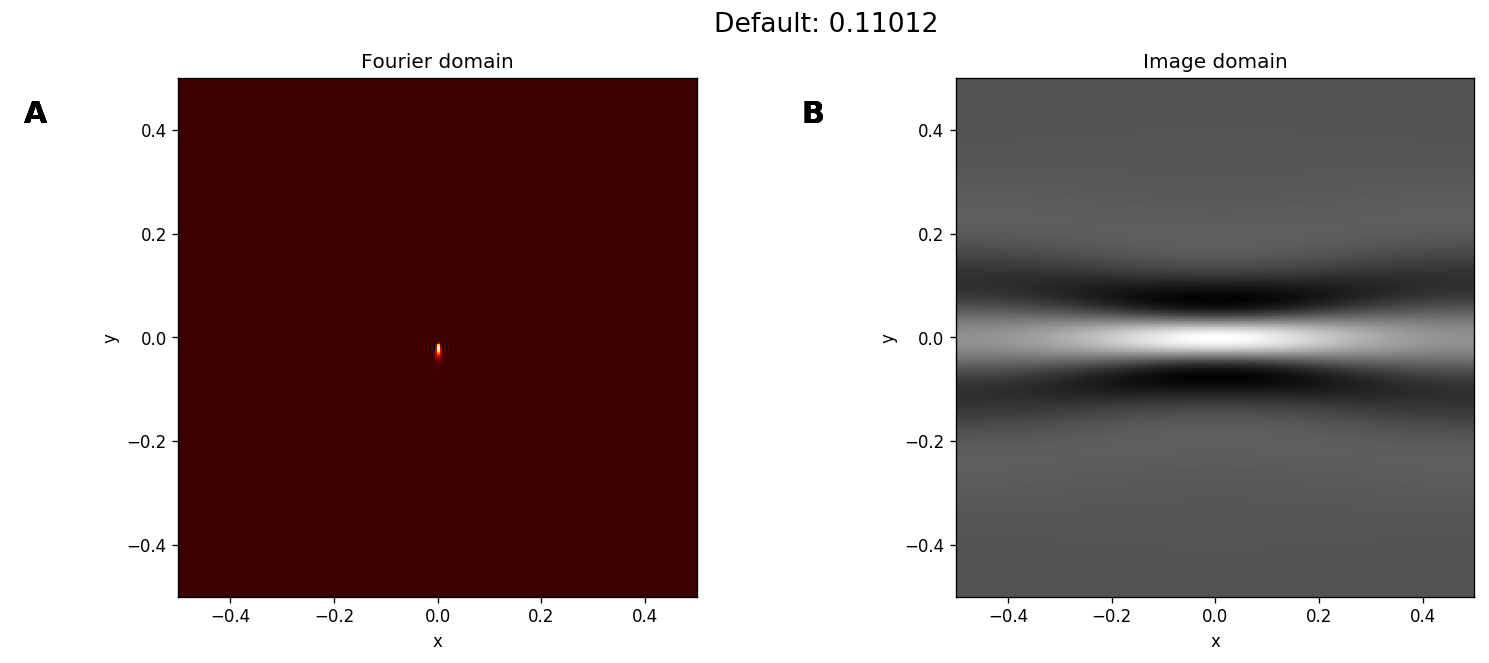
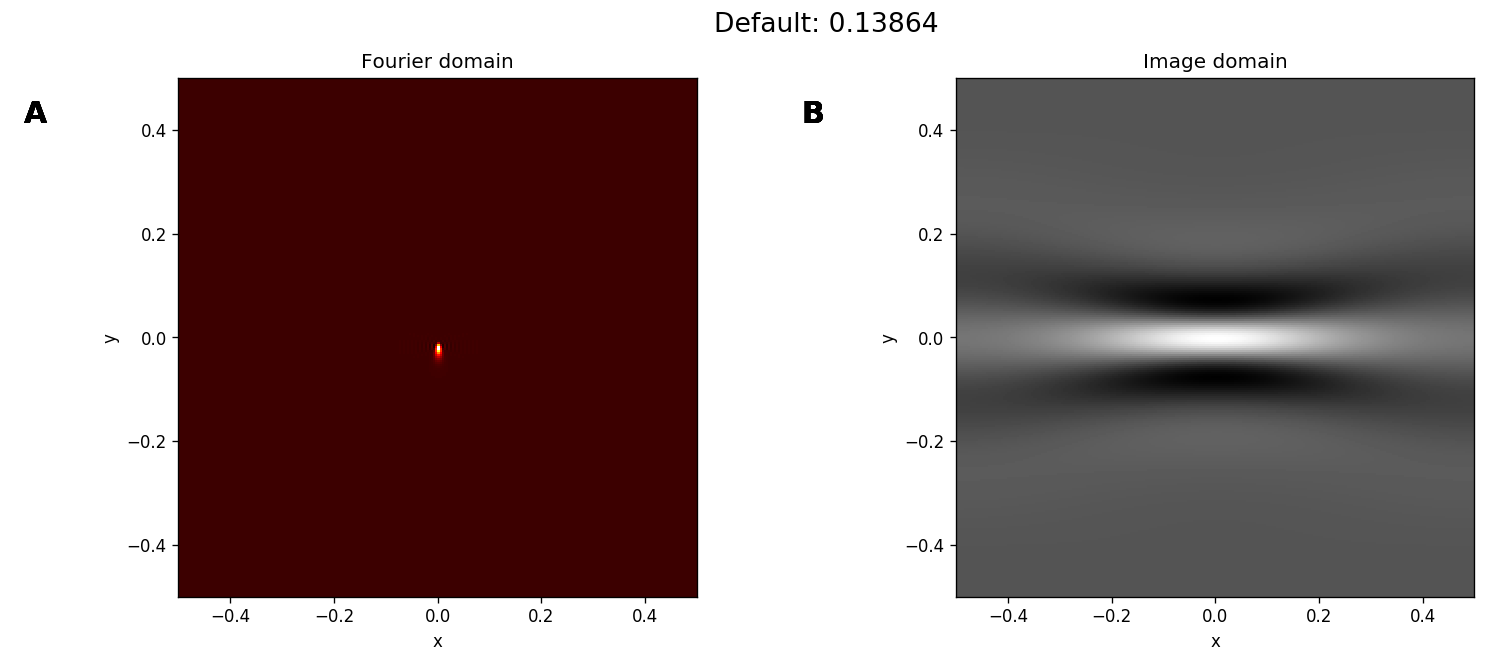
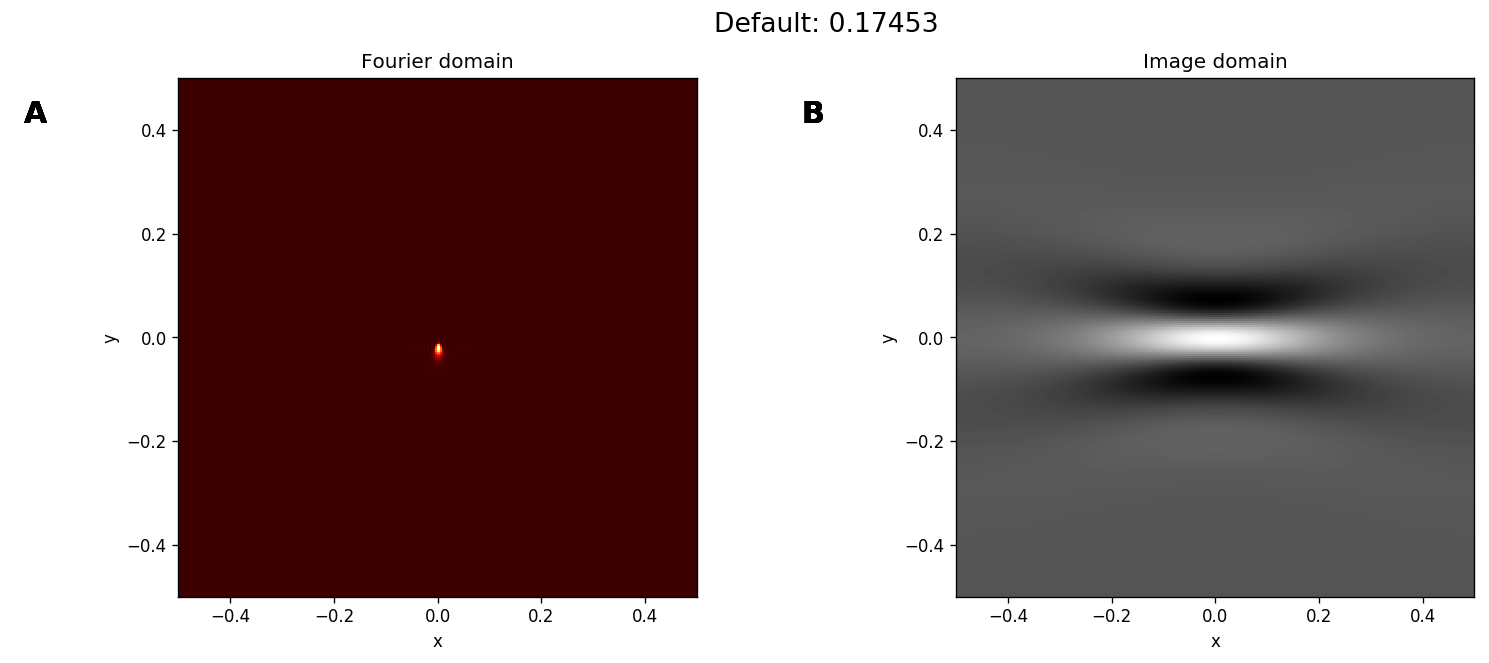
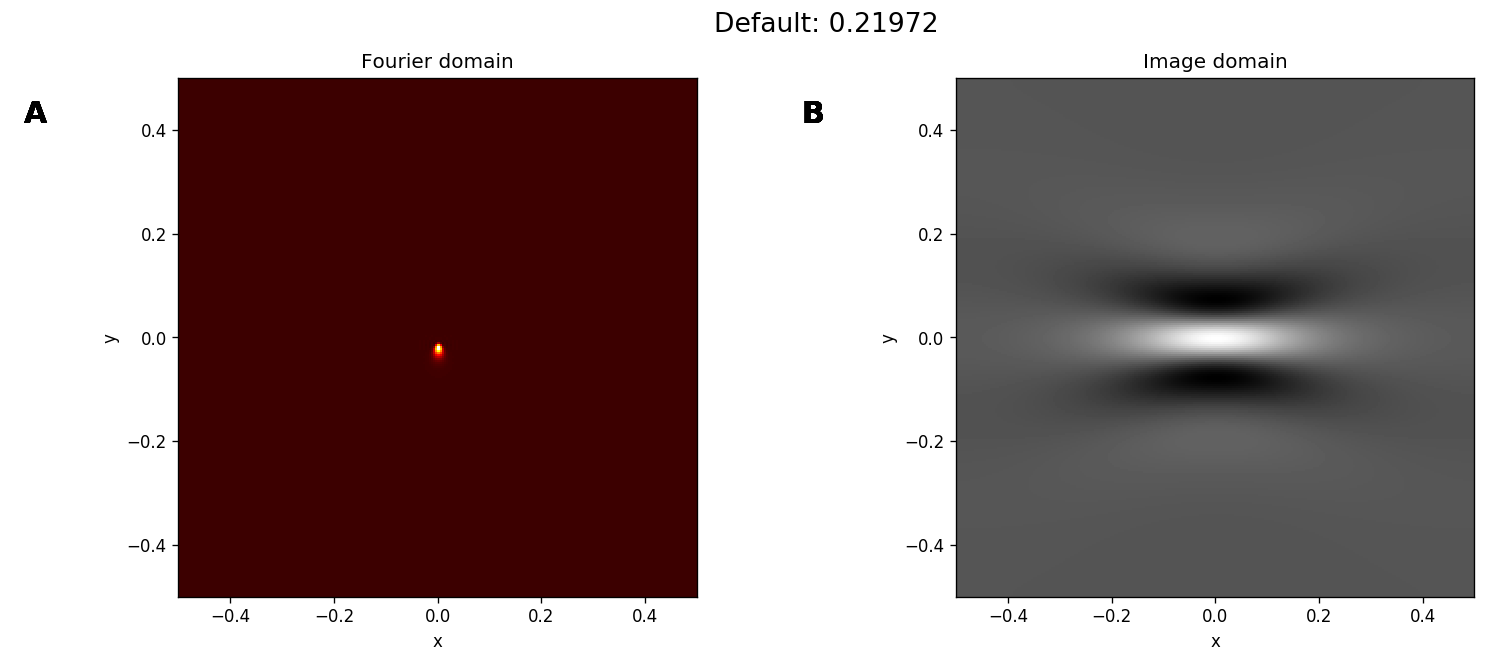
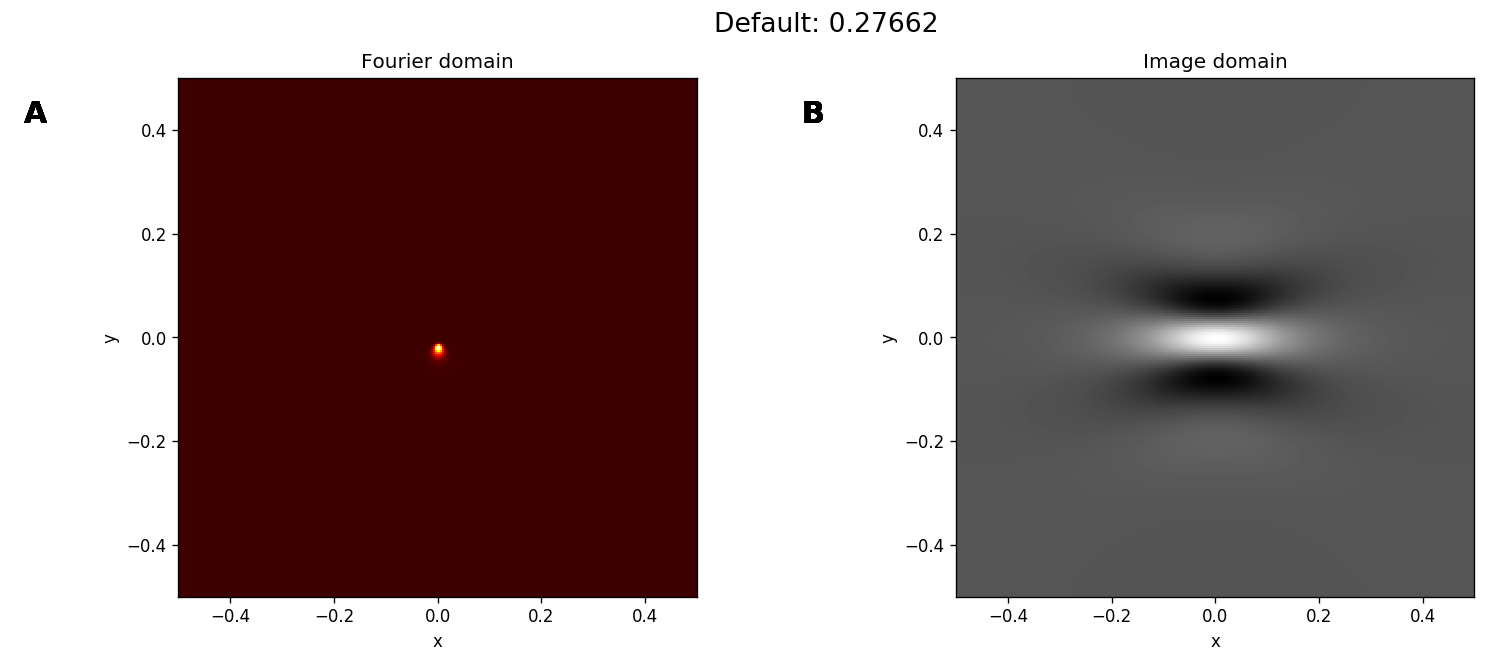

In [16]:
lg_explore(param_name='B_theta', 
           param_range=lg.pe.B_theta*np.logspace(-.3, .2, 6), angle=True)

Here, we define a pyramid by defining a vector of ``sf_0`` values that we use later in Matching Pursuit (see https://github.com/bicv/SparseEdges):

for an image of size 256 , at base lg.pe.base_levels= 1.618 , we have n_levels= 11
Range of spatial frequencies (in cycles per image pixel) = [ 0.45454545  0.29349239  0.18950313  0.122359    0.07900516  0.05101231
  0.03293779  0.02126738  0.01373199  0.00886652  0.00572496]
Range of spatial frequencies (in pixels per cycle) = [   2.2           3.40724334    5.2769578     8.17267242   12.65740166
   19.60311249   30.36026111   47.02036246   72.82264397  112.78384934
  174.67364514]
Range of spatial frequencies (in cycles per image size) = [ 116.36363636   75.13405254   48.51280029   31.32390324   20.22532009
   13.05915069    8.43207504    5.44444974    3.51539008    2.26982854
    1.4655903 ]


:Layout
   .Fourier_domain.I :HoloMap   [Default]
      :Image   [x,y]   (z)
   .Image_domain.I   :HoloMap   [Default]
      :Image   [x,y]   (z)
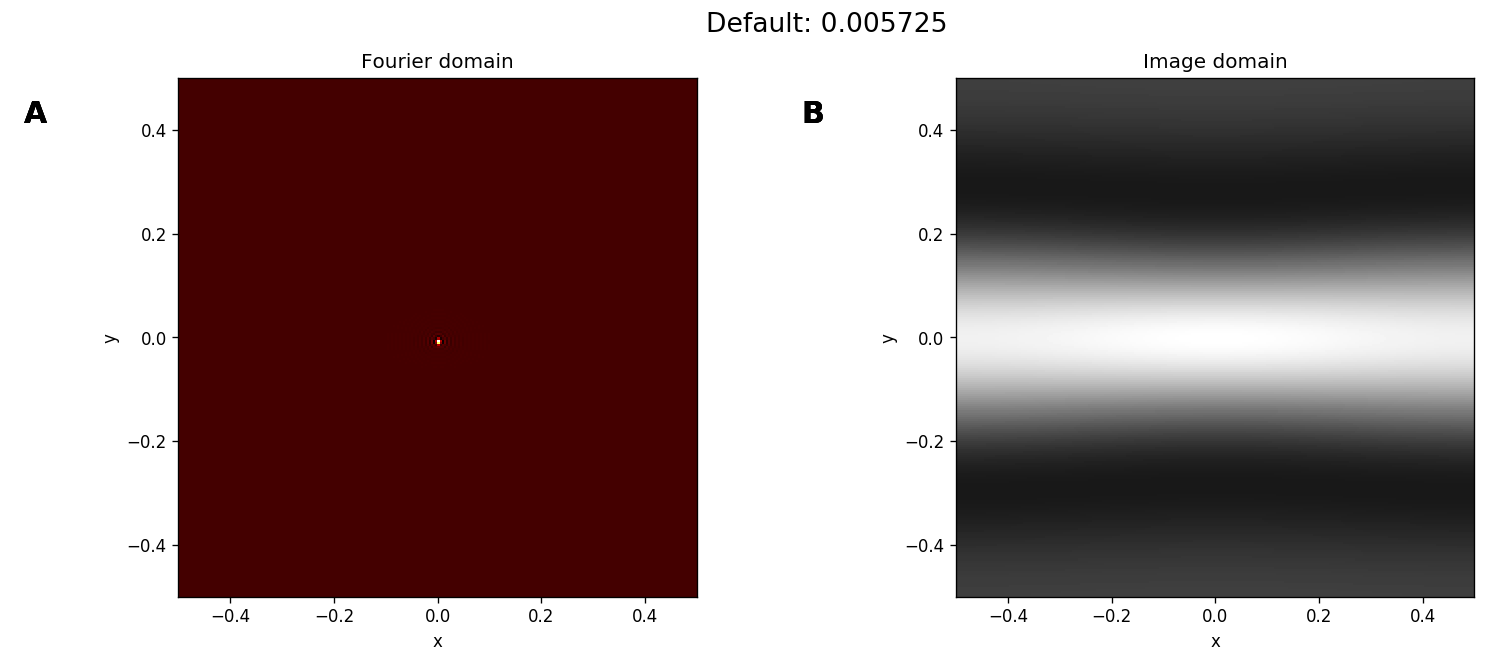
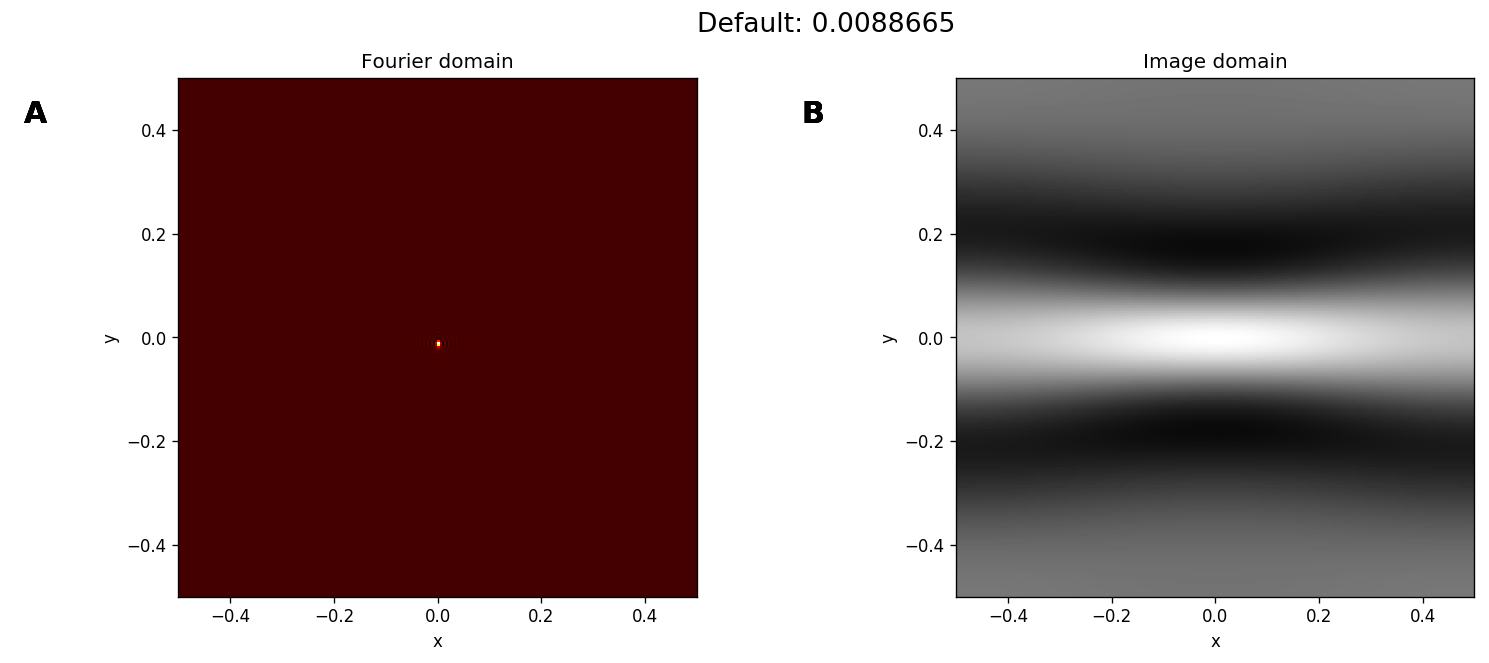
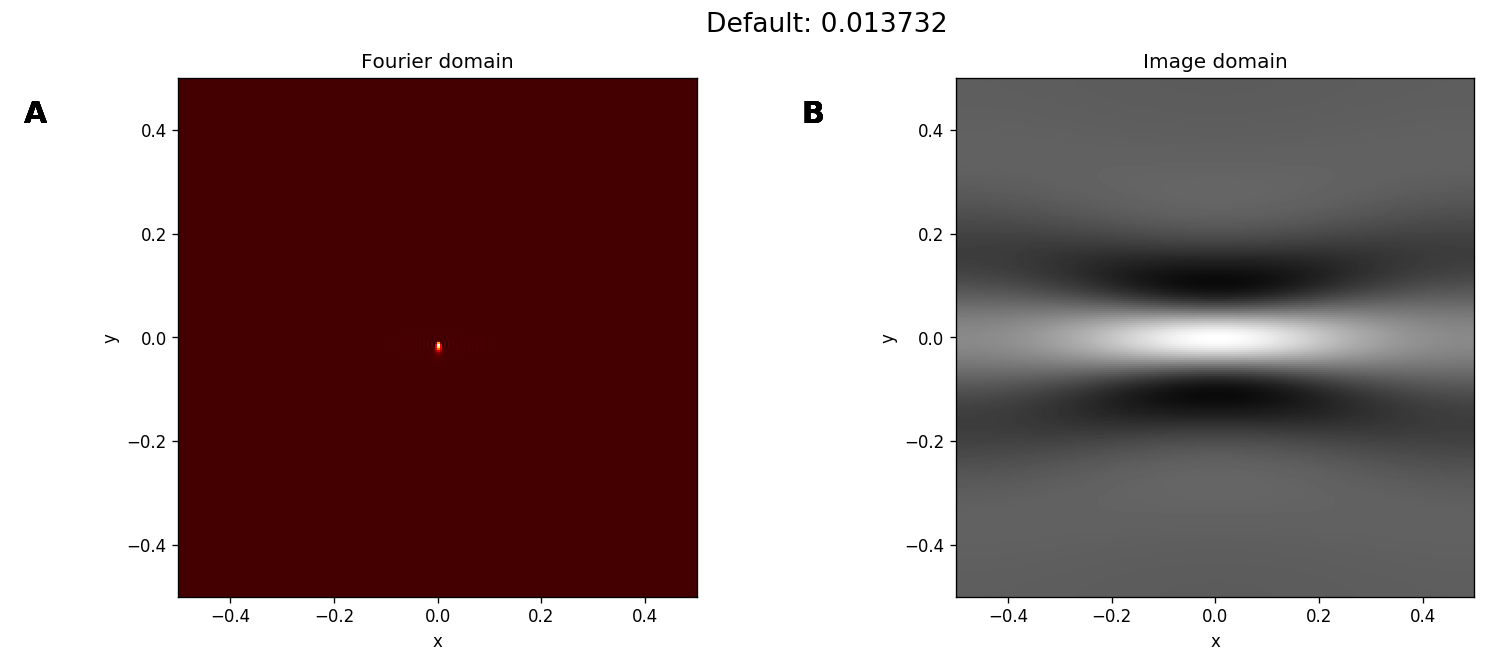
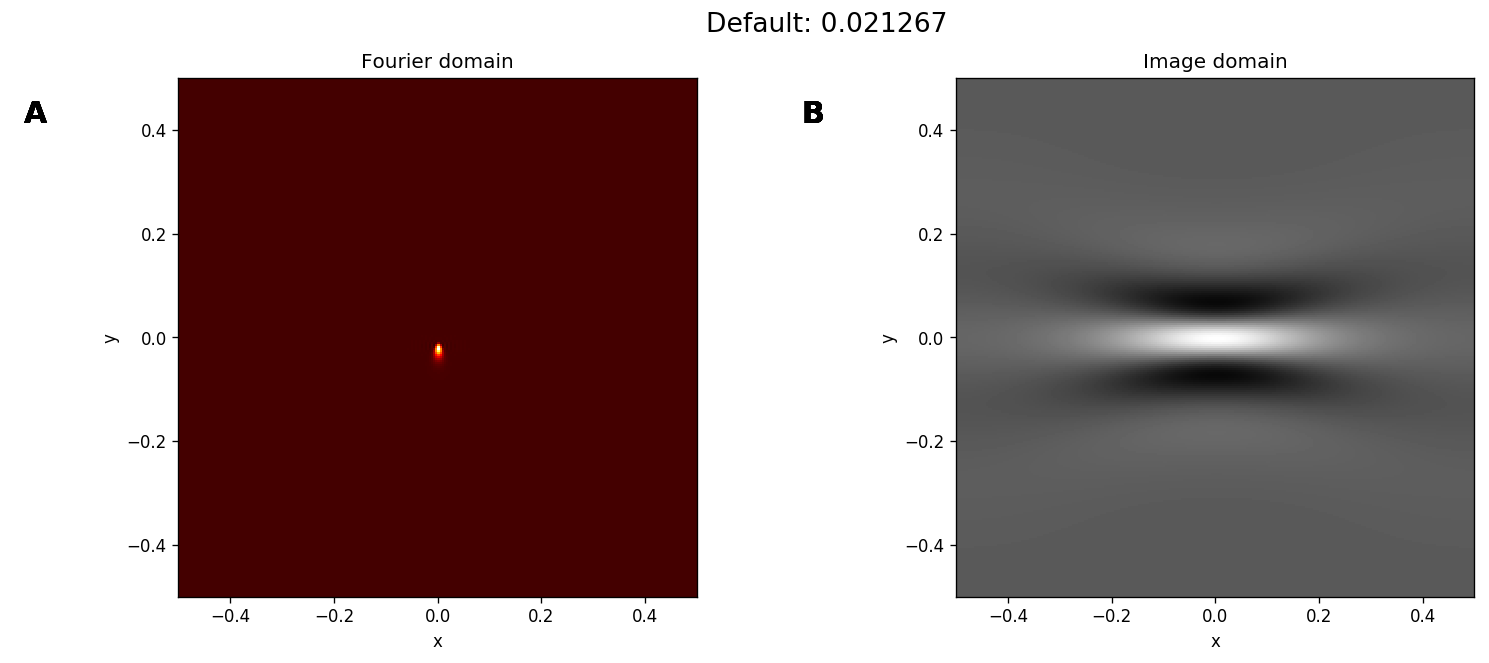
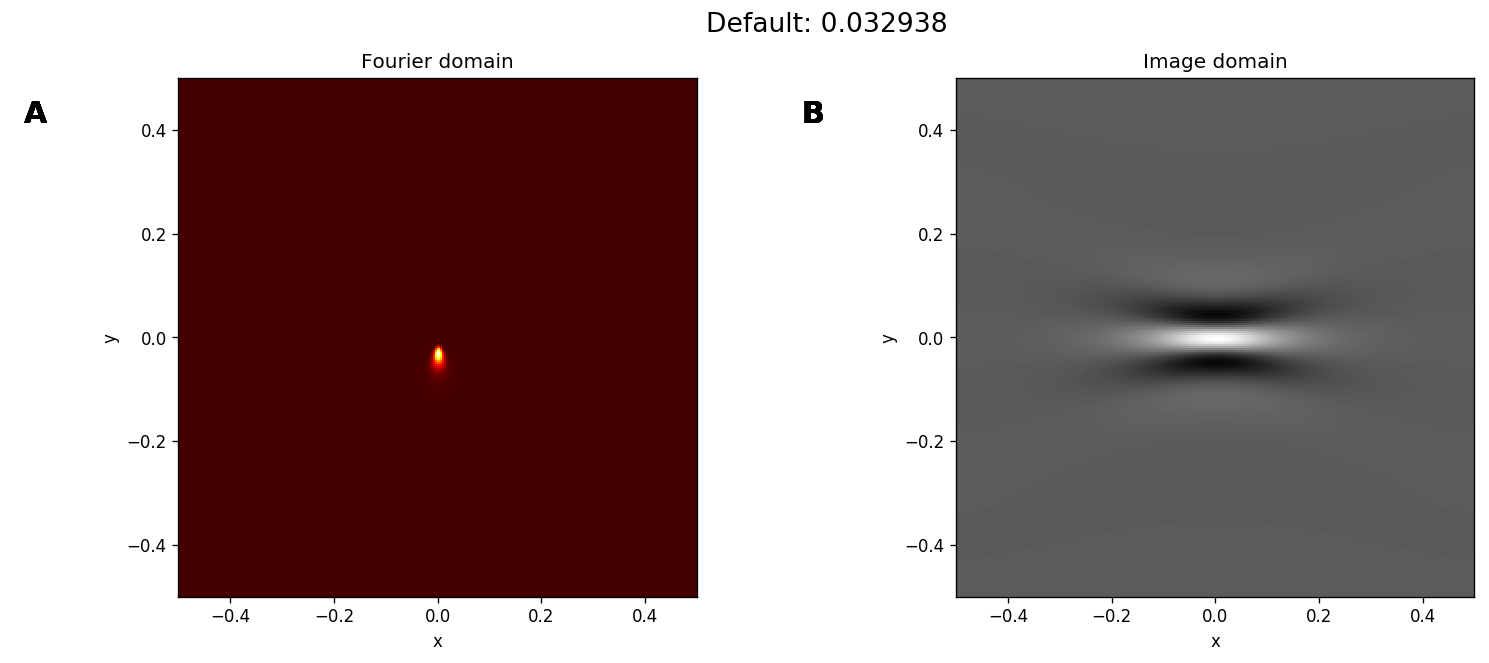
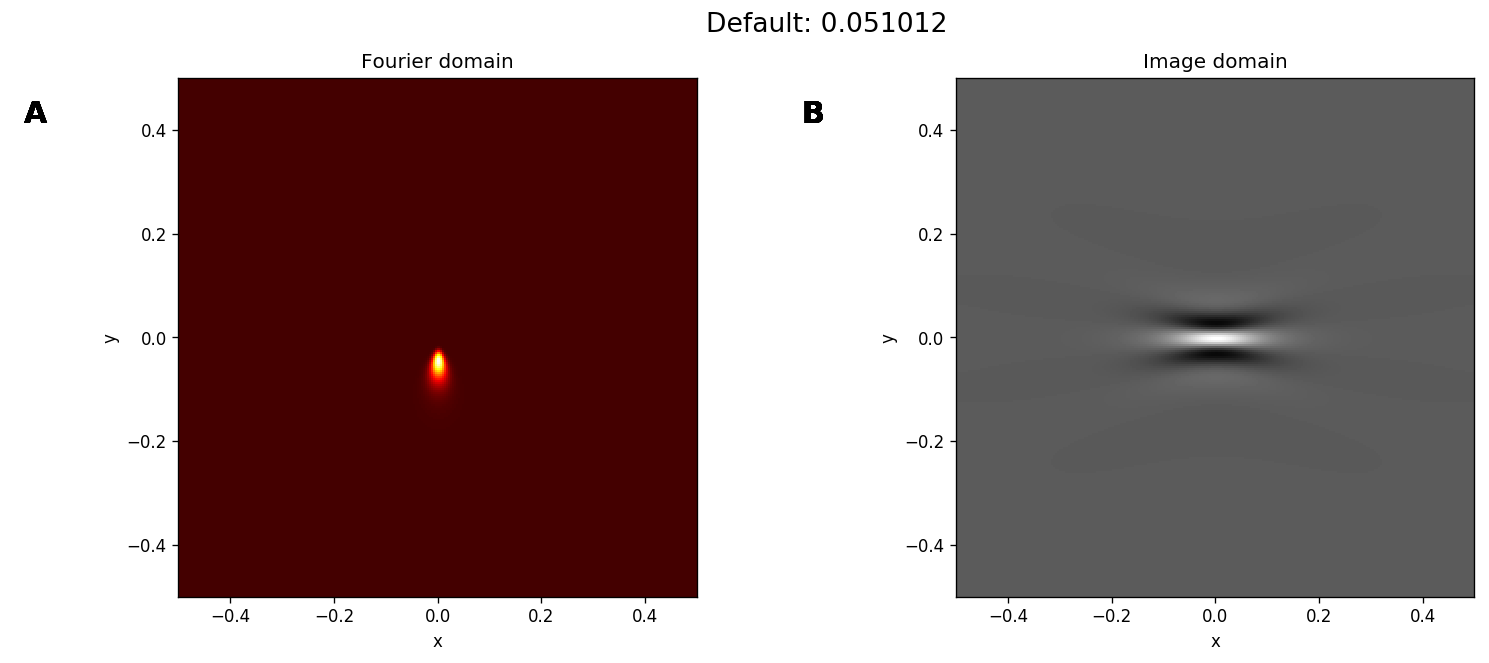
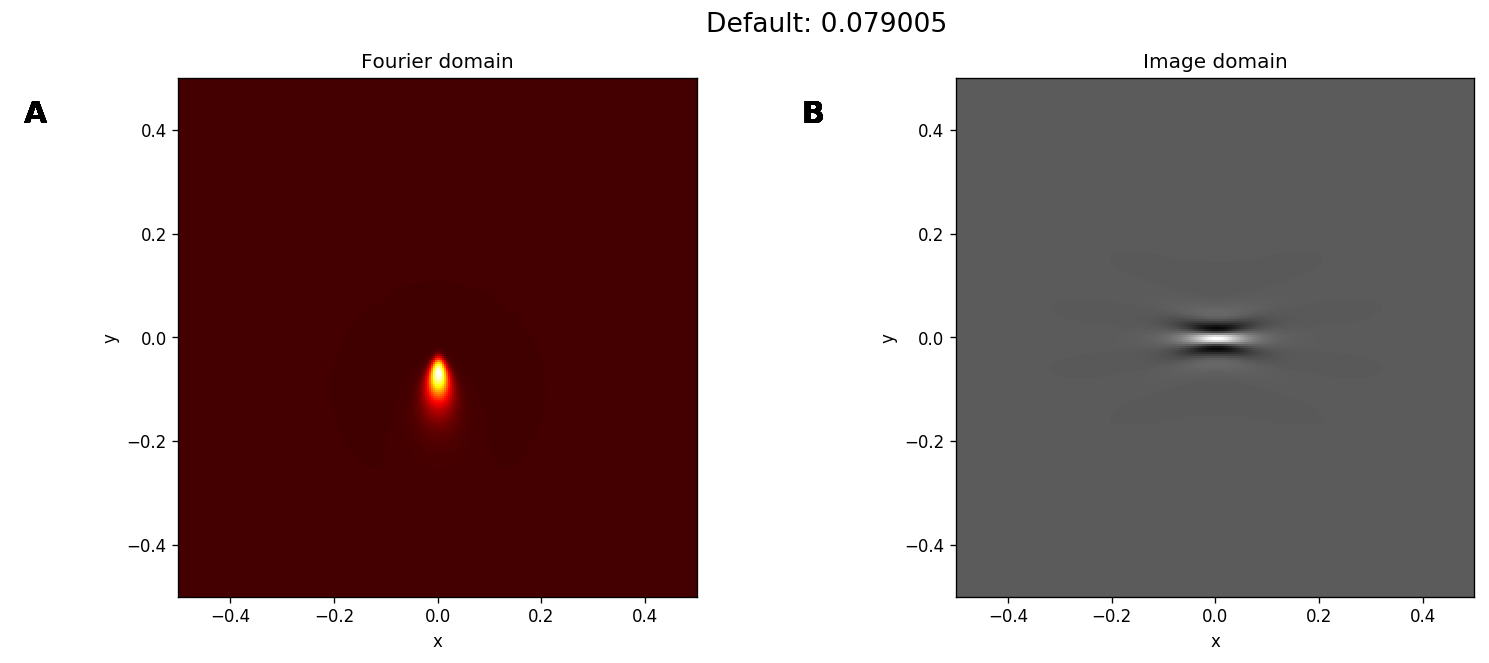
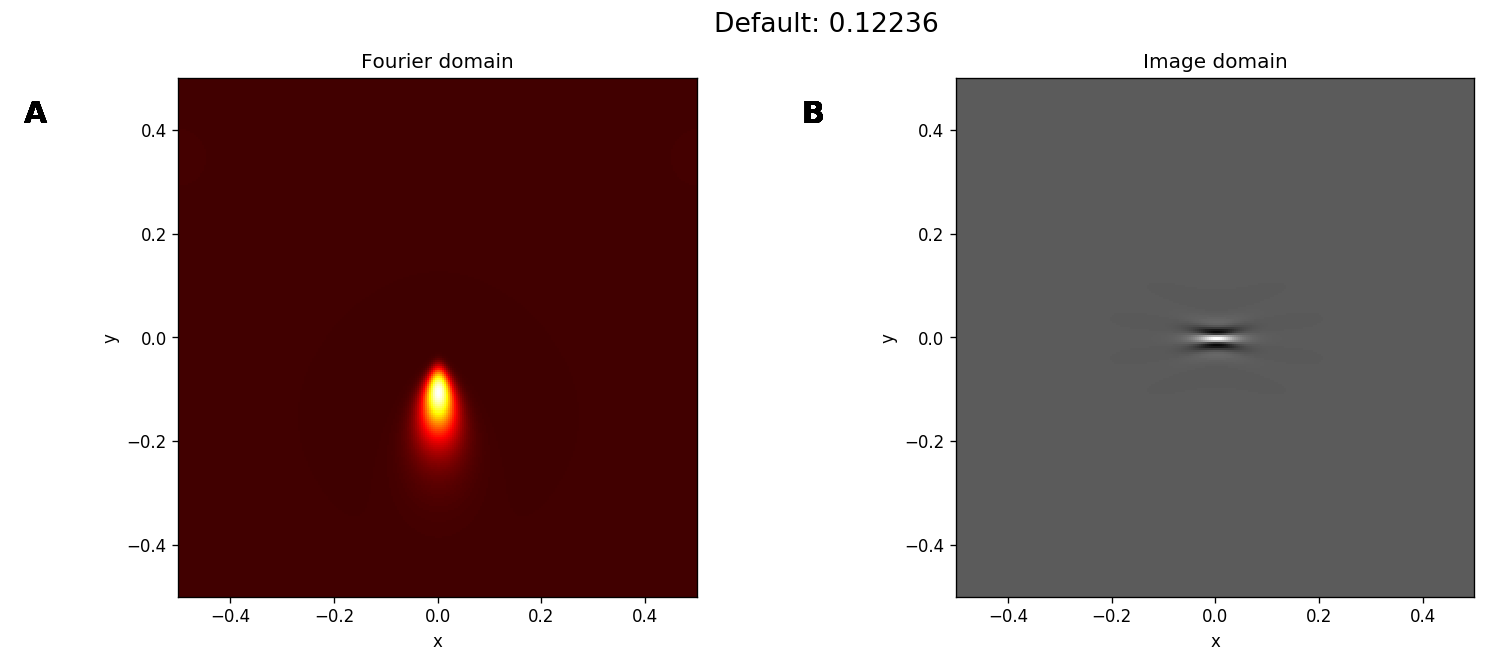
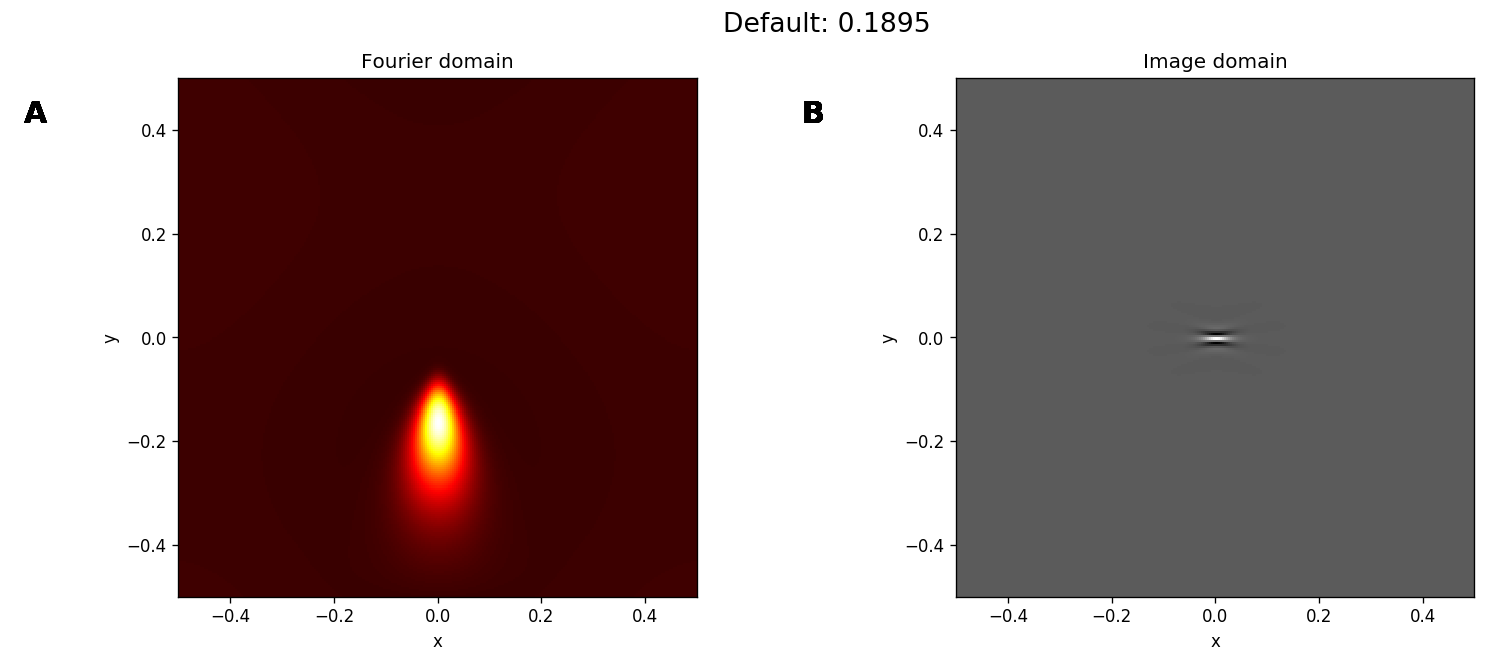
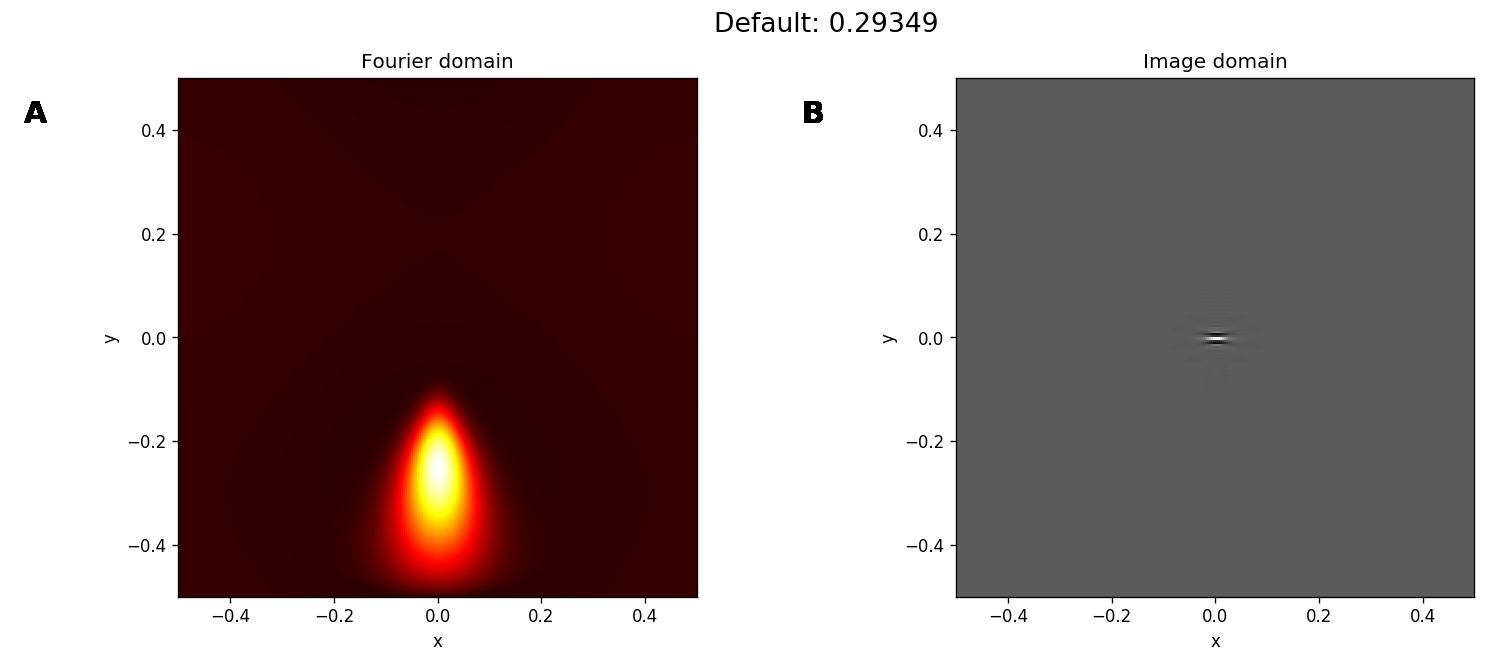
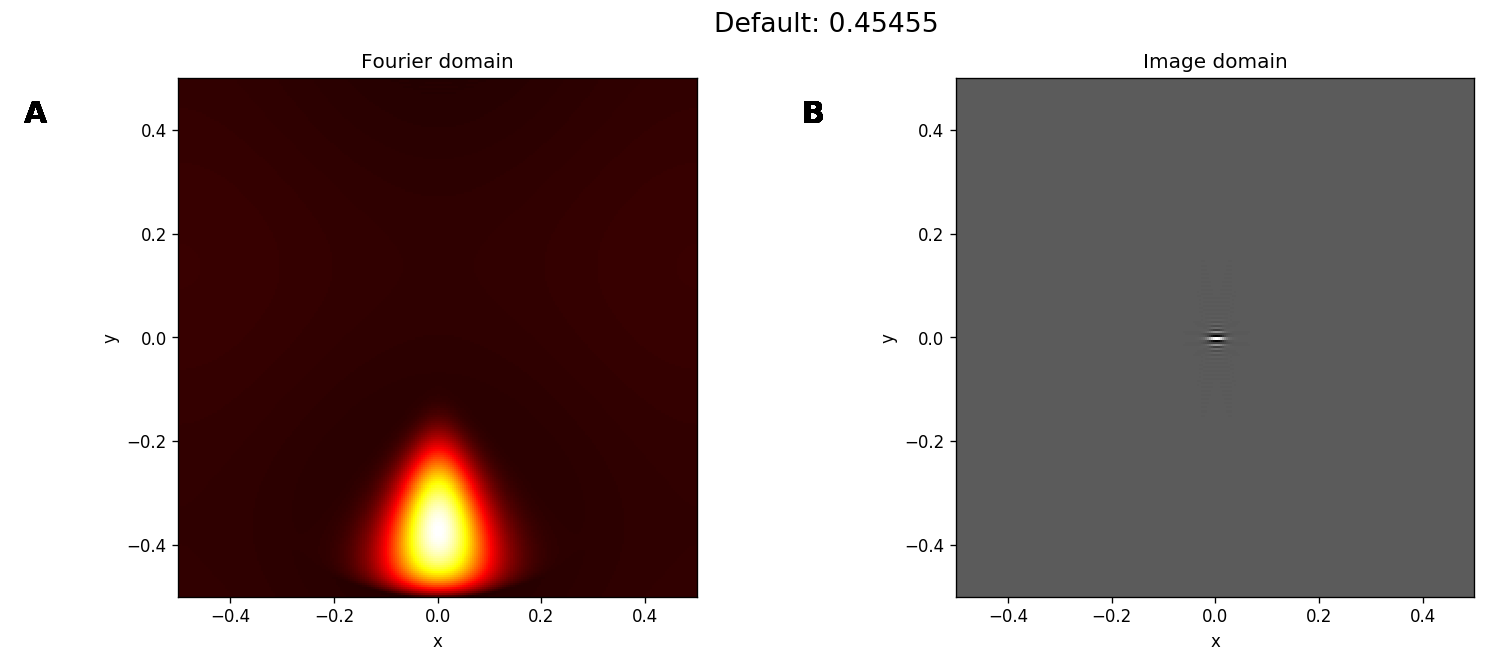

In [17]:
#n_levels = int(np.log(np.max((lg.pe.N_X, lg.pe.N_Y)))/np.log(lg.pe.base_levels))
print('for an image of size', np.max((lg.pe.N_X, lg.pe.N_Y)), ', at base lg.pe.base_levels=', lg.pe.base_levels, ', we have n_levels=', lg.n_levels)
#v_sf_0 = .5 * (1 - 1/n_levels) / np.logspace(0, n_levels, n_levels, base=lg.pe.base_levels)[::-1]
print('Range of spatial frequencies (in cycles per image pixel) =', lg.sf_0)
print('Range of spatial frequencies (in pixels per cycle) =', 1./lg.sf_0)
print('Range of spatial frequencies (in cycles per image size) =', lg.pe.N_X * lg.sf_0)
lg_explore(param_name='sf_0', param_range=lg.sf_0)

geometric mean distances across frequencies :

In [18]:
scaling = np.sqrt(lg.sf_0[:, np.newaxis]*lg.sf_0[np.newaxis, :])
print('mean scaling=', scaling.mean())

mean scaling= 0.0805700639639


:Layout
   .Fourier_domain.I :HoloMap   [Default]
      :Image   [x,y]   (z)
   .Image_domain.I   :HoloMap   [Default]
      :Image   [x,y]   (z)
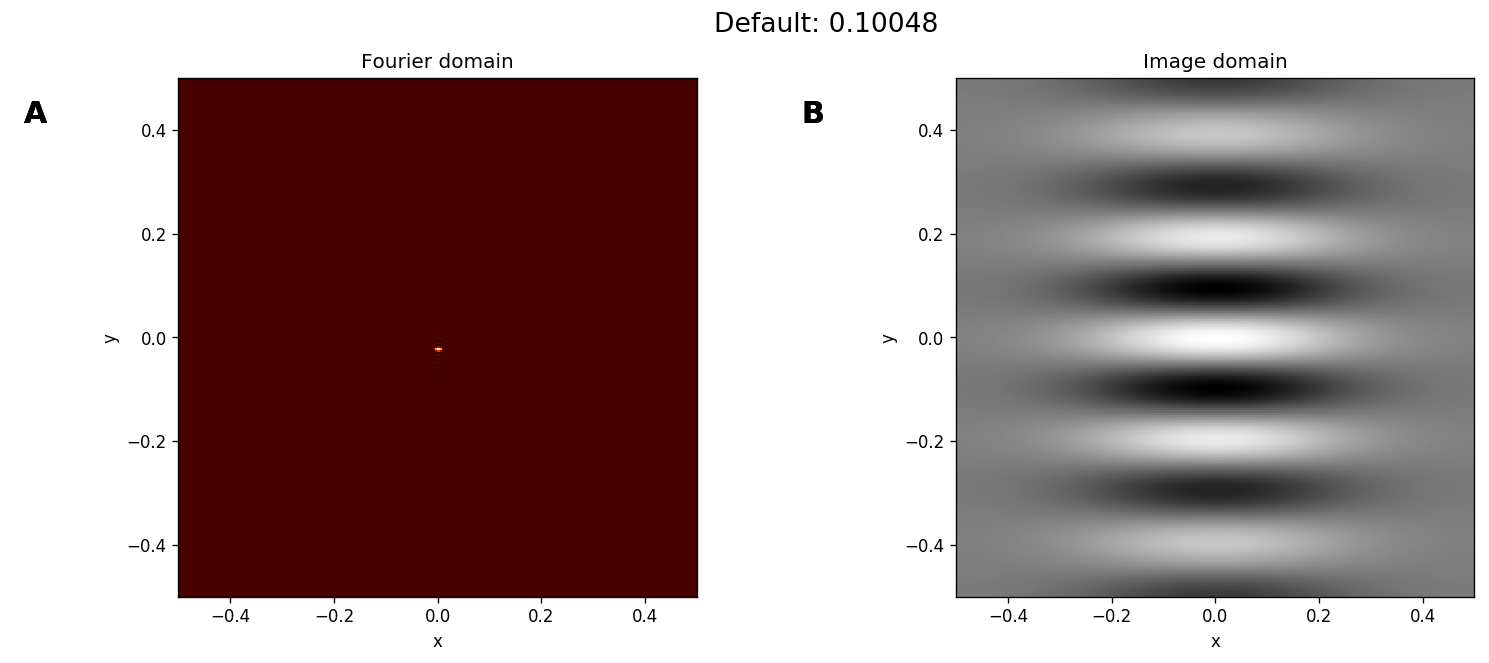
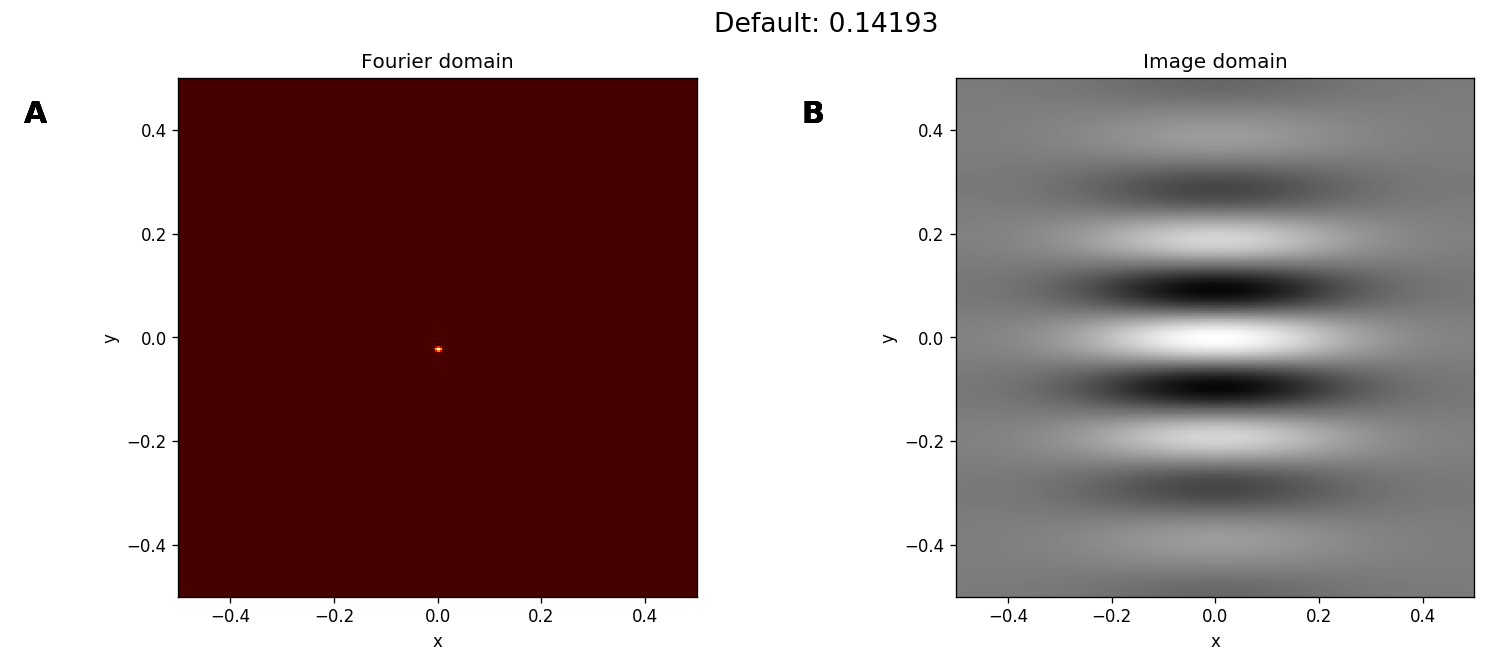
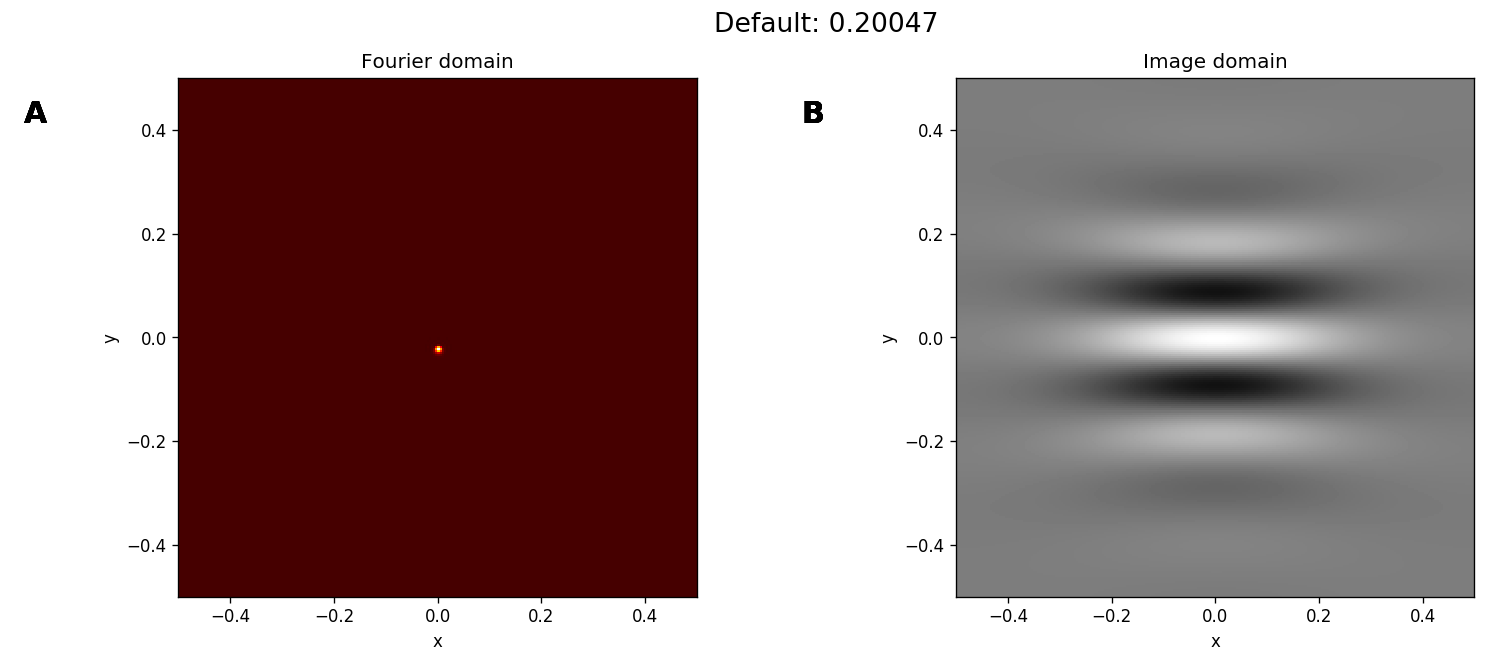
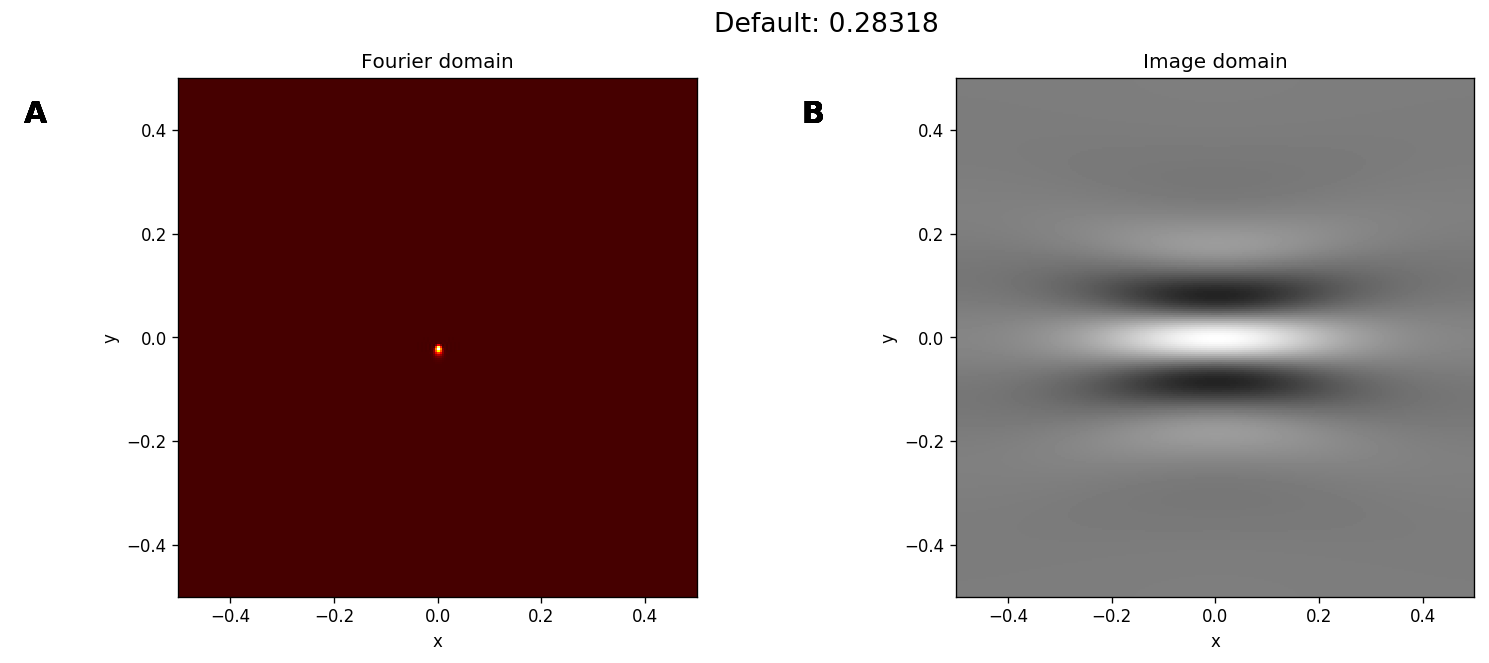
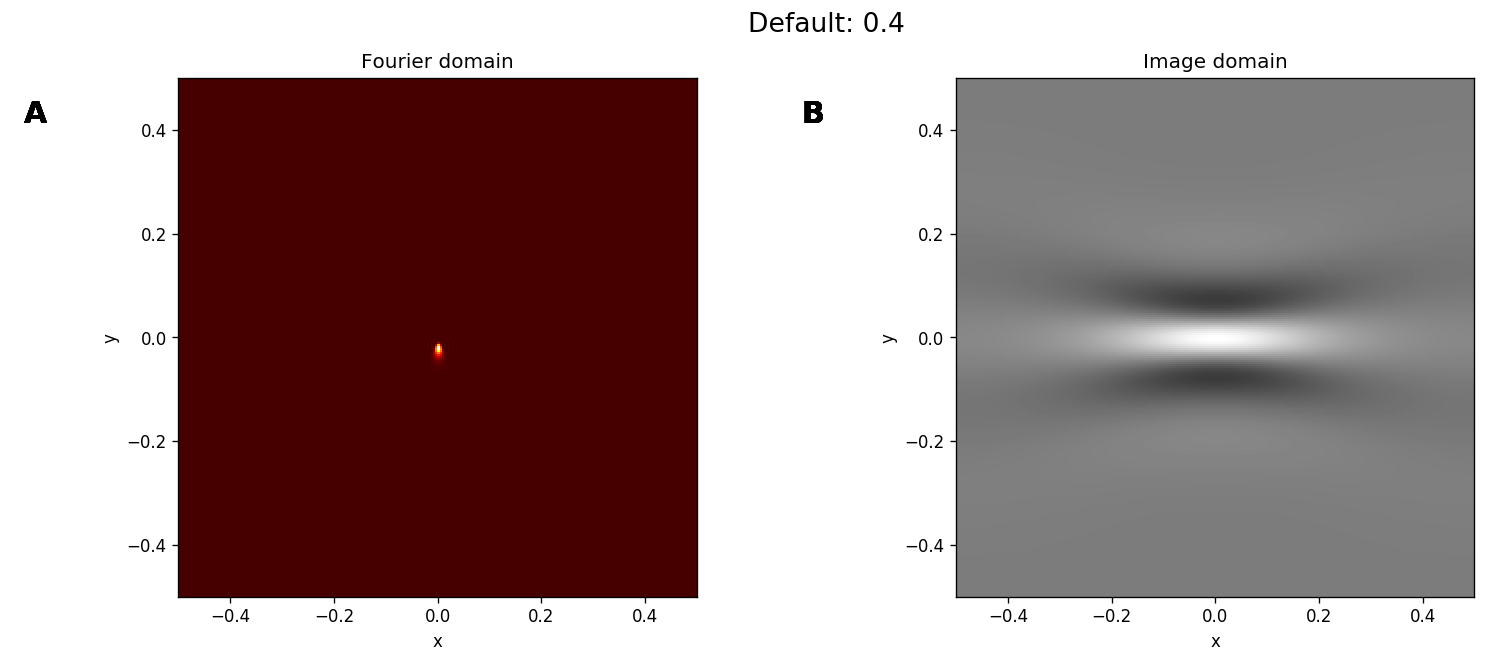
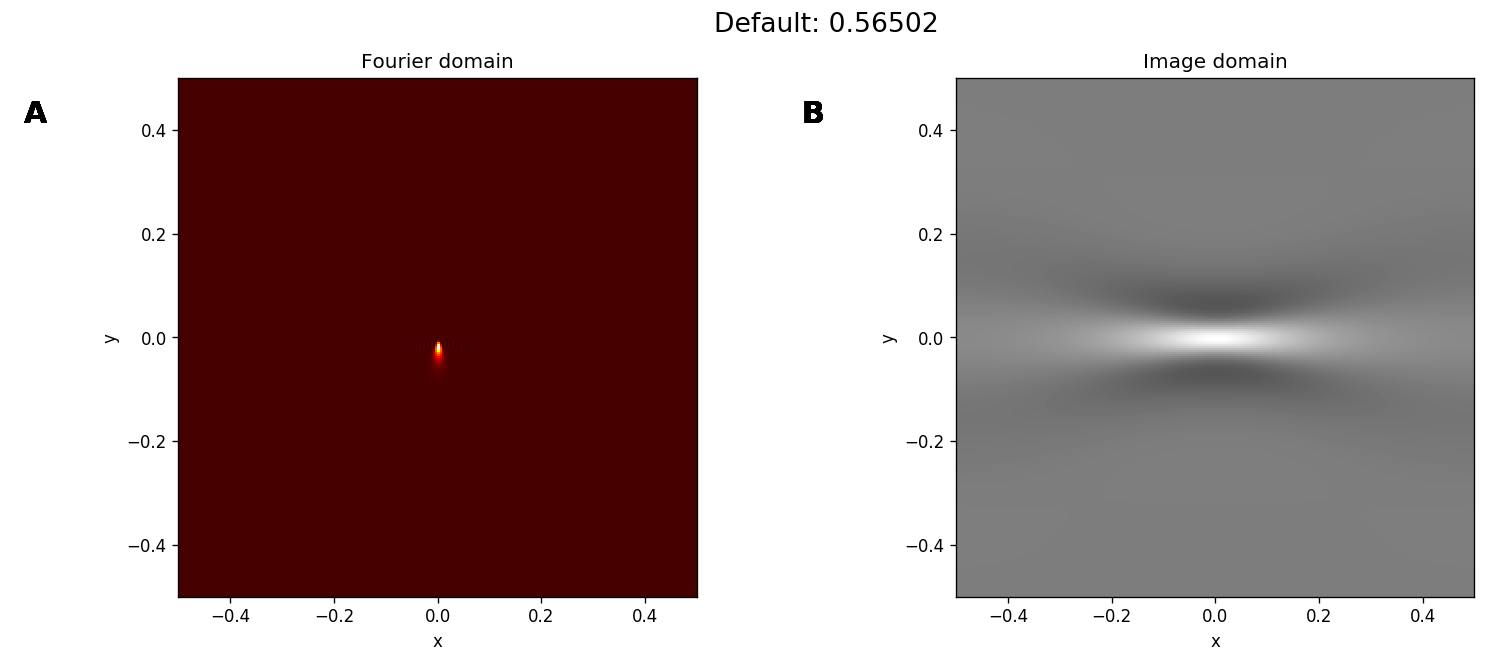
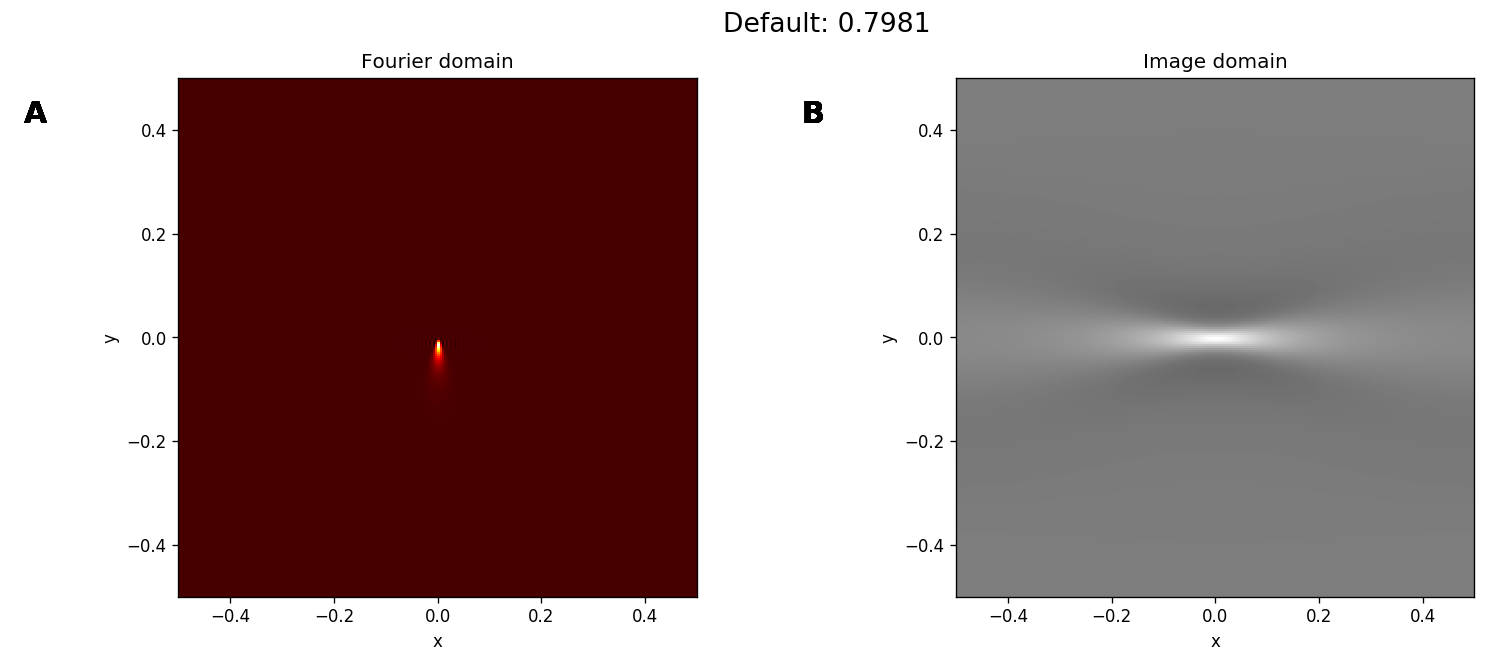
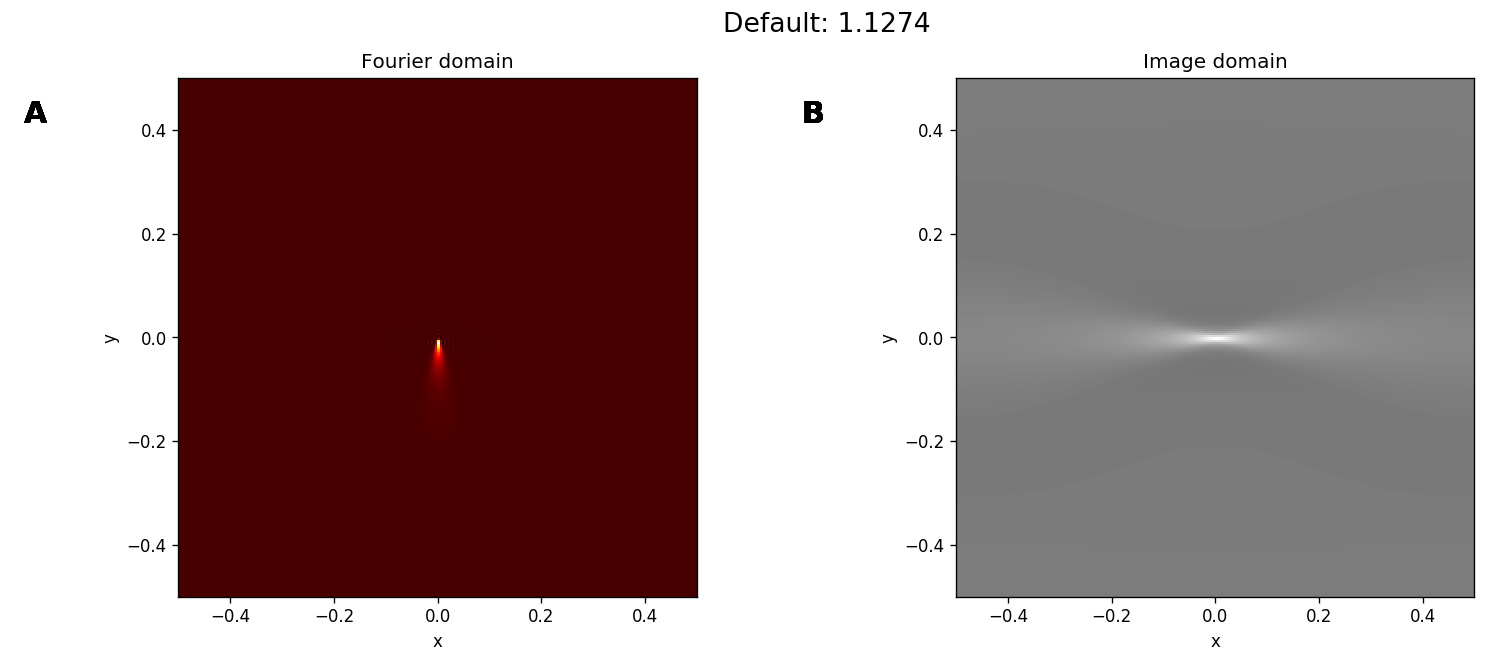
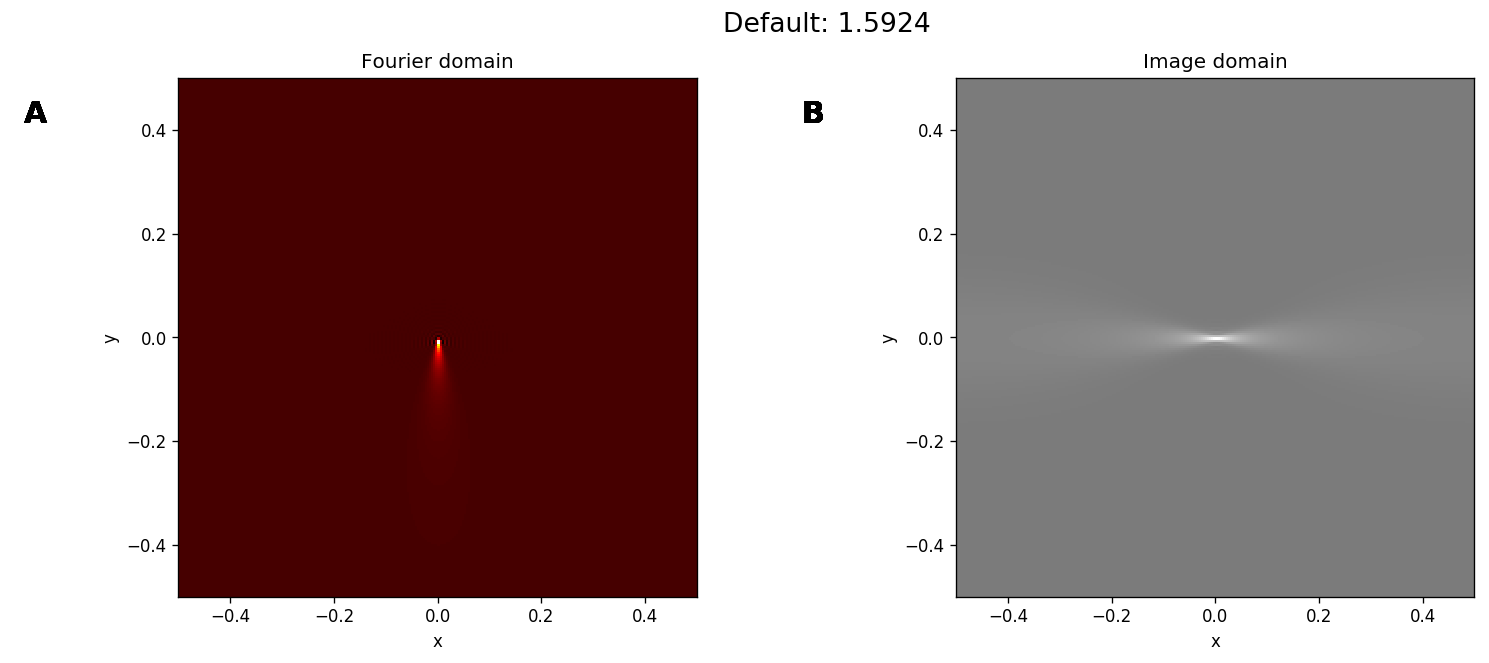

In [19]:
lg_explore(param_name='B_sf', param_range=lg.pe.B_sf*np.logspace(-.6, .6, 9))

[Back to top](#LogGabor-user-guide)

## more book keeping

In [20]:
%load_ext watermark
%watermark

2017-12-05T12:38:24+01:00

CPython 3.6.3
IPython 5.0.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)
system     : Darwin
release    : 17.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [21]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, SLIP, LogGabor

Software versions
Python 3.6.3 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]
IPython 5.0.0
OS Darwin 17.2.0 x86_64 i386 64bit
numpy 1.13.3
scipy 1.0.0
matplotlib 2.1.0
sympy 1.1.1
SLIP 2016-12-05
LogGabor 2016-12-05
Tue Dec 05 12:38:24 2017 CET

[Back to top](#LogGabor-user-guide)
[Back to the LogGabor user guide](LogGabor.ipynb#LogGabor-user-guide)